# Avant propos

# Avant Propos

Ce rapport constitue une synthèse des travaux menés dans le cadre de notre challenge de prédiction des mouvements de prix sur les marchés financiers américains. Il convient de souligner que la majeure partie du travail d'analyse et d'expérimentation n'est pas visible dans ce document final, mais réside dans une multitude de notebooks et scripts distincts élaborés tout au long du projet. L'ensemble de ces ressources, ainsi que les fonctions utilitaires développées pour le prétraitement des données, l'ingénierie de features et l'évaluation des modèles, sont disponibles sur notre dépôt GitHub: [[PROJET MACHINE LEARNING](https://github.com/Julien-Zanin/ML-DataChallenge)].

Nous tenons à mettre en lumière les nombreux défis techniques rencontrés lors de ce travail. La nature particulière des données financières - caractérisées par leur haute dimensionnalité, leur bruit inhérent et l'absence de structure de clustering nette - a considérablement complexifié notre tâche de modélisation. Ces caractéristiques ont parfois engendré des temps de calcul prohibitifs, comme nous l'avons expérimenté avec l'algorithme K-means qui a nécessité plus de dix heures d'exécution sur l'ensemble du jeu de données (nous avons abandonné son exécution), ou encore avec le Random Forest dont la complexité computationnelle s'est avérée peu compatible avec la taille de nos données.

Face à ces contraintes, nous avons dû adopter des stratégies pragmatiques, notamment l'utilisation d'échantillonnages aléatoires pour l'optimisation des hyperparamètres et l'exploration initiale des modèles. Même avec ces adaptations, certains algorithmes comme SVM ont nécessité plusieurs heures de traitement malgré un échantillonnage drastique. Ces difficultés illustrent le délicat équilibre à trouver entre performance prédictive et faisabilité computationnelle dans l'analyse de données financières à grande échelle.
Les multiples tentatives d'amélioration de nos données, telles que diverses stratégies d'imputation, différentes approches de normalisation, et création de features innovantes, ont constitué une part significative mais peu visible de notre travail. Ces expérimentations, bien que pas toutes concluantes, ont été essentielles pour comprendre les limites et possibilités offertes par nos données.

Ce rapport privilégie donc la clarté et la synthèse, présentant les résultats les plus pertinents et les approches les plus prometteuses identifiées au terme de nombreuses itérations d'analyse et de modélisation.

Les données pourront être envoyées par ZIP si besoin. 


Concernant l'optimisation des paramètres : Au vu du projet et des données ainsi que la nécessité de conserver les données, l'optimisation des paramètres est trop couteuse et la réduction de dimension ne permet pas de suffisamment expliquer la variance. Il faudrait faire de nombreux tests gourmands en calculs afin de trouver un équilibre optimal que nos maigres moyens techniques et en temps ne nous permettent pas. 

# Importation des librairies 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Importation de nos fonctions personnalisées 
from utils.data_registry import DATASETS
from utils.benchmarks import get_models, get_unsupervised_models, get_supervised_advanced_models
from utils.data_loading import load_datasets
from utils.data_preprocessing import normalize_rendements_by_row, create_low_nan_dataset
from utils.feature_engineering import add_features, add_financial_features
from utils.experiment_runner import run_experiment, display_experiment_result, add_result
from utils.data_analysis import (
    analyze_distributions,
    compare_column_stats,
    analyze_normalization,
    compare_normalization_impact,
    perform_pca_analysis,
    analyze_correlations
)
from utils.feature_selection import (
    select_by_correlation,
    select_by_f_value,
    select_by_mutual_info,
    optimize_feature_count,
    find_important_features
)
from utils.model_interpretation import analyze_feature_importance, analyze_with_shap, plot_shap_summary
from utils.model_evaluation import optimize_hyperparameters, evaluate_model_performance, plot_confusion_matrix, create_results_summary

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from IPython.display import display
from tqdm import tqdm

# Create empty results tracker qui serviera à recueuillir les résultats des modèles 
results_tracker = pd.DataFrame(columns=[
    "dataset", "dataset_description", "model", "model_description",
    "features_added", "feature_sets", "normalize_by_row", "accuracy", 
    "precision_weighted", "recall_weighted", "f1_weighted",
    "training_time", "prediction_time", "total_time", "notes"
])

# Prédiction de la direction des prix sur les marchés financiers

## Prédiction de la direction des prix sur les marchés financiers - Sommaire



### [1. Introduction et présentation du problème](#1-introduction-et-présentation-du-problème)
- [1.1 Contexte et enjeux](#11-contexte-et-enjeux)
- [1.2 Description des données](#12-description-des-données)
- [1.3 Problématique et défis](#13-problématique-et-défis)

### [2. Exploration des données (EDA)](#2-exploration-des-données-eda)
- [2.1 Aperçu des données et analyse des valeurs manquantes](#21-aperçu-des-données-et-analyse-des-valeurs-manquantes)
- [2.2 Distribution des rendements](#22-distribution-des-rendements)
- [2.3 Analyse de la variable cible](#23-analyse-de-la-variable-cible)

### [3. Stratégies d'imputation](#3-stratégies-dimputation)
- [3.1 Chargement des datasets avec différentes stratégies](#31-chargement-des-datasets-avec-différentes-stratégies-dimputation)
- [3.2 Analyse des distributions après imputation](#32-analyse-des-distributions-après-imputation)
- [3.3 Comparaison des statistiques entre stratégies](#33-comparaison-des-statistiques-entre-les-stratégies-dimputation)
- [3.4 Impact des méthodes de normalisation](#34-impact-des-méthodes-de-normalisation)

### [4. Modèles de référence (benchmarks)](#4-modèles-de-référence-benchmarks)
- [4.1 XGBoost baseline](#41-xgboost-baseline)
- [4.2 Benchmark XGBoost sur différentes stratégies d'imputation](#42-benchmark-xgboost-sur-les-différentes-stratégies-dimputation)
- [4.3 Visualisation des résultats des benchmarks](#43-visualisation-des-résultats-des-benchmarks)
- [4.4 Test avec régression logistique](#44-régression-logistique-)
- [4.5 Résumé des performances des modèles de référence](#45-résumé-des-performances-des-modèles-de-référence)

### [5. Analyse approfondie et optimisation des modèles](#5-analyse-approfondie-et-optimisation-des-modèles)
- [5.1 Sélection des datasets pour analyse approfondie](#5.1-sélection-des-datasets-pour-lanalyse-approfondie)
- [5.2 Chargement et préparation des données](#5.2-chargement-et-préparation-des-données-pour-lanalyse-des-features)
- [5.3 Analyse en composantes principales (PCA)](#53-analyse-en-composantes-principales-pca)
- [5.4 Analyse des corrélations](#54-ajout-des-features-financières)
- [5.5 Sélection des features](#55-sélection-des-features---approche-1-garder-tous-les-rendements)
- [5.6 Détermination du nombre optimal de features](#56-détermination-du-nombre-optimal-de-features)
- [5.7 Optimisation des hyperparamètres de XGBoost](#57-optimisation-des-hyperparamètres-de-xgboost)
- [5.8 Évaluation du modèle XGBoost optimisé](#58-évaluation-du-modèle-xgboost-optimisé)
- [5.9 Analyse SHAP pour interpréter le modèle](#59-analyse-shap-pour-interpréter-le-modèle)
- [5.10 Comparaison avec le modèle de référence](#510-comparaison-avec-le-modèle-de-référence)
- [5.11 Analyse supplémentaire sans Equity & Day](#511-analyse-supplémentaire-sans-equity--day-et-top-features)

### [6. Modèles non supervisés](#6-modèles-non-supervisés)
- [6.1 Préparation des données](#61-préparation-des-données)
- [6.2 Réduction de dimensionnalité avec PCA](#62-préparation-des-deux-approches-de-clustering)
- [6.3 Modèle non supervisé 1: K-Means](#63-comparaison-pca-et-features-optimisées---k-means)
- [6.4 Visualisation des clusters et relation avec les classes](#64-visualisation-des-clusters-et-relation-avec-les-classes)
- [6.5 Comparaison des tables de contingence](#65-comparaison-des-tables-de-contingence)
- [6.6 Comparaison des performances prédictives](#66-comparaison-des-performances-prédictives)
- [6.7 Modèle non supervisé 2: DBSCAN](#67-analyse-dbscan---également-avec-les-deux-approches)
- [6.8 Analyse finale et récapitulatif](#68-analyse-finale-et-récapitulatif)

### [7. Modèles supervisés avancés](#7-modèles-supervisés)
- [7.1 SVM sur échantillon](#71-svm-sur-échantillon)
- [7.2 XGBoost optimisé (référence)](#73-xgboost-optimisé-pour-référence-dans-cette-section)
- [7.3 Modèle ensembliste 1: Stacking](#74-modèle-ensembliste-1-stacking)
- [7.4 Modèle ensembliste 2: Voting](#75-modèle-ensembliste-2-voting)
- [7.5 Comparaison des modèles supervisés](#76-comparaison-des-modèles-supervisés)

### [8. Deep Learning](#8-deep-learning)
- [8.1 Préparation des données pour le Deep Learning](#81-importation-des-librairies-et-préparation-des-données)
- [8.2 MLP](#82-mlp)
- [8.3 Visualisation des courbes d'apprentissage](#83-visualisation-des-courbes-dapprentissage)
- [8.4 Autoencoder](#84-autoencoder)
- [8.5 Comparaison des modèles](#85-comparaison-des-modèles)

### [9. Résumé et conclusion](#9-résumé-et-conclusion)
- [9.1 Compilation des résultats finaux](#91-compilation-des-résultats-finaux)
- [9.2 Enseignements principaux](#92-enseignements-principaux)
- [9.3 Recommandations pour l'implémentation](#93-recommandations-pour-limplémentation)
- [9.4 Pistes d'amélioration futures](#94-pistes-damélioration-futures)

## 1. Introduction et présentation du problème


### 1.1 Contexte et enjeux

Dans le cadre de ce challenge (issu du Collège de France ou du Lab Banque de France), nous disposons de données de marché avec pour objectif de prédire la direction du prix (baisse, stable, hausse) en fin de journée, à partir des rendements du matin.
 
Ce marché américain étant particulièrement liquide, l'enjeu est de pouvoir estimer la tendance entre 14h et 16h pour prendre des décisions d'investissement ou d'arbitrage.


### 1.2 Description des données

- **Index des données**
  - Chaque ligne représente un jour donné et une action donnée (identifiants : `day` et `equity`).
  - Les colonnes `r0` à `r52` correspondent aux rendements (en points de base) toutes les 5 minutes entre 9h30 et 14h.

- **Variables explicatives**
  - Les 53 rendements (`r0, r1, …, r52`), éventuellement d'autres features dérivées.

- **Variable cible**
  - `reod` {-1, 0, 1} indiquant la tendance de l'actif entre 14h et 16h (baisse, stable ou hausse).



### 1.3 Problématique et défis

Notre mission est de prédire la classe de rendement (`reod`) en fin de journée, à partir des données matinales. Les défis principaux sont :

- La **taille importante** du dataset (plusieurs centaines de milliers de lignes).
- La **présence de valeurs manquantes** (`NaN`).
- L'**absence de jours/actions communs** entre le jeu d'entraînement et le jeu de test, ce qui complique l'utilisation directe de `equity` ou `day` en tant que features.
- Le **risque de surcoût mémoire** et de temps de calcul avec certains modèles comme les Random Forest.



## 2. Exploration des données (EDA)

### 2.1 Aperçu des données et analyse des valeurs manquantes

Nous commençons par explorer les données d'entraînement pour comprendre leur structure et la distribution des valeurs manquantes.


In [ ]:
# Importation des données d'entraînement
X = pd.read_csv('input_training.csv')
X.sort_values(by="ID", inplace=True)
y = pd.read_csv('output/output_training_gmEd6Zt.csv')

# Importation des données de test
data_test = pd.read_csv('input_test.csv')
data_test.sort_values(by="ID", inplace=True)
y_test = pd.read_csv("output/output_test_random.csv")

# Fusion des données et labels
X_train = pd.merge(X, y, on="ID").copy()
data_test.sort_values(by="ID", inplace=True)
X_test = pd.merge(data_test, y_test, on="ID").copy()

# Aperçu des données
print("\n--- Aperçu des données d'entraînement ---")
print(f"Nombre de lignes train: {X_train.shape[0]}, Nombre de colonnes: {X_train.shape[1]}")
print(f"Nombre de lignes test: {X_test.shape[0]}, Nombre de colonnes: {X_test.shape[1]}")
print("\nPremières lignes:")
X_train.head()


--- Aperçu des données d'entraînement ---
Nombre de lignes train: 843299, Nombre de colonnes: 57
Nombre de lignes test: 885799, Nombre de colonnes: 57

Premières lignes:


ID  day  equity      r0      r1     r2     r3     r4     r5     r6  ...  \
0   0  249    1488    0.00     NaN    NaN    NaN   0.00    NaN    NaN  ...   
1   1  272     107   -9.76    0.00 -12.21  46.44  34.08   0.00  41.24  ...   
2   2  323    1063   49.85    0.00   0.00 -26.64 -23.66 -22.14  49.12  ...   
3   3  302     513    0.00     NaN   0.00   0.00   0.00    NaN    NaN  ...   
4   4  123    1465 -123.84 -115.18 -26.44   0.00  42.42  10.56   0.00  ...   

     r44    r45    r46    r47   r48    r49    r50    r51    r52  reod  
0   0.00    NaN   0.00    NaN  0.00    NaN    NaN    NaN   0.00     0  
1 -16.92  -4.84   4.84   0.00  7.26  -9.68 -19.38   9.71  26.68     0  
2   1.59   6.37 -49.32  -9.59 -6.40  22.41  -6.39   7.99  15.96    -1  
3    NaN    NaN    NaN    NaN   NaN    NaN    NaN   0.00    NaN     0  
4 -21.44 -21.48  10.78 -21.55 -5.40 -10.81   5.41 -32.47  43.43    -1  

[5 rows x 57 columns]

#### Analyse des valeurs manquantes 

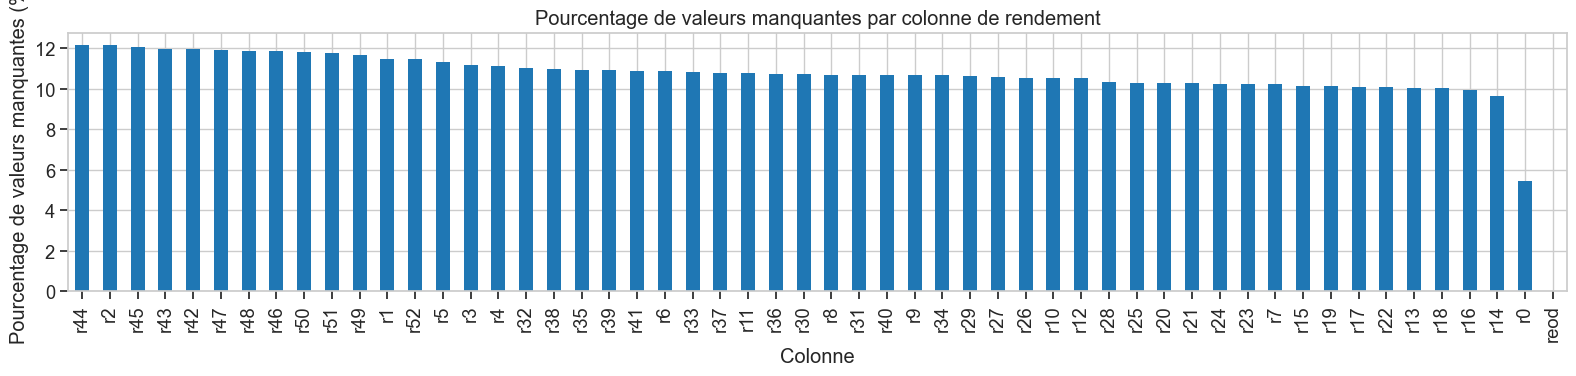

In [ ]:
col_rendements = [col for col in X_train.columns if col.startswith("r")]

# Analyse du nombre de valeurs manquantes par colonne
plt.figure(figsize=(16, 4))

missing_values_count = X_train[col_rendements].isna().sum()
missing_values_percent = (missing_values_count / len(X_train)) * 100
missing_df = pd.DataFrame({
    'Nombre de NaN': missing_values_count,
    'Pourcentage (%)': missing_values_percent
}).sort_values('Nombre de NaN', ascending=False)

ax = missing_df['Pourcentage (%)'].plot.bar()
plt.title('Pourcentage de valeurs manquantes par colonne de rendement')
plt.ylabel('Pourcentage de valeurs manquantes (%)')
plt.xlabel('Colonne')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

On observe que la majorité des colonnes contiennent en moyenne 10% de NaN. Le plus probable est que ce soit lié à des lignes majoritairement composées de NaN, probablement lié à une erreur lors de l'extraction des données. 

Nombre de lignes totales du dataset: 843299
Nombre de lignes contenant au moins un NaN: 242363, soit 28.74%
Nombre de lignes avec plus de 30% de NaN: 121123, soit 14.36%
Nombre de lignes avec plus de 50% de NaN: 77034, soit 9.13%


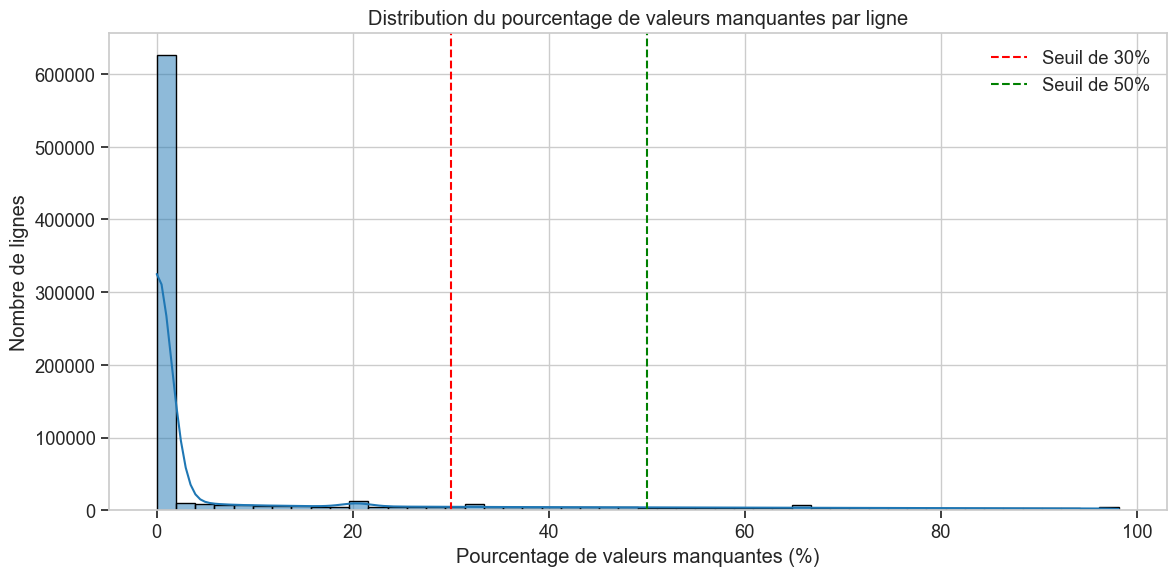

In [ ]:
# Analyse du nombre de valeurs manquantes par ligne
NaN_analysis = pd.DataFrame(index=X_train.index, columns=["NaN_count", "NaN_percent"])
NaN_analysis["NaN_count"] = X_train[col_rendements].isna().sum(axis=1)
nombre_colonnes_rend = len(col_rendements)
NaN_analysis["NaN_percent"] = (NaN_analysis["NaN_count"] / nombre_colonnes_rend) * 100

# Compter le nombre de lignes avec des NaN
nbr_row_na = X_train.isna().any(axis=1).sum()

print(f"Nombre de lignes totales du dataset: {len(X_train)}")
print(f"Nombre de lignes contenant au moins un NaN: {nbr_row_na}, soit {(nbr_row_na/len(X_train)*100):.2f}%")
print(f"Nombre de lignes avec plus de 30% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>30])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>30])/len(X_train)*100:.2f}%")
print(f"Nombre de lignes avec plus de 50% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>50])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>50])/len(X_train)*100:.2f}%")

# Visualisation de la distribution du pourcentage de NaN par ligne
plt.figure(figsize=(12, 6))
sns.histplot(NaN_analysis["NaN_percent"], bins=50, kde=True)
plt.title('Distribution du pourcentage de valeurs manquantes par ligne')
plt.xlabel('Pourcentage de valeurs manquantes (%)')
plt.ylabel('Nombre de lignes')
plt.axvline(x=30, color='r', linestyle='--', label='Seuil de 30%')
plt.axvline(x=50, color='g', linestyle='--', label='Seuil de 50%')
plt.legend()
plt.tight_layout()
plt.show()

On décide arbitrairement de retirer l'ensemble des lignes qui contiennent 30% de NaN (dans les colonnes rendements, donc day, equity, ID sont exclus) afin d'avoir un dataset potentiellement plus propre.

Fast Forward : Cette décision est également motivée par la répartition des classes "reod", composée majoritairement de 0 (environ 41%). On peut intellectualiser cela par le fait que les problèmes de données viennent des exchanges ou du marché résultant dans un marché peu mouvementé. On aurait donc un lien entre l'absence de mouvement dans les marchés et le problème de récupération des données. Potentiellement une fermeture de marché

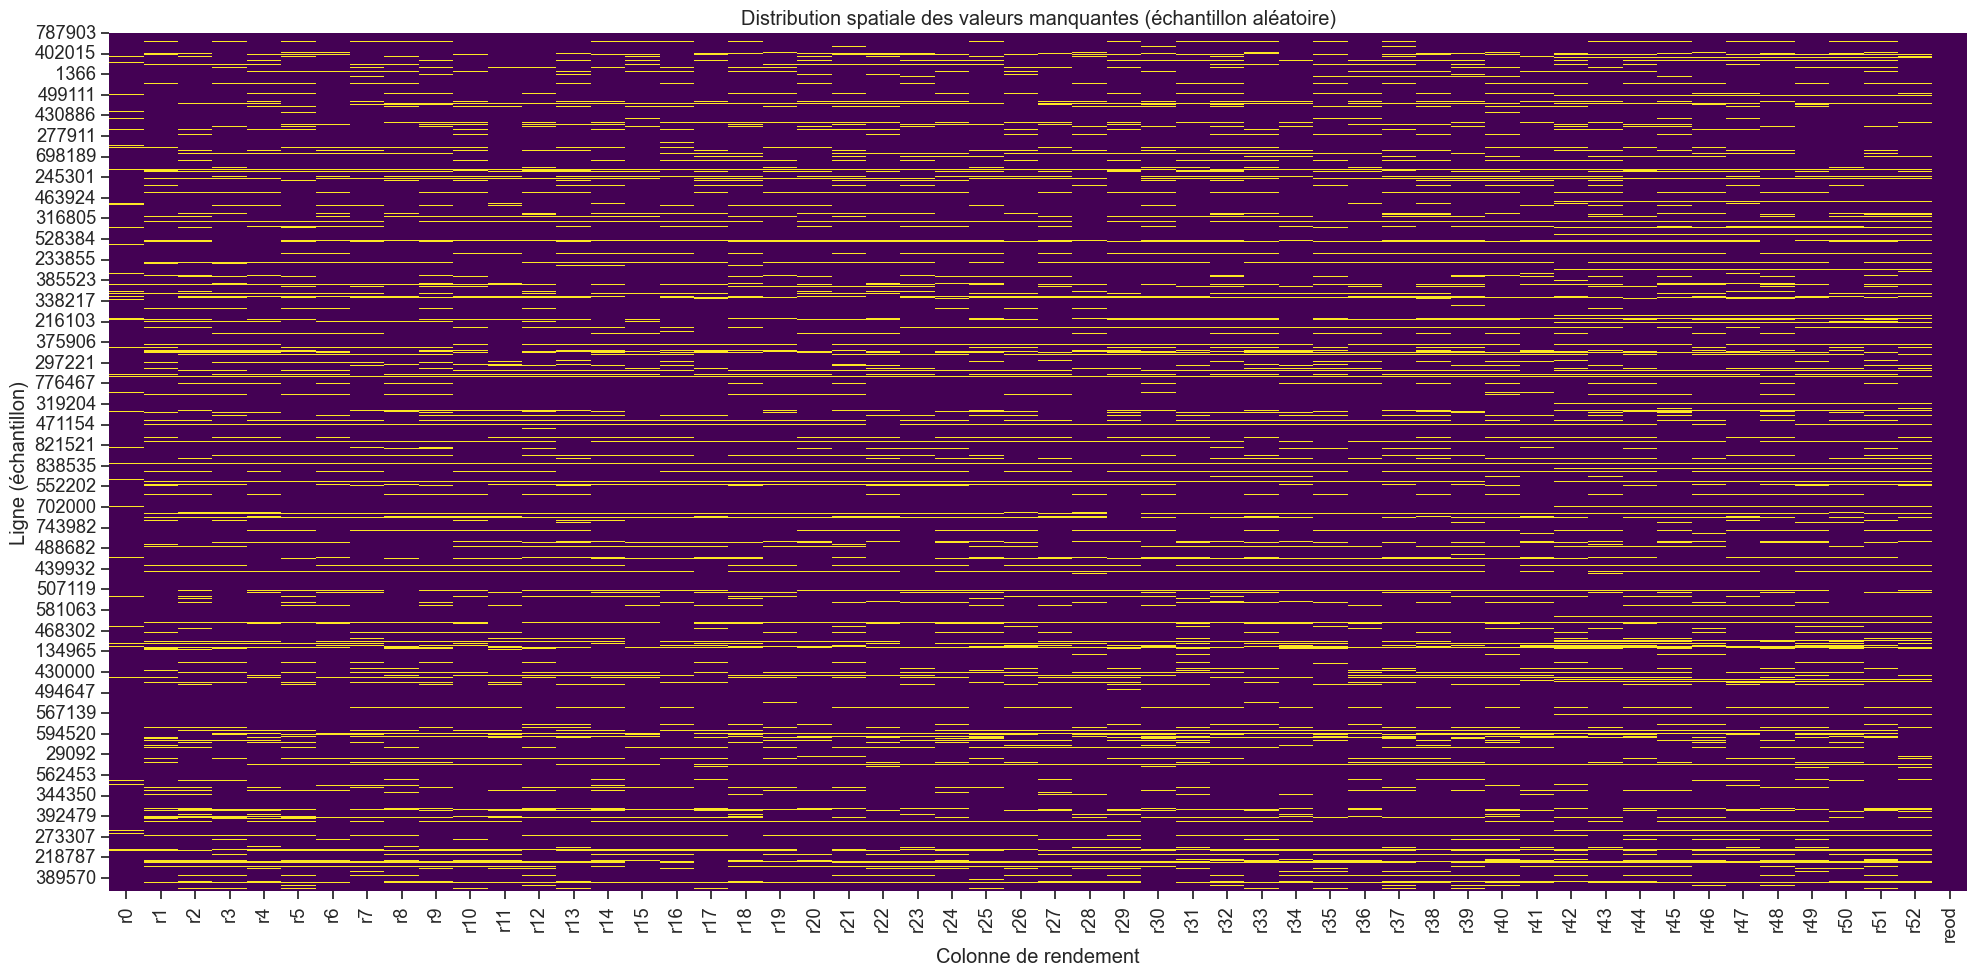

In [ ]:
# Distribution spatiale des NaN (heatmap)
plt.figure(figsize=(20, 10))
sample_size = min(1000, len(X_train))  # Limiter à 1000 lignes pour la lisibilité
sample_indices = np.random.choice(range(len(X_train)), sample_size, replace=False)
sample_data = X_train.iloc[sample_indices][col_rendements].isna()
sns.heatmap(sample_data, cbar=False, cmap='viridis')
plt.title('Distribution spatiale des valeurs manquantes (échantillon aléatoire)')
plt.xlabel('Colonne de rendement')
plt.ylabel('Ligne (échantillon)')
plt.tight_layout()
plt.show()

### 2.2 Distribution des rendements

Analysons la distribution des rendements pour identifier d'éventuelles caractéristiques ou anomalies.

In [ ]:
col_rendements.remove("reod")

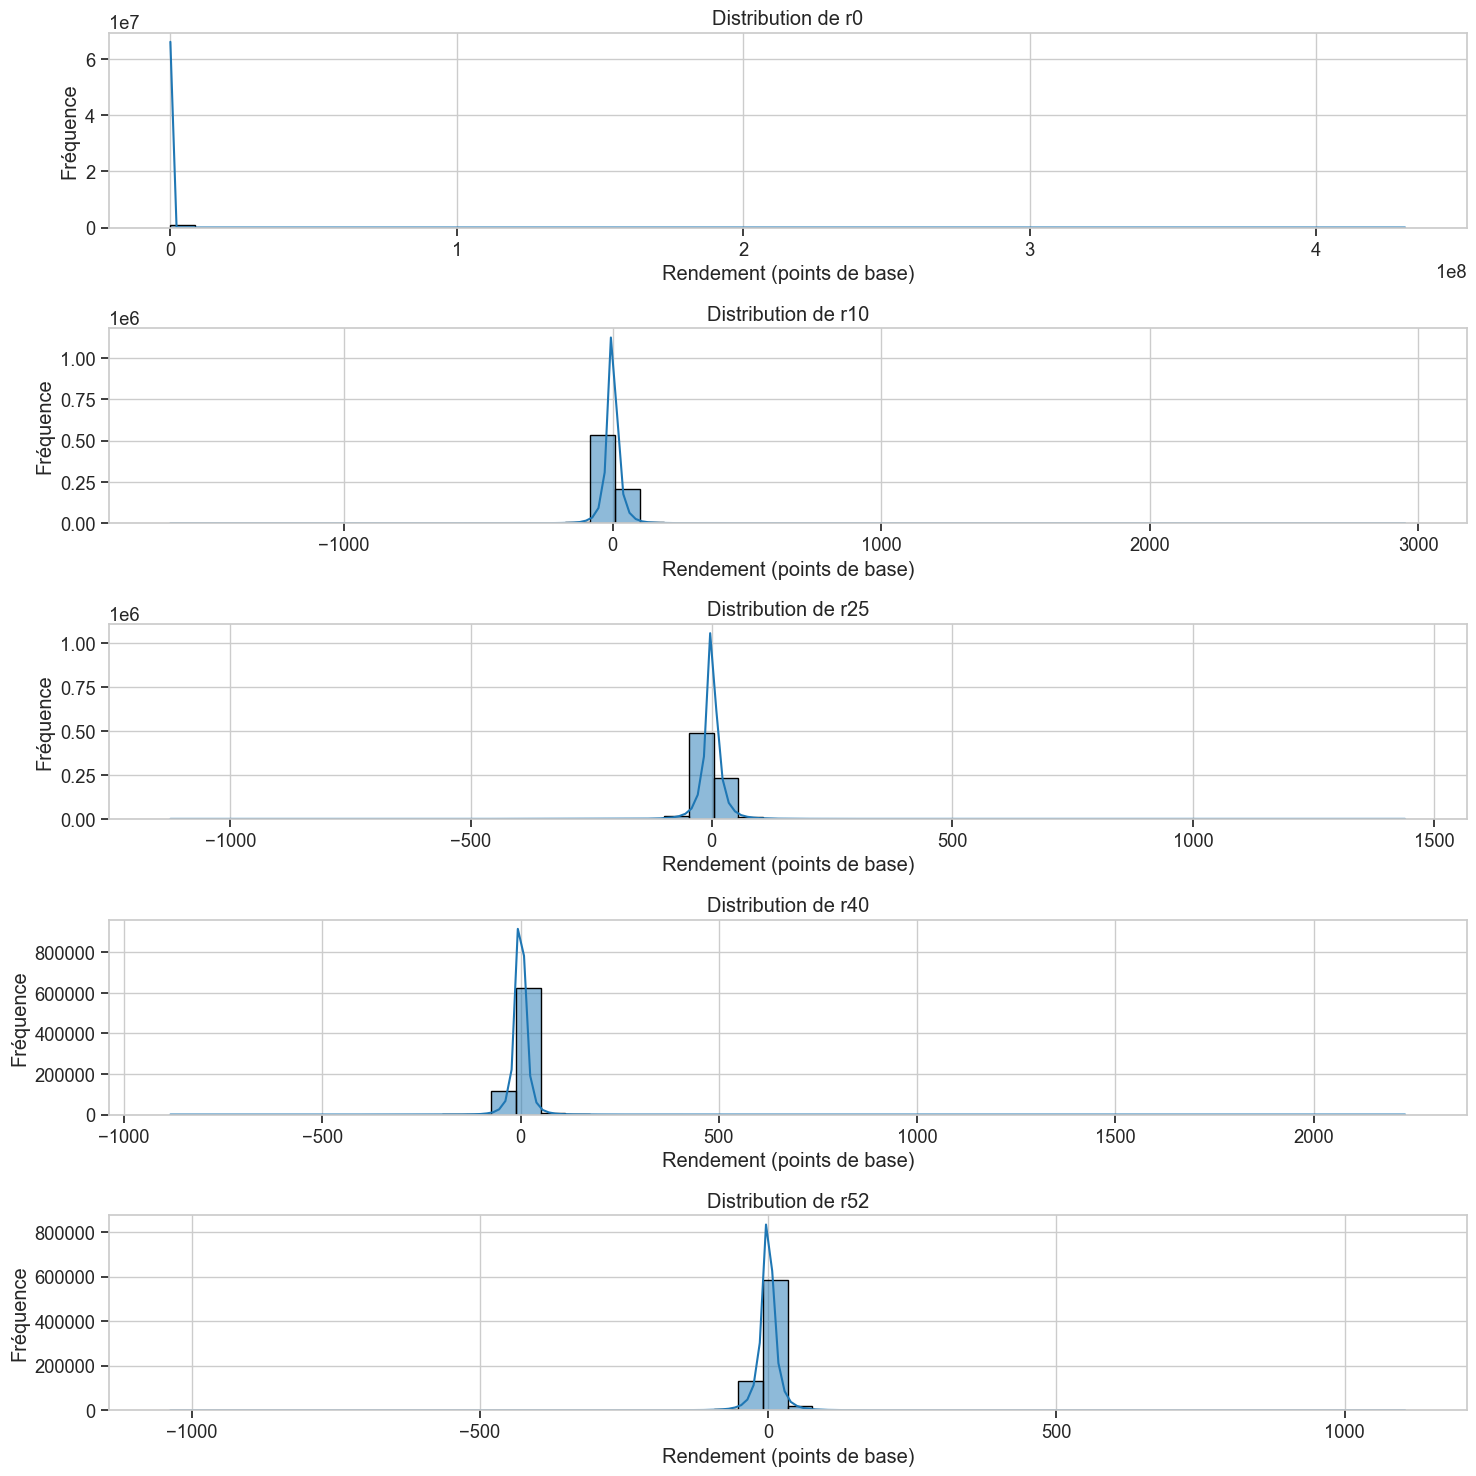

In [ ]:
# Affichage de la distribution pour quelques rendements représentatifs (Les premiers du matin, milieu et les derniers de l'après-midi)
sample_cols = ['r0', 'r1', 'r2', 'r3','r4', 'r5','r6', 'r10', 'r25', 'r40','r50','r51', 'r52']
plt.figure(figsize=(15, 15))

for i, col in enumerate(sample_cols):
    plt.subplot(len(sample_cols), 1, i+1)
    sns.histplot(X_train[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

L'analyse de la distribution des rendements n'est venue qu'assez tard dans notre analyse des données. En effet, avant de se plonger dans la construction des modèles, nous avions un benchmark, le XGBoost. L'objectif était de retrouver dans un premier temps les résultats du benchmark du challenge. Ces tentatives d'amélioration sont passées par de nombreuses de transformations de données, dont certaines imputations que l'on retrouvera plus tard (forward fill, backward fill...) puis l'analyse de la normalité des données. Le StandardScaler() de scikit learn s'effectuant sur les colonnes, il fallait d'abord regarder comment se comportaient certaines colonnes. Nous nous pencherons sur cette analyse dans le focus sur le XGBoost (Partie 5).

Bien que les rendements ne suivent pas une loi normale, de toute évidence, il est important de noter que certains présentent de nombreuses valeurs extrêmes, notamment les rendements en début de journée (de r0 à r3) donc les 20 premières minutes qui présentent une moyenne très élevée et surtout de nombreuses valeurs extrêmes. 

In [ ]:
rendements_stats = X_train[col_rendements].describe().T
rendements_stats['missing_percent'] = X_train[col_rendements].isna().mean() * 100
rendements_stats = rendements_stats.sort_values('max', ascending=False)
rendements_stats.head(10)

count         mean            std      min    25%  50%    75%  \
r0   797476.0  1839.874545  609754.773378 -9967.67 -30.58  0.0  21.34   
r1   746484.0   193.534369  115327.121385 -9973.54 -21.10  0.0  20.71   
r2   740829.0    70.113991   55888.225790 -4823.74 -17.60  0.0  16.51   
r3   749130.0    19.564481   17850.550113 -1949.69 -17.47  0.0  15.17   
r28  756012.0    -0.270700      24.155237 -1219.51  -7.43  0.0   6.91   
r31  753271.0    -0.098791      23.342380 -1131.26  -6.66  0.0   6.54   
r15  757907.0    -0.625162      29.575757 -1290.32 -10.18  0.0   8.68   
r10  754488.0     0.372729      33.535457 -1647.06 -10.15  0.0  10.76   
r7   757167.0    -1.195195      38.327389 -2066.67 -13.76  0.0  11.44   
r9   753369.0     0.405408      34.341933 -1390.42 -10.34  0.0  11.25   

              max  missing_percent  
r0   4.310700e+08         5.433779  
r1   7.516000e+07        11.480507  
r2   4.789000e+07        12.151088  
r3   1.545000e+07        11.166739  
r28  3.217820e+03        10.350659  
r31  3.114750e+03        10.675692  
r15  3.076920e+03        10.125946  
r10  2.951810e+03        10.531377  
r7   2.733810e+03        10.213696  
r9   2.462310e+03        10.664071

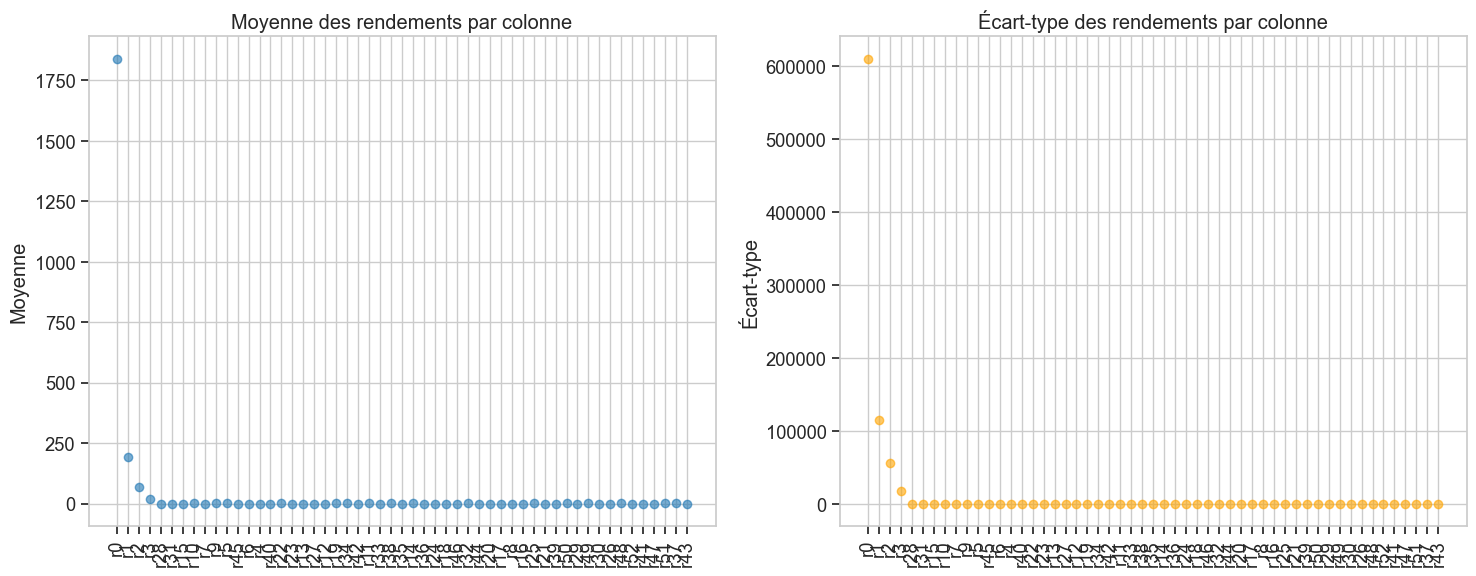

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(rendements_stats.index, rendements_stats['mean'], alpha=0.6)
plt.title('Moyenne des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Moyenne')

plt.subplot(1, 2, 2)
plt.scatter(rendements_stats.index, rendements_stats['std'], alpha=0.6, color='orange')
plt.title('Écart-type des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Écart-type')
plt.tight_layout()
plt.show()

On peut aisément observer la différence des statistiques (moyenne) en début de journée, à l'ouverture des marchés.  

### 2.3 Analyse de la variable cible

Examinons la distribution de notre variable cible `reod` pour vérifier l'équilibre entre les classes.

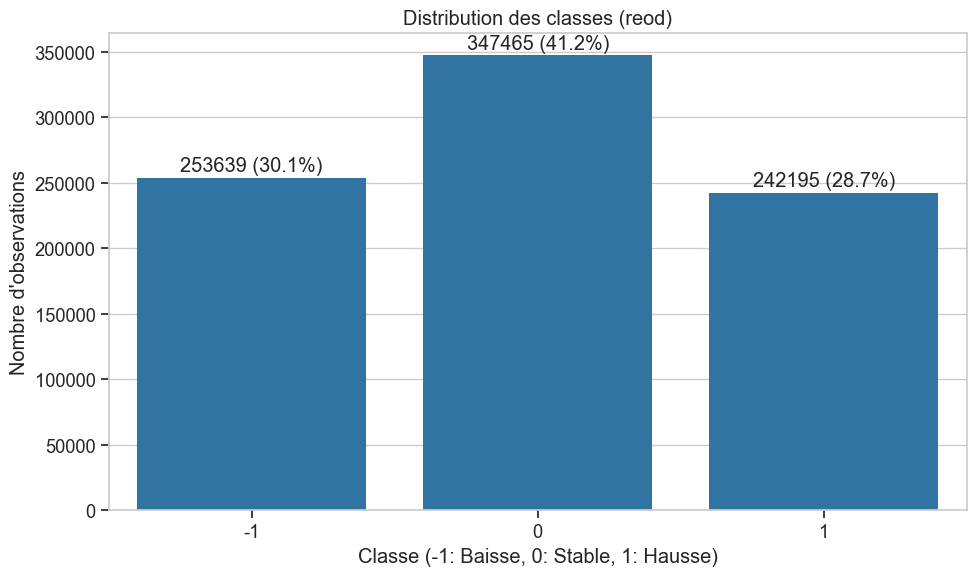

In [ ]:
# Distribution des classes
plt.figure(figsize=(10, 6))

class_counts = X_train['reod'].value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Distribution des classes (reod)')
plt.xlabel('Classe (-1: Baisse, 0: Stable, 1: Hausse)')
plt.ylabel('Nombre d\'observations')

total = len(X_train)
for i, v in enumerate(class_counts):
    ax.text(i, v + 5000, f'{v} ({v/total*100:.1f}%)', ha='center')
    
plt.tight_layout()
plt.show()

Ainsi, dans le jeu de donnée initial, on observe une prépondérance de la classe 0, c'est-à-dire un mouvement "stable" qui pourrait être soit un fait financier soit un problème lié aux données. On verra par la suite que lorsqu'on retire les lignes contenant plus de 30% de NaN, cette prépondérance se résorbe fortement pour avoir une répartition plus équilibrée qui conforte l'idée d'un problème de données. 

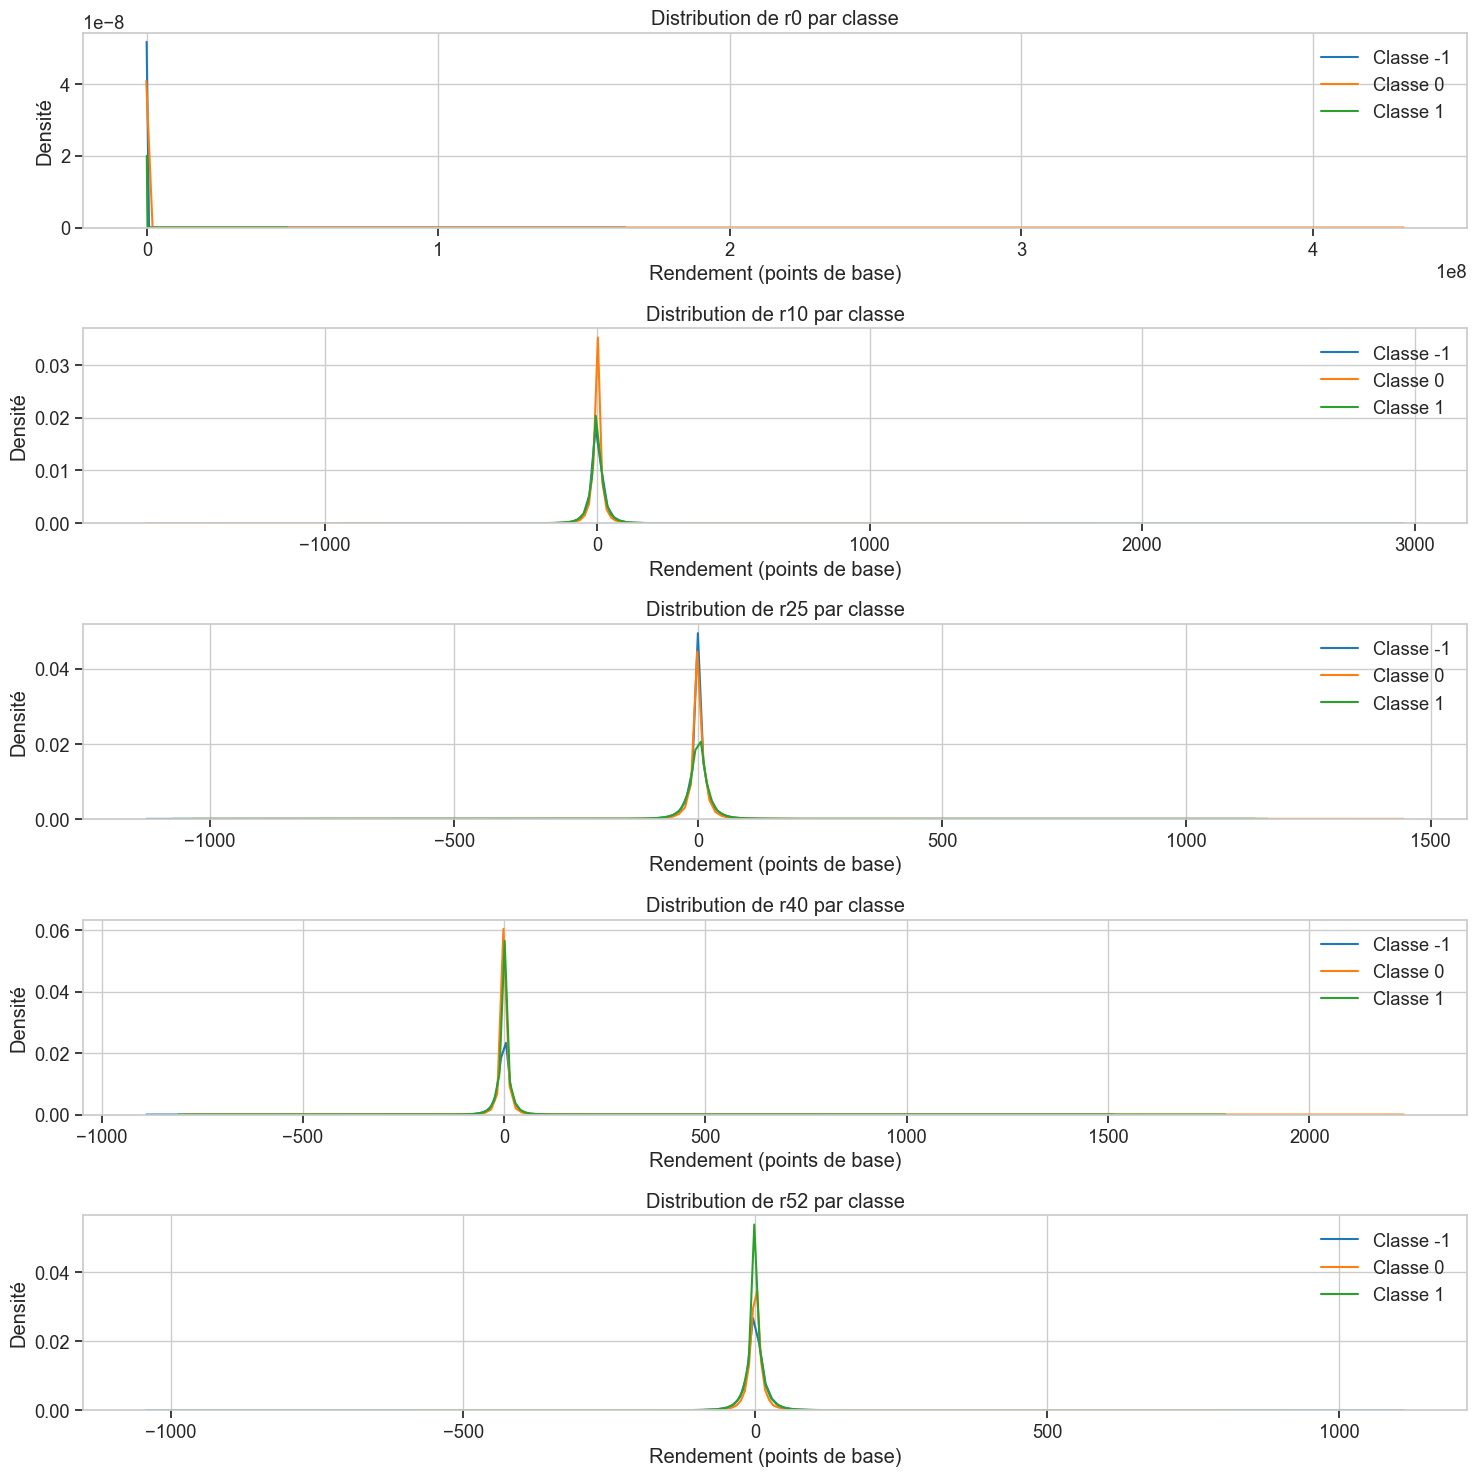

In [ ]:
# Analyse des rendements par classe pour quelques variables représentatives
plt.figure(figsize=(15, 15))

for i, col in enumerate(sample_cols):
    plt.subplot(len(sample_cols), 1, i+1)
    for cls in sorted(X_train['reod'].unique()):
        subset = X_train[X_train['reod'] == cls][col].dropna()
        sns.kdeplot(subset, label=f'Classe {cls}')
    plt.title(f'Distribution de {col} par classe')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Densité')
    plt.legend()
    
plt.tight_layout()
plt.show()

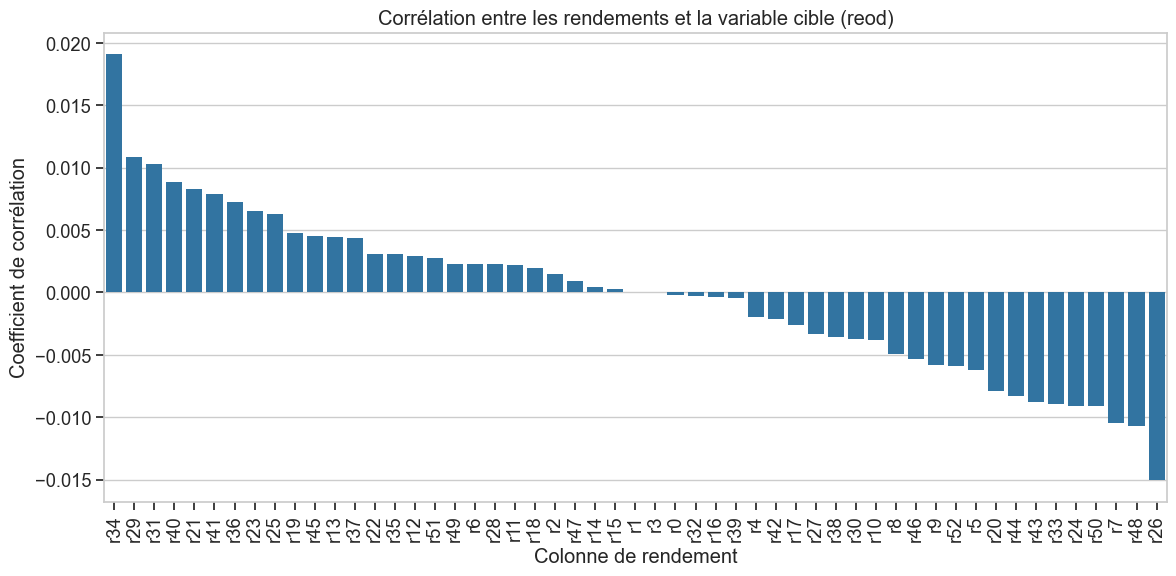

Top 5 des rendements positivement corrélés avec reod:


r34    0.019112
r29    0.010815
r31    0.010292
r40    0.008857
r21    0.008309
Name: reod, dtype: float64


Top 5 des rendements négativement corrélés avec reod:


r24   -0.009070
r50   -0.009138
r7    -0.010481
r48   -0.010694
r26   -0.015045
Name: reod, dtype: float64

In [ ]:
# Corrélation entre les rendements et la variable cible
correlations = X_train[col_rendements + ['reod']].corr()['reod'].drop('reod').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Corrélation entre les rendements et la variable cible (reod)')
plt.xticks(rotation=90)
plt.xlabel('Colonne de rendement')
plt.ylabel('Coefficient de corrélation')
plt.tight_layout()
plt.show()

print("Top 5 des rendements positivement corrélés avec reod:")
display(correlations.head())

print("\nTop 5 des rendements négativement corrélés avec reod:")
display(correlations.tail())

Nous observons que les coefficients de corrélation sont globalement faibles, oscillant entre 0,019 et -0,015 environ. Ces valeurs très modestes indiquent qu'aucun rendement individuel n'explique fortement à lui seul la direction future du prix, ce qui confirme la complexité intrinsèque de la prédiction des mouvements de marché.

Il est également notable que la force des corrélations décroît de manière relativement ordonnée des deux côtés (positif et négatif), sans sauts brusques ni valeurs aberrantes, ce qui suggère une structure sous-jacente cohérente dans les données.

Ces observations justifient notre approche multivariée et l'utilisation de modèles capables de capturer des relations complexes, puisque les corrélations linéaires simples sont manifestement insuffisantes pour prédire efficacement les mouvements futurs. Les algorithmes comme XGBoost ou les approches ensemblistes seront particulièrement adaptés pour exploiter ces structures subtiles et potentiellement non-linéaires.

## 3. Stratégies d'imputation

Face au défi des valeurs manquantes, nous testons plusieurs stratégies d'imputation pour compléter les données. Ces données ont été générée en amont dans le fichier : KNN_data.ipynb pour des raisons pratiques et de présentation.

- 1 :  Forward-fill puis backward-fill (FFBF)

Cette stratégie propage d'abord les dernières valeurs connues vers l'avant, puis remplit les valeurs restantes en propageant depuis la fin. C'est supposément la méthode d'imputation classique pour ce genre de cas avec l'interpolation linéaire.

- 2 : Backward-fill puis forward-fill (BFFF)

Cette stratégie inverse commence par propager depuis la fin, puis remplit les valeurs restantes en propageant depuis le début. Cette méthode peut introduire un biais de looking forward mais dans les faits, on remarquera que la différence est très faible avec le FFBF.

- 3 : Interpolation linéaire

Cette méthode crée une ligne droite entre les valeurs connues pour estimer les valeurs manquantes.

- 4 : Imputation par K plus proches voisins (KNN)

Cette méthode utilise les K observations les plus similaires pour estimer les valeurs manquantes.

- 5 : MICE (Multiple Imputation by Chained Equations) est une méthode itérative qui modélise chaque variable contenant des valeurs manquantes en fonction des autres variables du jeu de données, en répétant ce processus plusieurs fois pour affiner les imputations et générer des estimations cohérentes et réalistes.

Chacune de ces méthodes est appliquée en première. Ensuite, pour chacune, nous appliquons un forward puis un backward fill s'il reste des NaN. L'ensemble de ces fonctions peuvent être trouvées dans data_preprocessing.py. 


Egalement, l'ensemble des données, chemin d'accès à ces données sont dans une variable globale DATASETS dans data_registry 

### 3.1 Chargement des datasets avec les différentes stratégies d'imputation. 

In [ ]:
print("\n--- Chargement des datasets avec différentes stratégies d'imputation ---")
imputed_datasets = load_datasets()


--- Chargement des datasets avec différentes stratégies d'imputation ---

Chargement du dataset raw...
Temps de chargement: 9.95 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 969666, test: 512130

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset ffbf...
Temps de chargement: 10.29 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 0, test: 0

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset bfff...
Temps de chargement: 7.21 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 0, test: 0

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset interp...
Temps de chargement: 7.17 secondes
Dimensions train: (730784, 57), 

In [ ]:
print("\n--- Création d'un dataset avec moins de 30% de valeurs manquantes ---")

# Charger les données brutes pour appliquer le filtrage
X_train_70 = pd.read_csv(r"processed_data\X_train_70.csv")
X_test_70 = pd.read_csv(r"processed_data\X_test_70.csv")

# Créer un dataset filtré (<30% NaN) avec imputation à zéro
X_train_low_nan, X_test_low_nan = create_low_nan_dataset(X_train_70, X_test_70, threshold=0.3)

# Enregistrer les datasets pour pouvoir les utiliser avec run_experiment
X_train_low_nan.to_csv("processed_data/X_train_low_nan.csv", index=False)
X_test_low_nan.to_csv("processed_data/X_test_low_nan.csv", index=False)

# Ajouter au registre des datasets
from utils.data_registry import add_dataset_with_features
add_dataset_with_features("low_nan", 
                        "processed_data/X_train_low_nan.csv", 
                        "processed_data/X_test_low_nan.csv", 
                        "Colonnes avec <30% de NaN, imputation à 0")


--- Création d'un dataset avec moins de 30% de valeurs manquantes ---
Nombre de colonnes de rendement conservées: 53 sur 53
Dimensions du dataset filtré: (730784, 57)


True

### 3.2  Analyse des distribution en fonction des imputations


--- Analyse des distributions après imputation ---


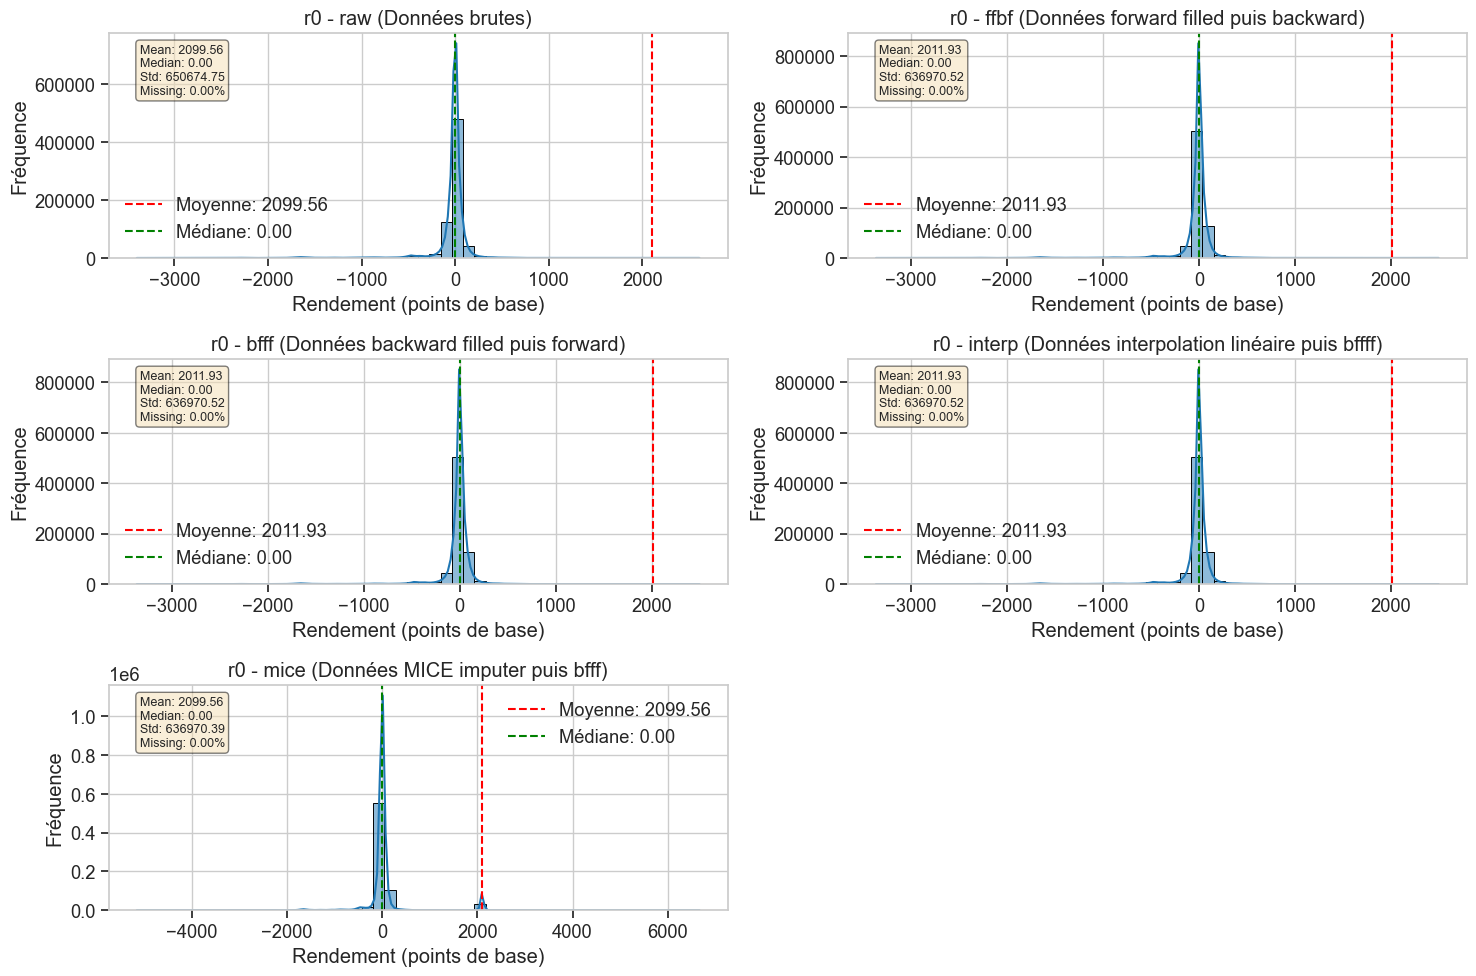

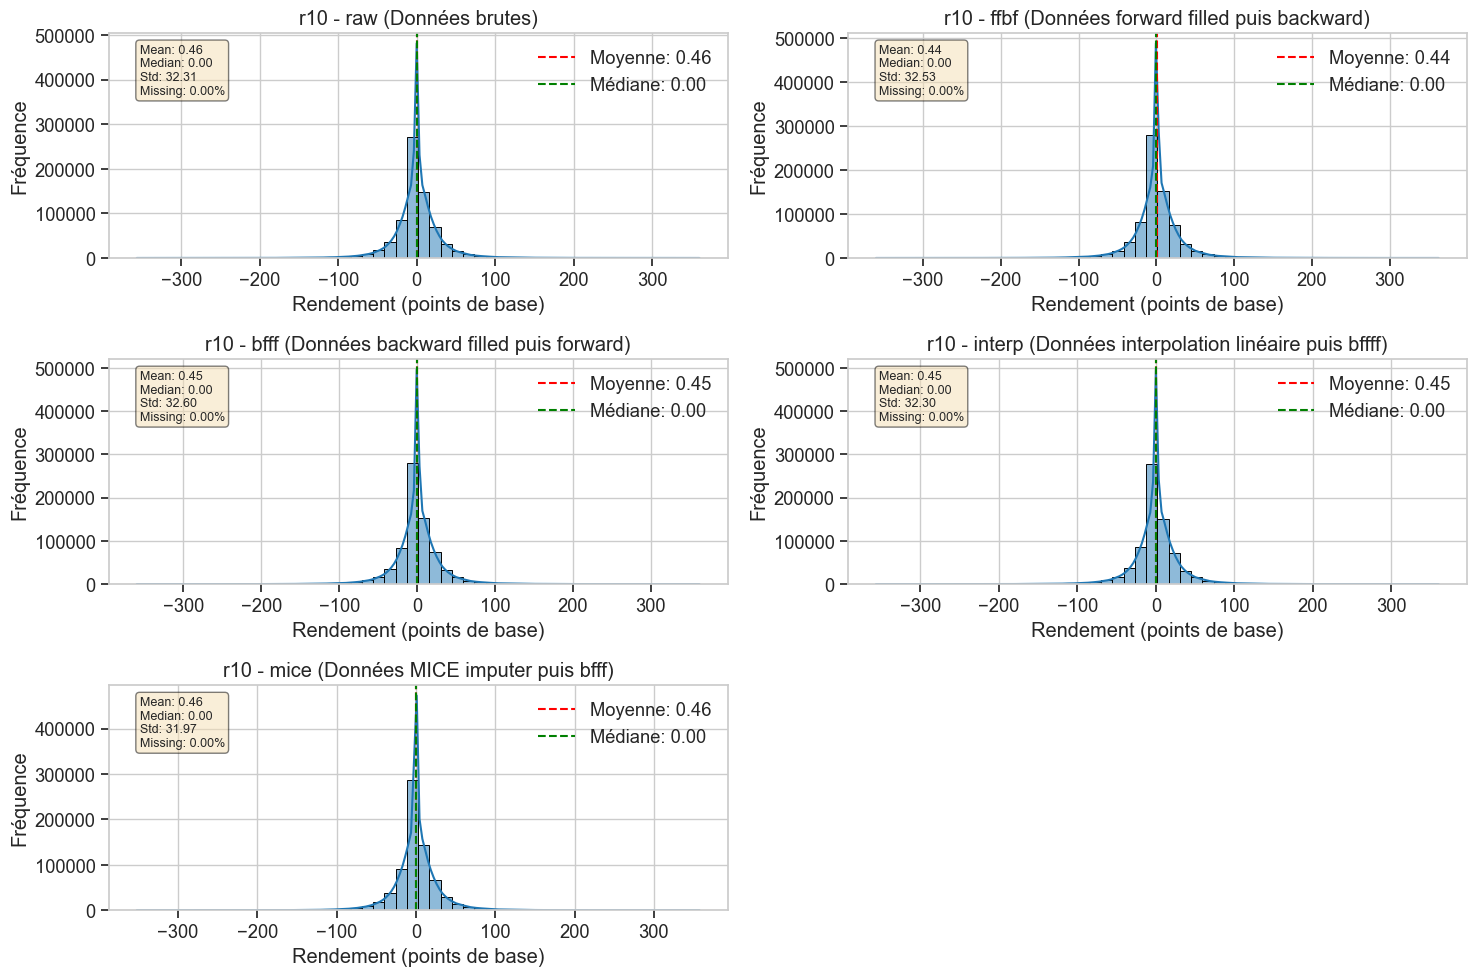

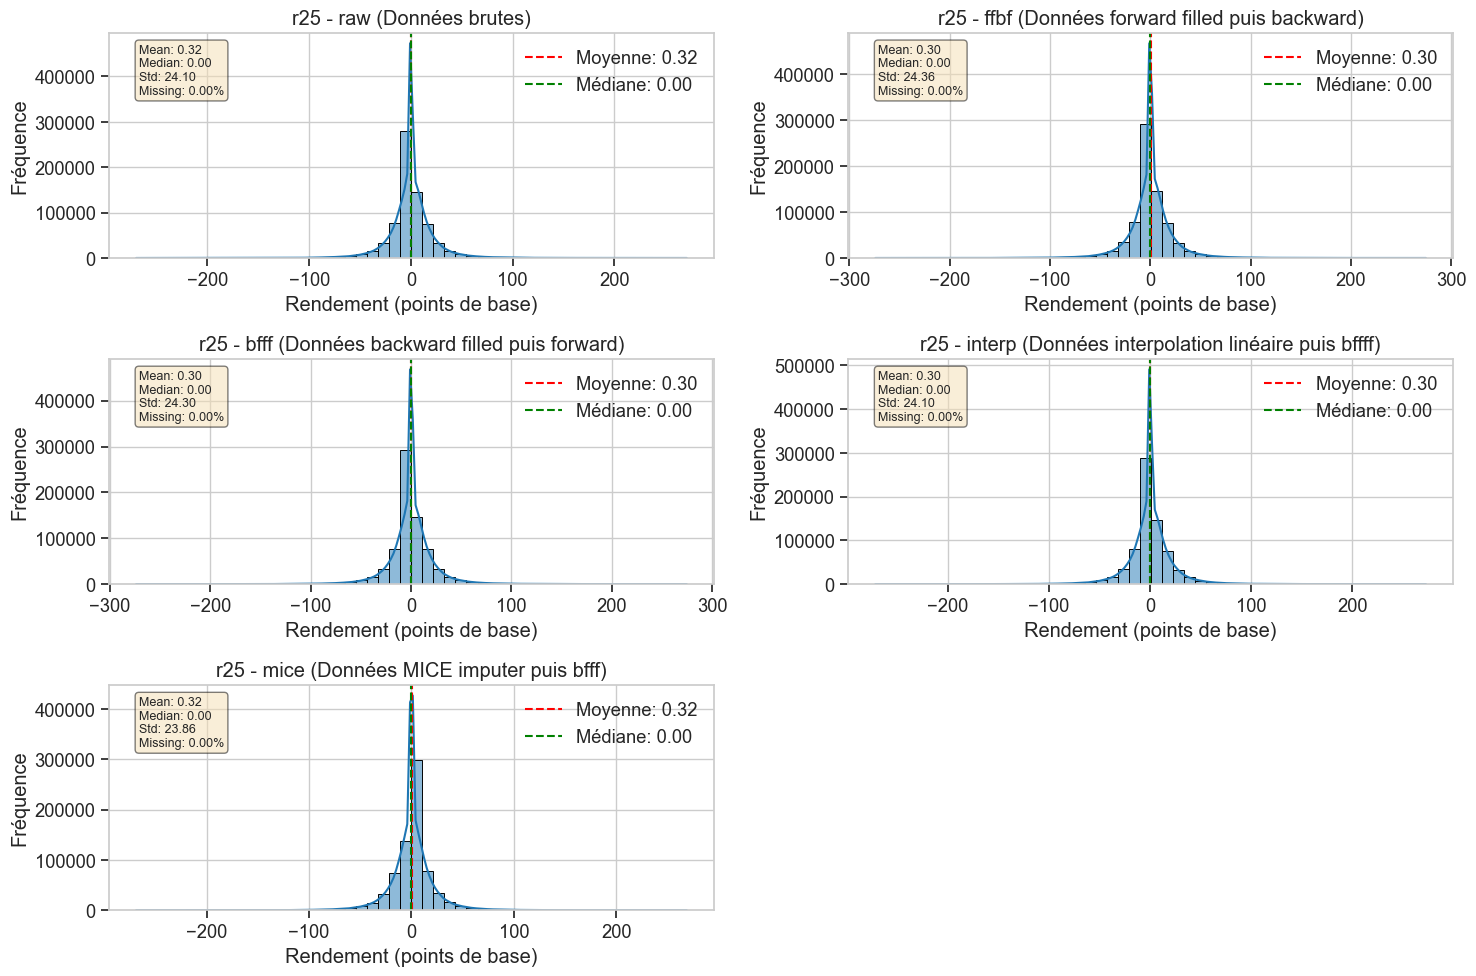

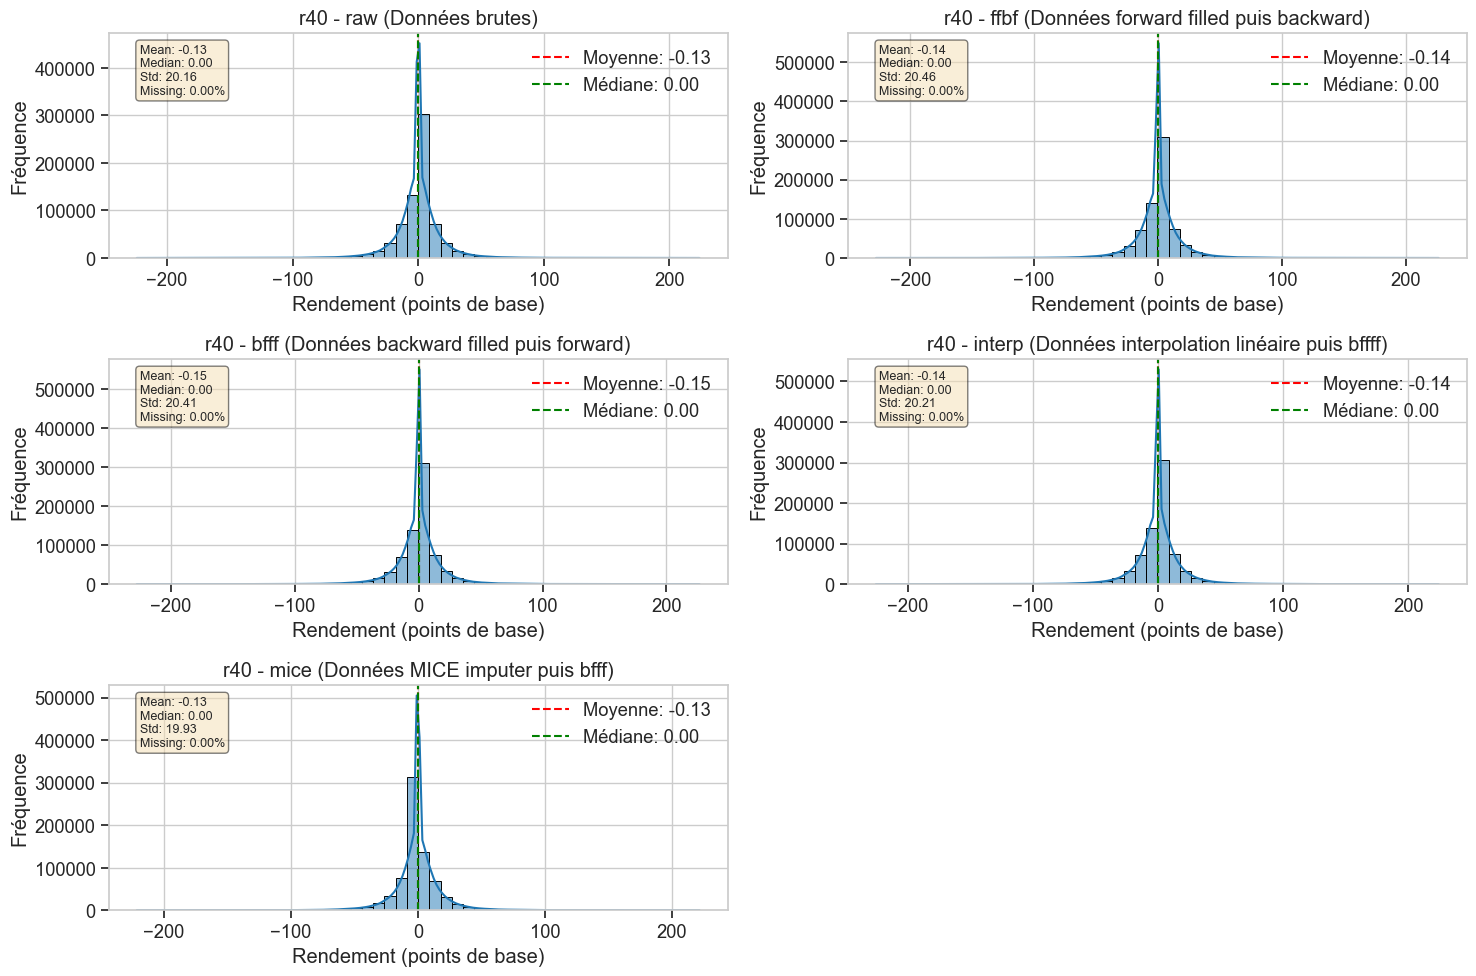

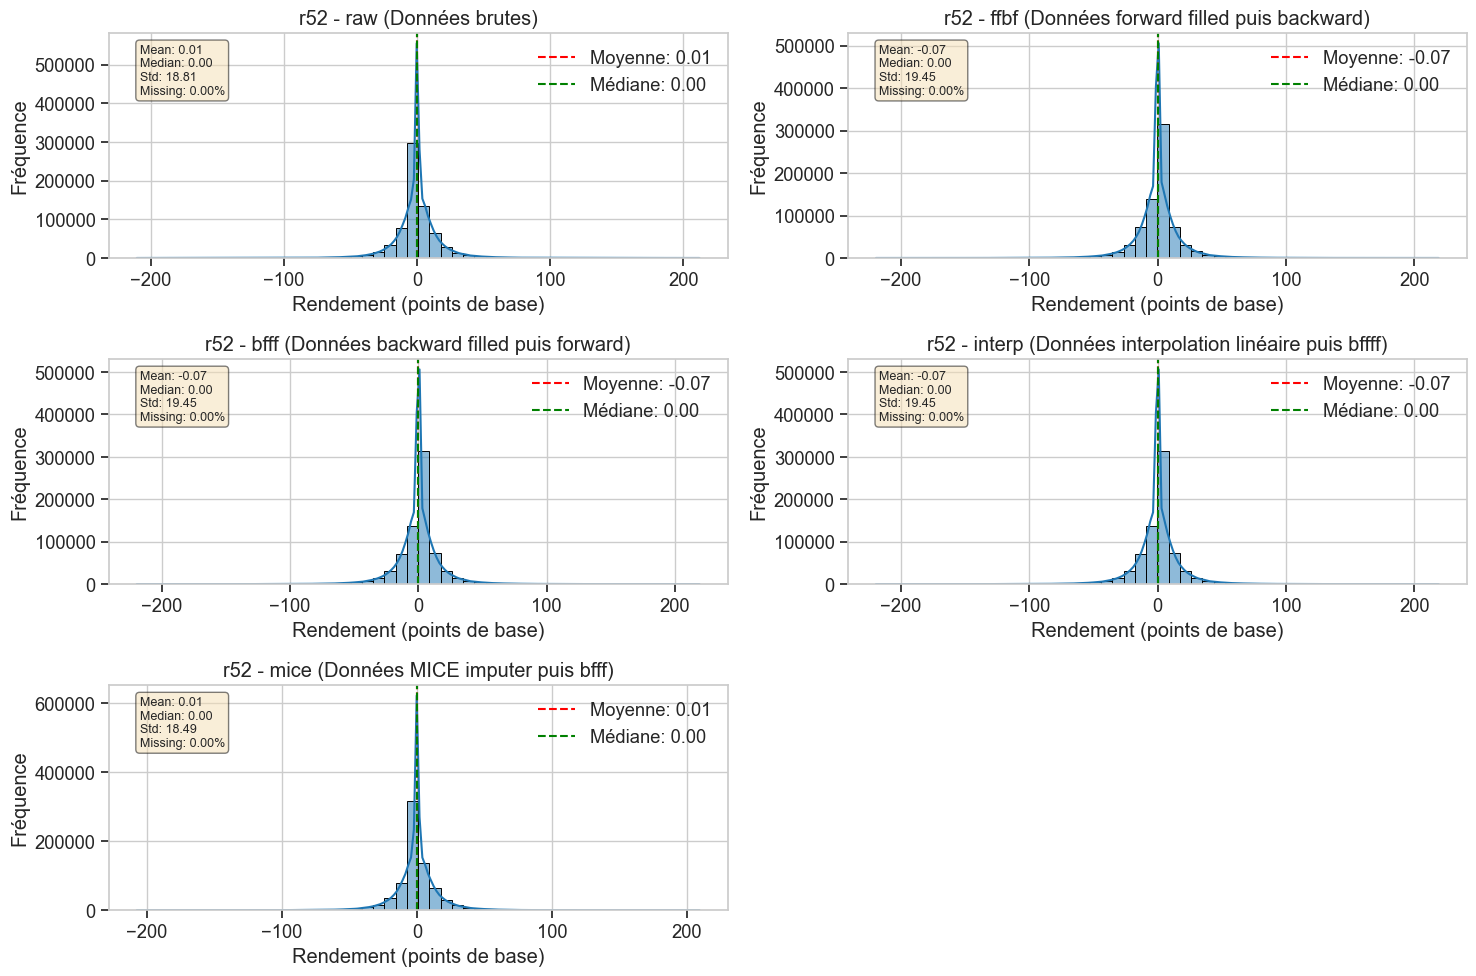

In [ ]:
print("\n--- Analyse des distributions après imputation ---")
analyze_distributions(imputed_datasets)

Les rendements suivent environ la même distribution, même les premiers rendements, cependant, on observe largement des queues de distributions plus longues impliquant des valeurs extrêmes. On essaiera de rectifier cela en essaynt plusieurs scaler par colonnes et en faisant également une normalisation par ligne. Cela permettra d'une certaine manière de modifier la distribution. Ne connaissant pas l'impact que cela puisse avoir, nous avons testés chaque cas. Les résultats étaient soient négligeables en fonction de scaler (Standard, MinMax, Quantile...) soit positifs pour la normalisation par ligne (légère amélioration pour les XGBoost) mais négligeable.

### 3.3 Comparaison des statistiques (moyenne / écart-type) par colonne et stratégie


--- Comparaison des statistiques entre les stratégies d'imputation ---


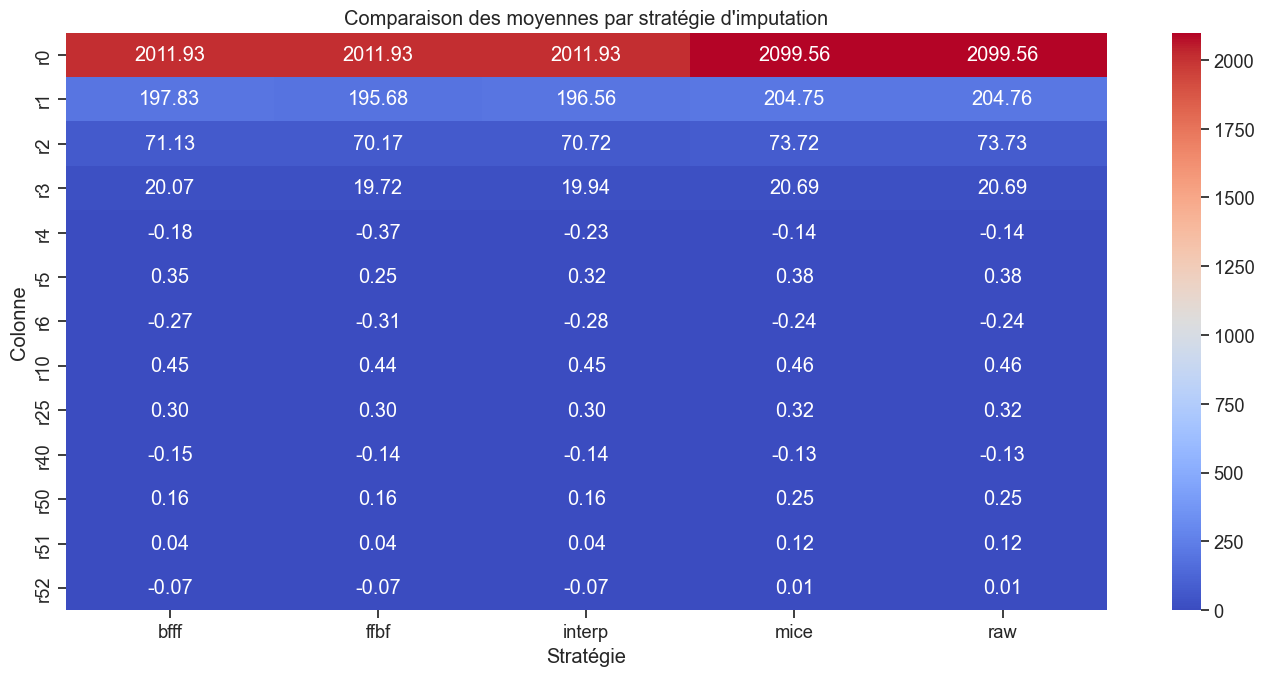

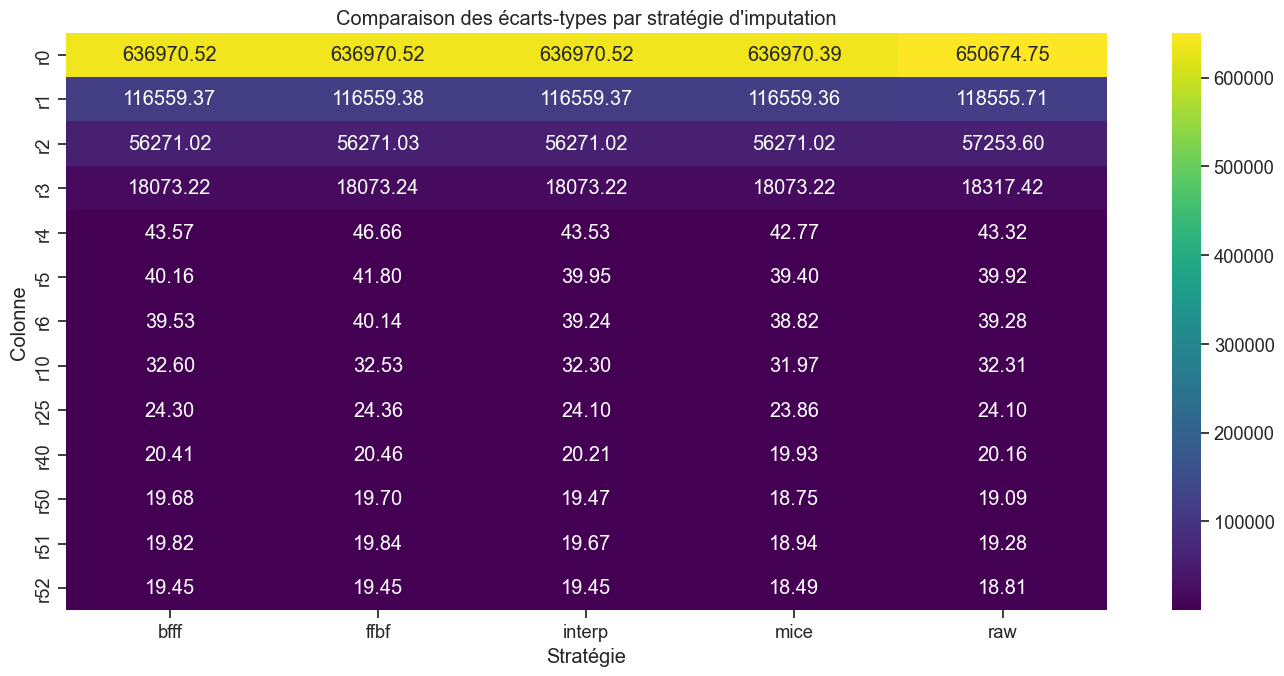

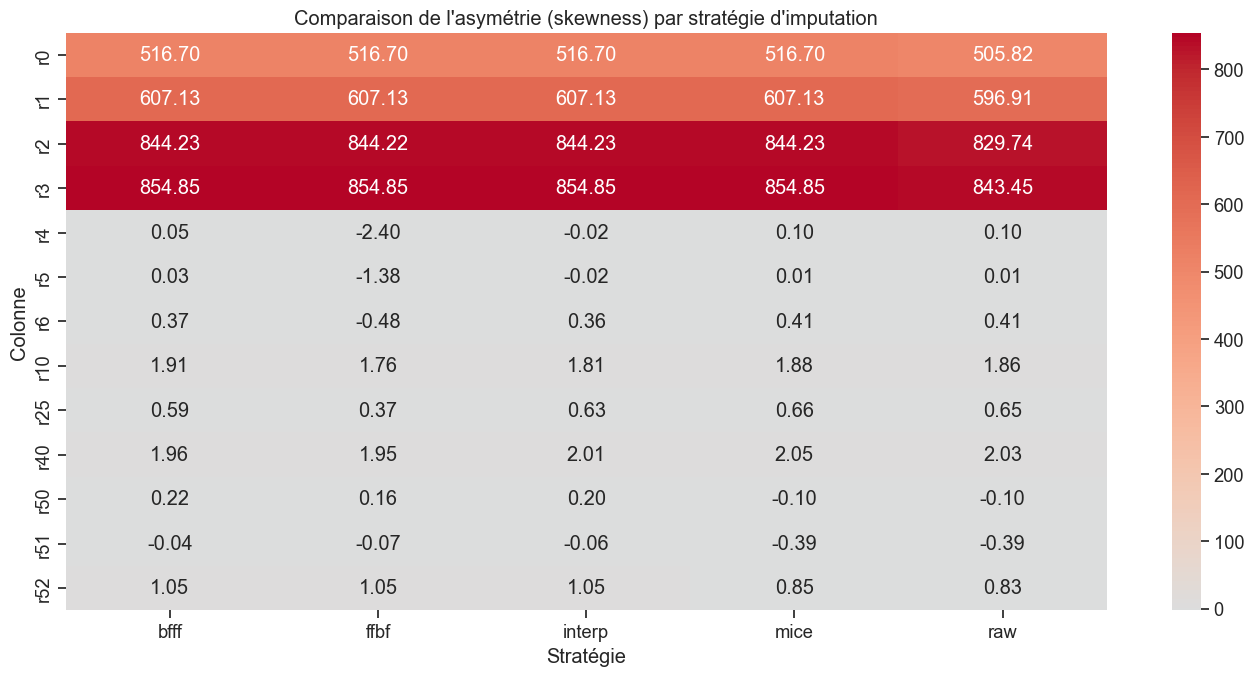

In [ ]:
print("\n--- Comparaison des statistiques entre les stratégies d'imputation ---")
stats_results = compare_column_stats(imputed_datasets)

Encore une fois, on observe que les statistiques principales pour les premiers rendements sont démesurement plus grands par rapport au reste. 

### 3.4 Impact des méthodes de normalisation


--- Impact des différentes méthodes de normalisation ---


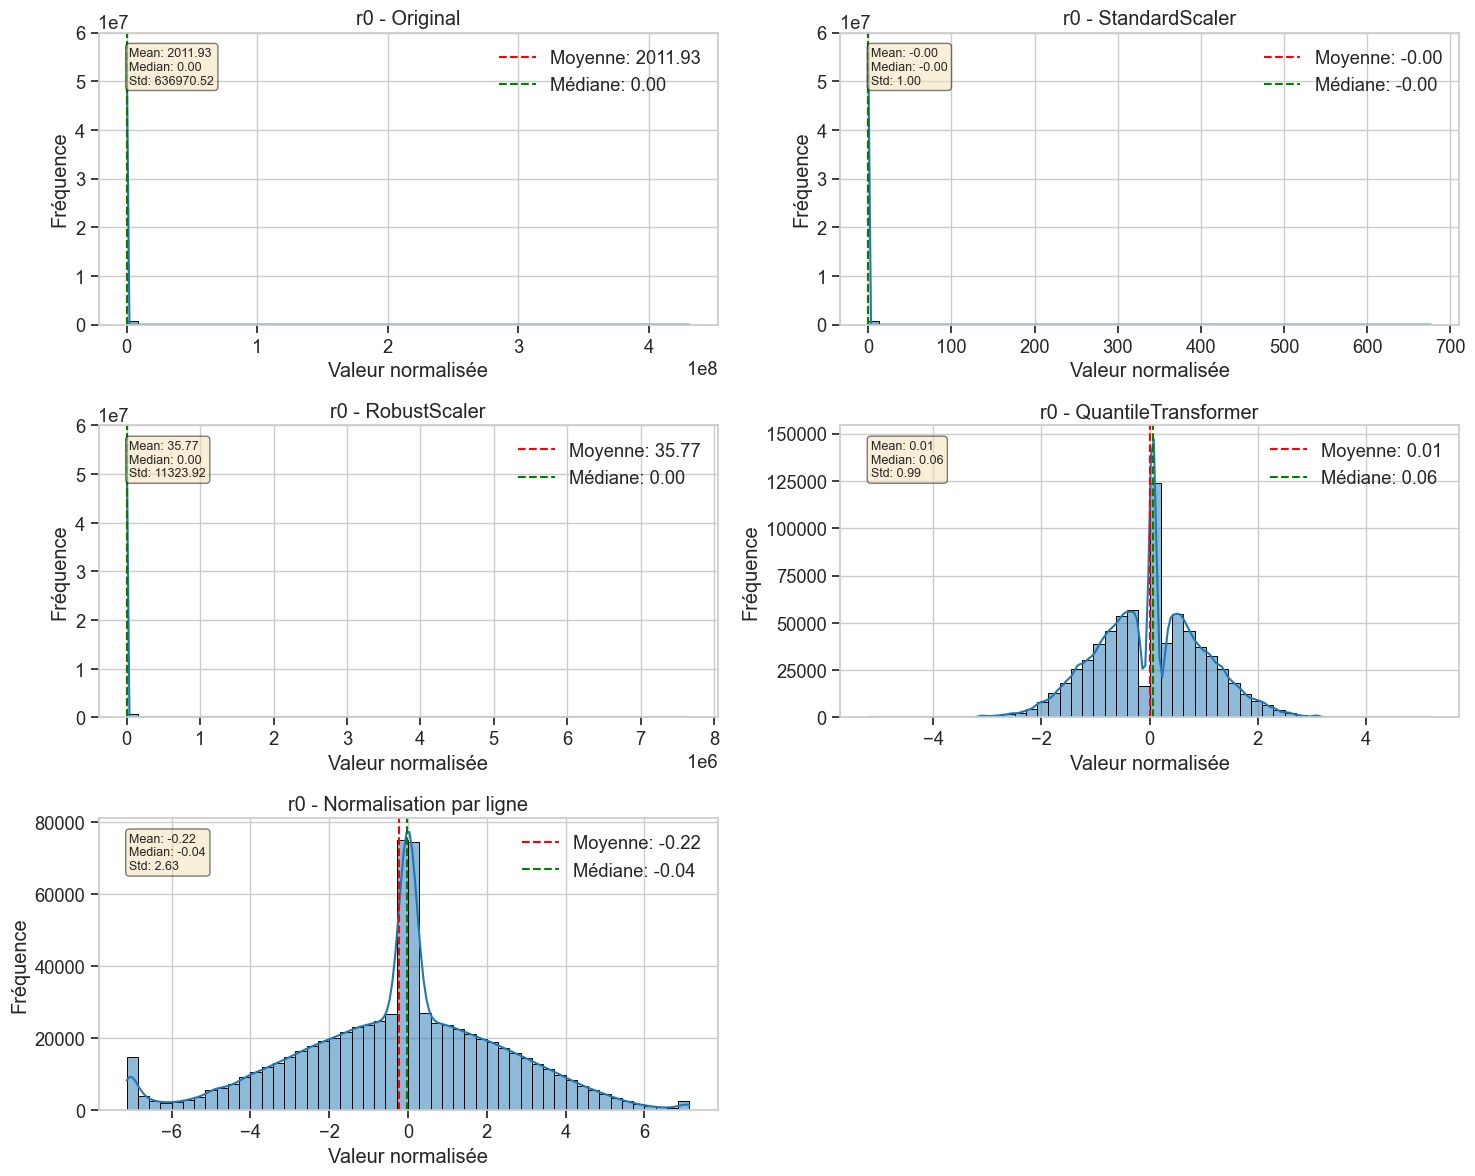

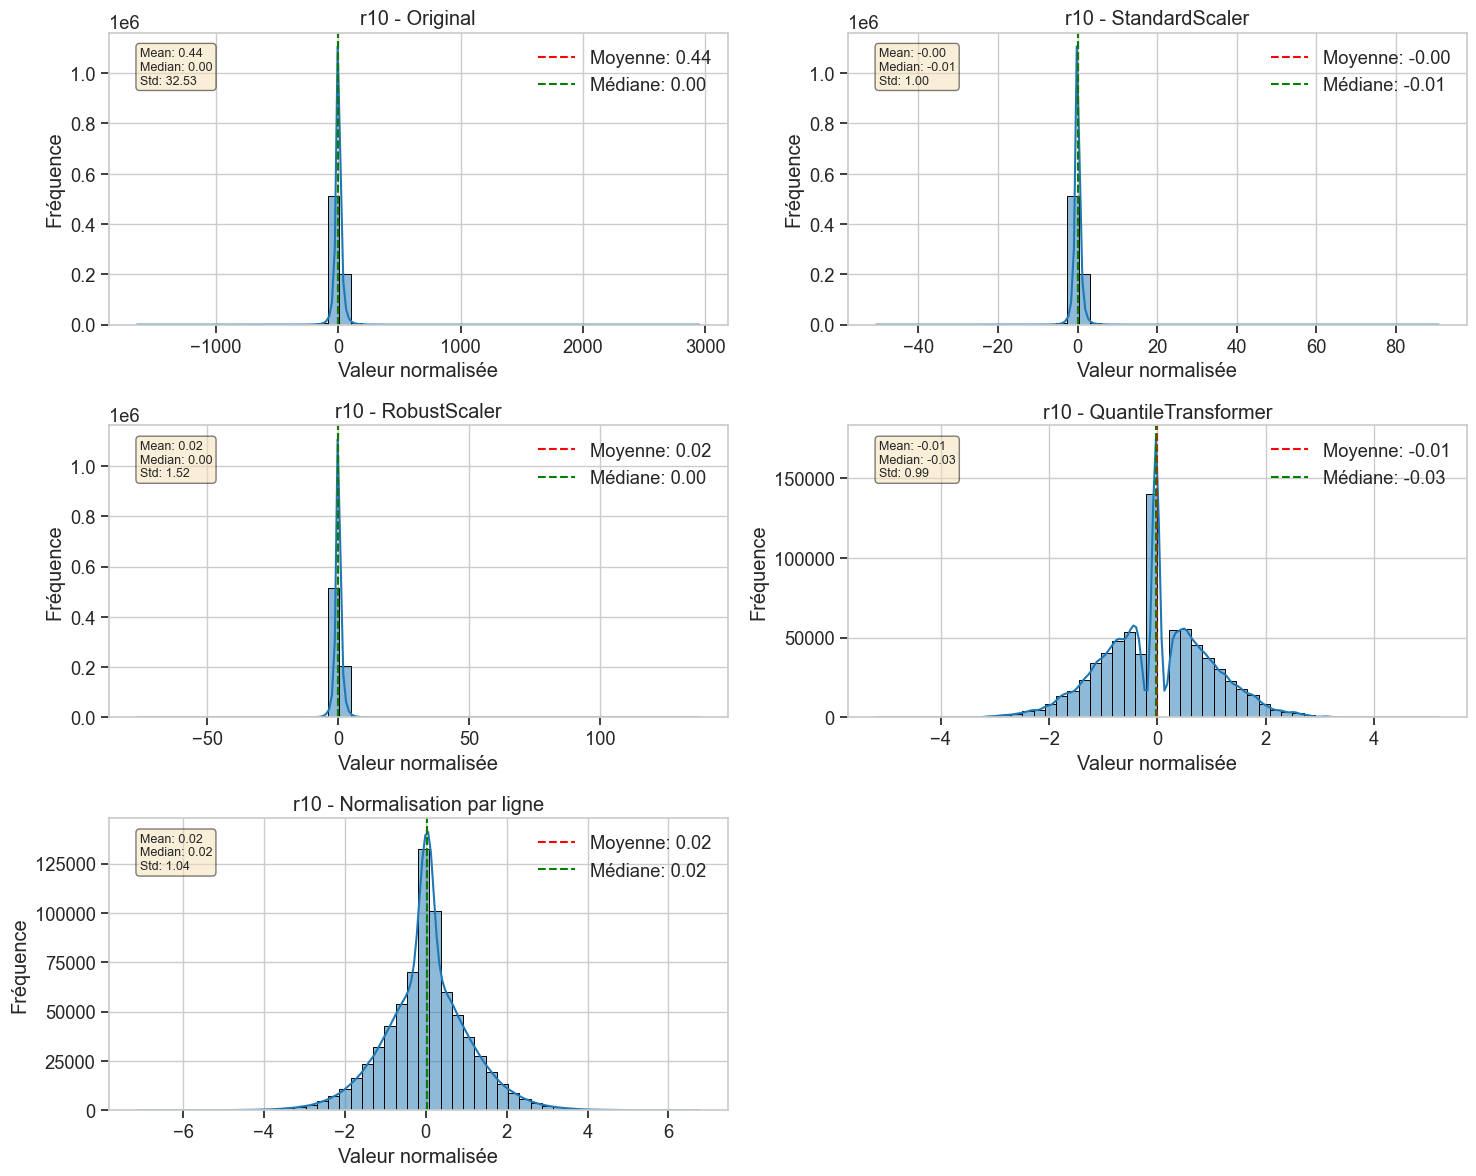

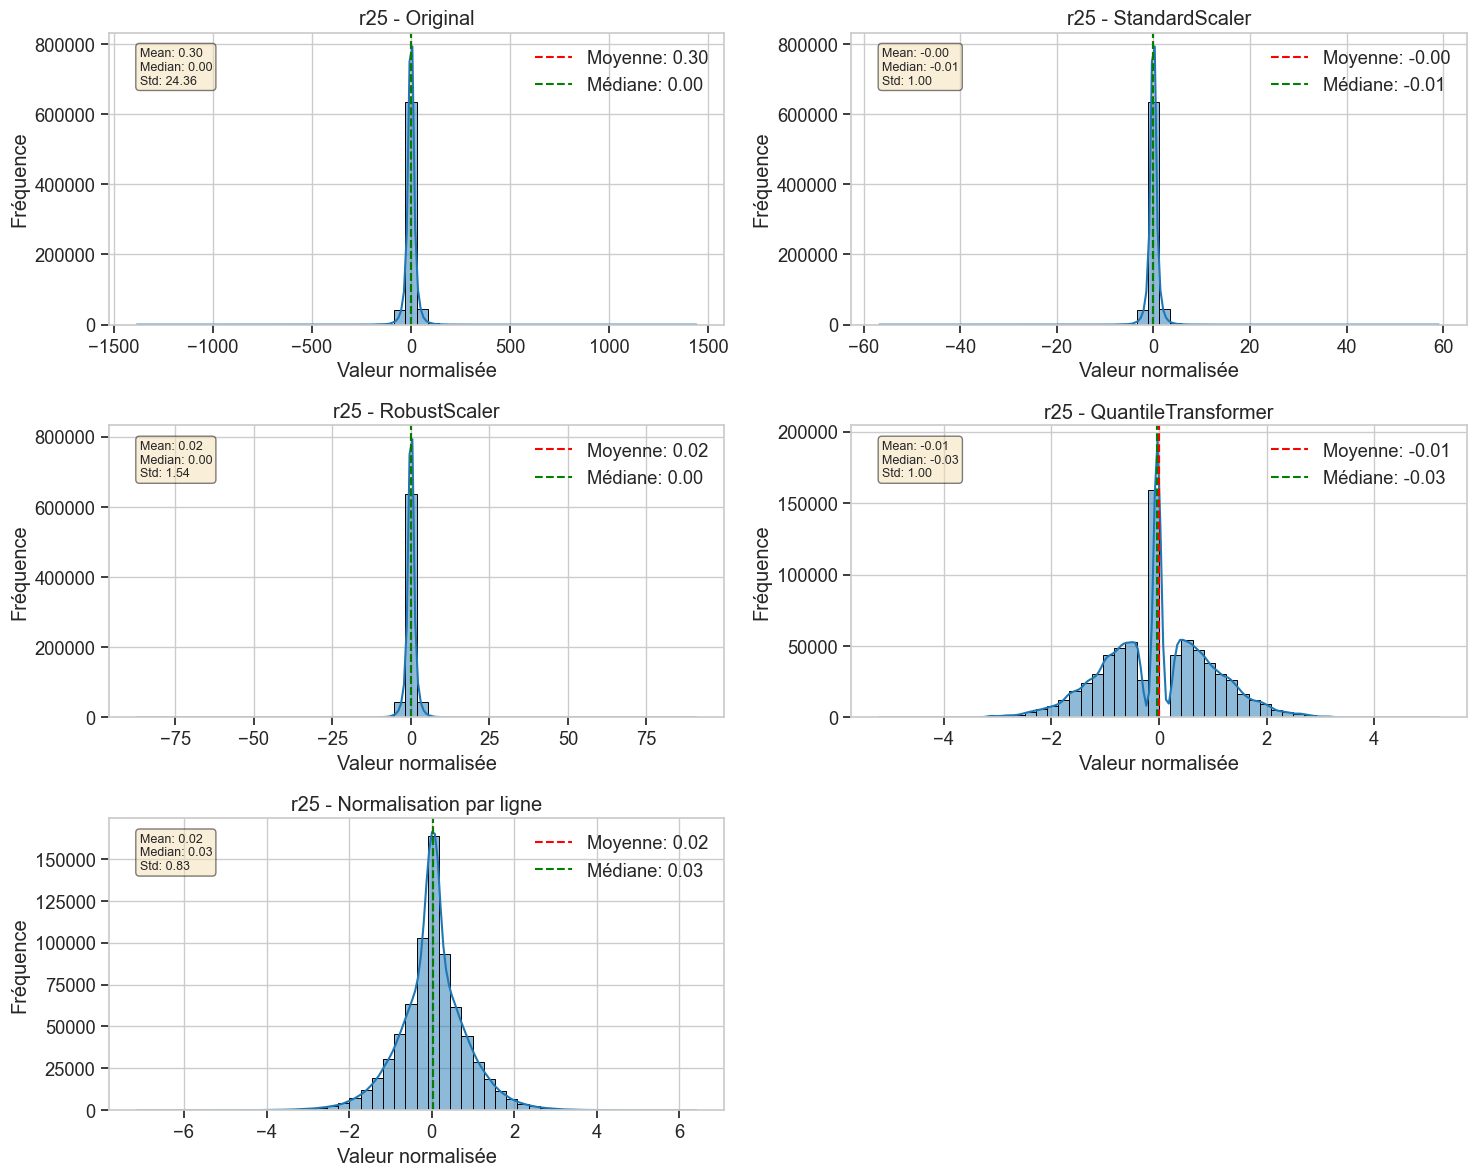

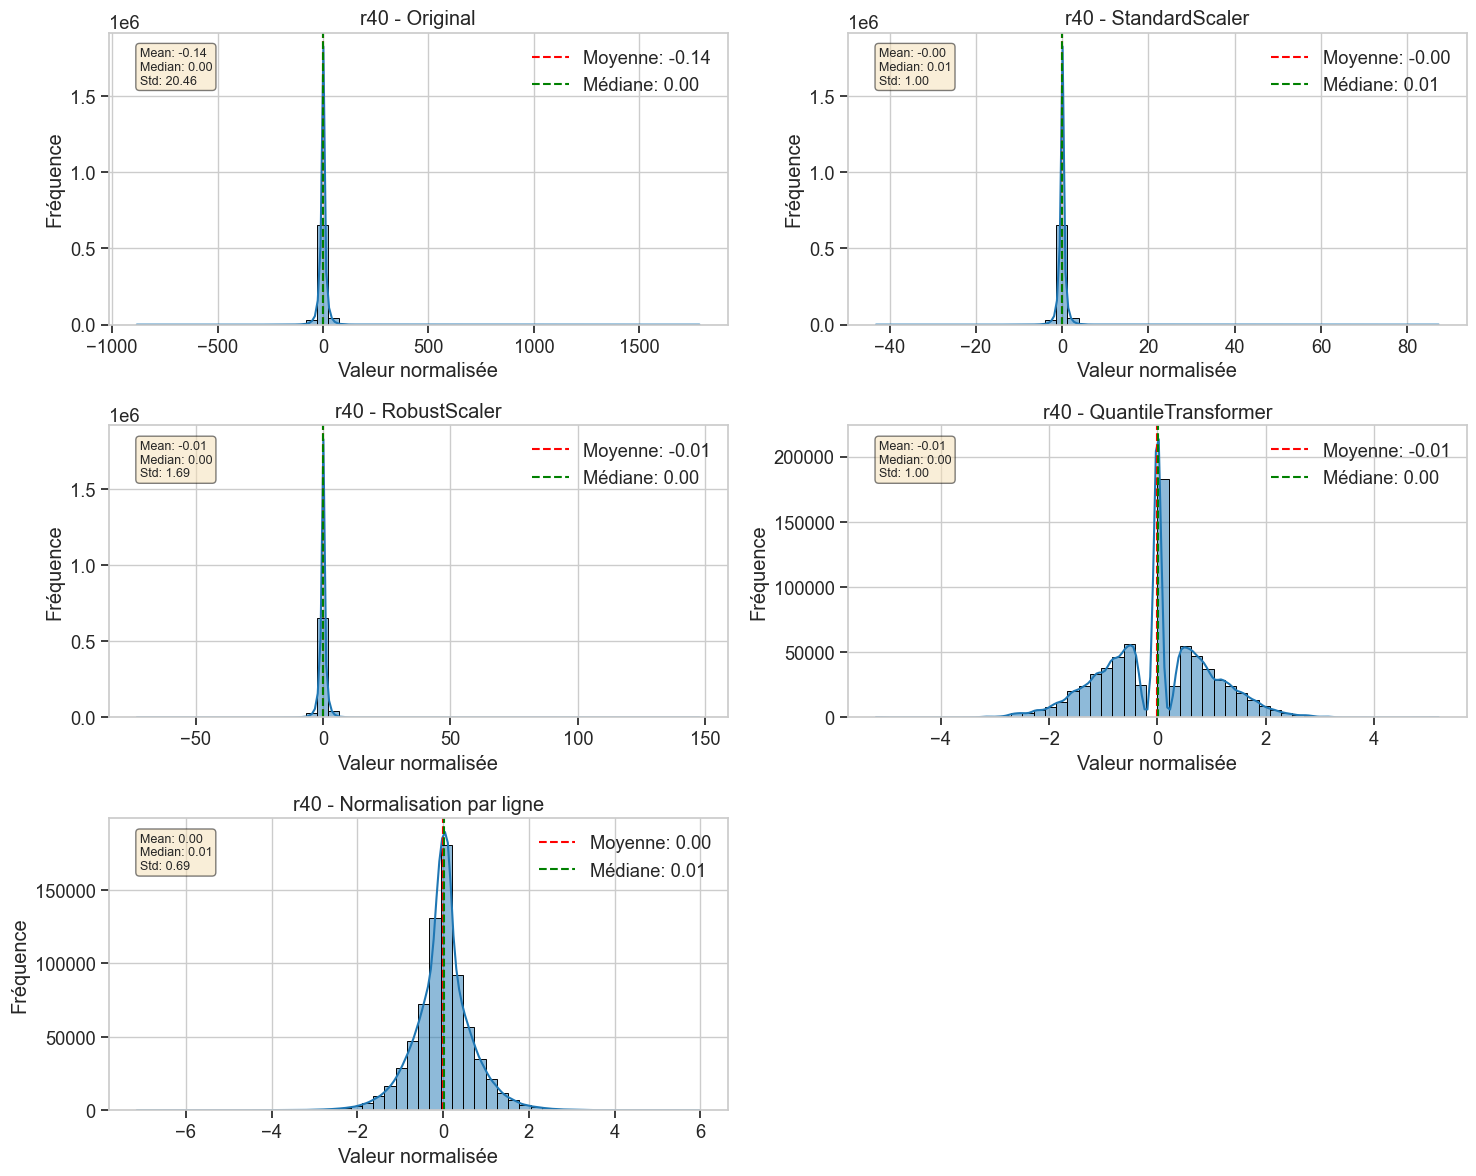

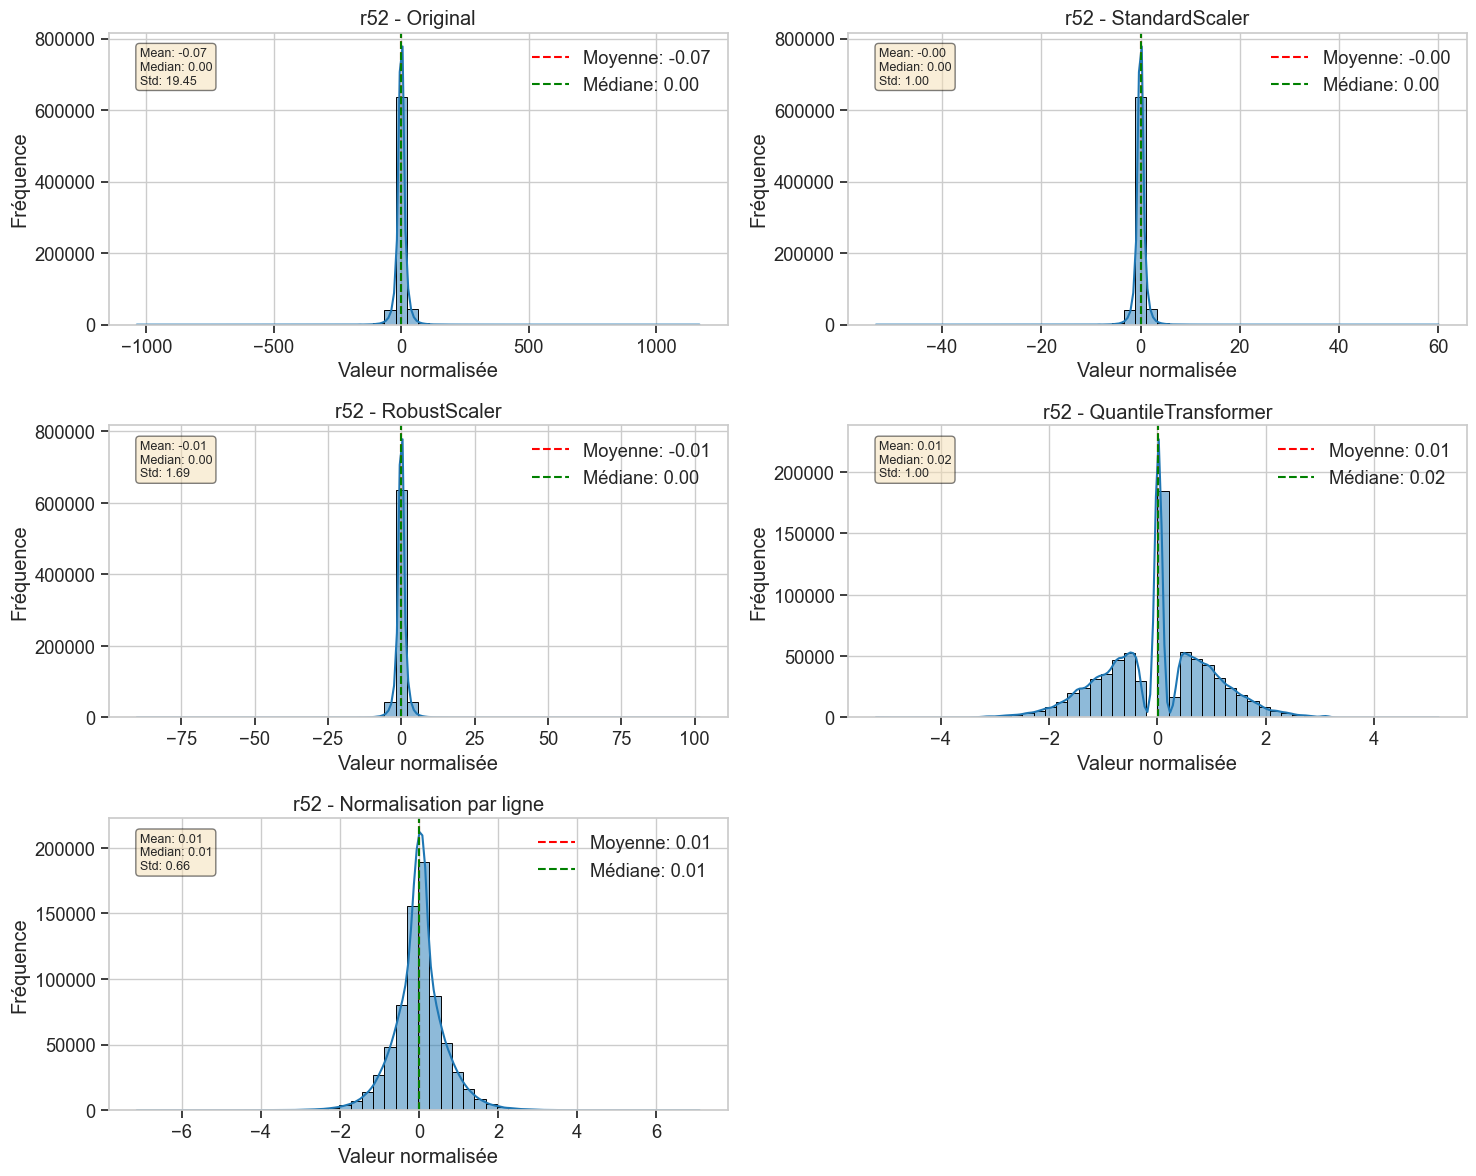


Statistiques après normalisation:


Kurtosis                                     \
Méthode Normalisation par ligne       Original QuantileTransformer   
Colonne                                                              
r0                     0.286115  314352.382928           -0.007638   
r10                    1.406272     210.650947            0.036763   
r25                    2.413538     104.170176            0.116088   
r40                    2.922470     221.466285            0.216052   
r52                    3.511795     132.957589            0.104776   

                                                      Moyenne               \
Méthode   RobustScaler StandardScaler Normalisation par ligne     Original   
Colonne                                                                      
r0       314352.382928  314352.382928               -0.218097  2011.933860   
r10         210.650947     210.650947                0.023956     0.441309   
r25         104.170176     104.170176                0.021261     0.298970   
r40         221.466285     221.466285                0.002842    -0.138532   
r52         132.957589     132.957589                0.006341    -0.065975   

                                                         \
Méthode QuantileTransformer RobustScaler StandardScaler   
Colonne                                                   
r0                 0.012147    35.767713  -7.924261e-19   
r10               -0.012576     0.020603  -5.226123e-18   
r25               -0.008268     0.018874  -3.184289e-18   
r40               -0.010305    -0.011458  -1.492240e-17   
r52                0.005871    -0.005737  -3.441949e-18   

                       Skewness                                               \
Méthode Normalisation par ligne    Original QuantileTransformer RobustScaler   
Colonne                                                                        
r0                    -0.250644  516.699019            0.002077   516.699019   
r10                    0.012088    1.762238            0.014590     1.762238   
r25                   -0.083359    0.372370            0.027116     0.372370   
r40                    0.028564    1.953211           -0.023181     1.953211   
r52                    0.069300    1.050953           -0.052902     1.050953   

                                    Écart-type                 \
Méthode StandardScaler Normalisation par ligne       Original   
Colonne                                                         
r0          516.699019                2.629368  636970.524974   
r10           1.762238                1.044093      32.525730   
r25           0.372370                0.830841      24.358171   
r40           1.953211                0.685904      20.458597   
r52           1.050953                0.660190      19.449087   

                                                          
Méthode QuantileTransformer  RobustScaler StandardScaler  
Colonne                                                   
r0                 0.991334  11323.920444       1.000001  
r10                0.992987      1.518475       1.000001  
r25                1.004868      1.537763       1.000001  
r40                1.003741      1.692192       1.000001  
r52                1.002203      1.691225       1.000001

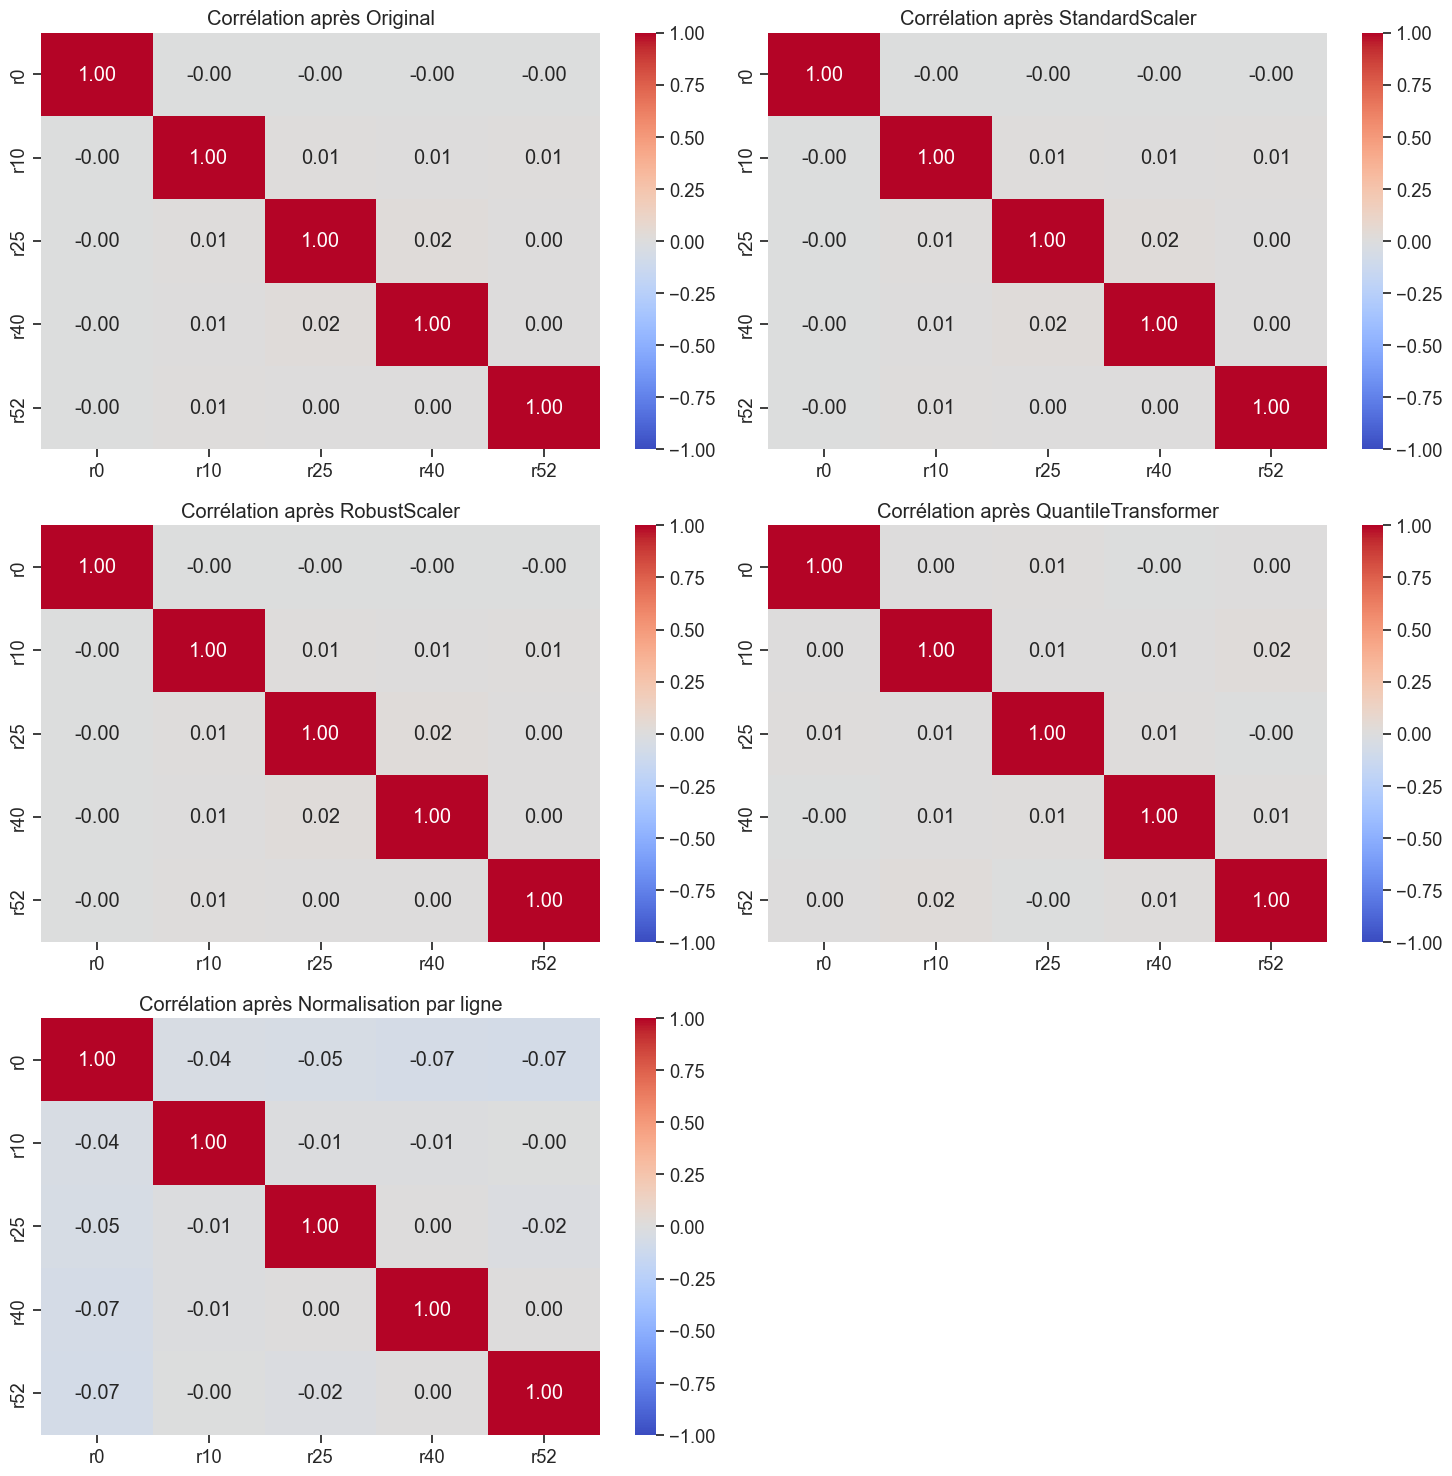

In [ ]:
normalization_results = analyze_normalization(imputed_datasets)

La normalisation par ligne et par le Quantile sont deux méthodes qui permettent de résorber le problème des longues queues de distribution qui pourraient fausser les calculs. Bien que les rendements ne suivent pas une loi normale, la distribution est légèrement meilleure et règle le soucis des extrêmes.

## 4. Modèles de référence (benchmarks)
 
Nous établissons des modèles de base pour servir de références aux futures améliorations. Et effectuons une comparaison de base qui nous servira de sélection pour le choix des jeux de données. 

#### Features d'Ingénierie pour la Prédiction des Prix d'Actions

Notre modèle utilise deux catégories principales de features dérivées des rendements bruts (r0 à r52):

##### 1. Features Statistiques de Base (`basic_stats`)

Ces features capturent les distributions et tendances générales des rendements:

| Feature | Description | Formule |
|---------|-------------|---------|
| `r_mean` | Moyenne des rendements | $\frac{1}{n}\sum_{i=0}^{n} r_i$ |
| `r_std` | Écart-type des rendements | $\sqrt{\frac{1}{n}\sum_{i=0}^{n}(r_i - \bar{r})^2}$ |
| `r_min` | Rendement minimum | $\min(r_0, r_1, ..., r_{52})$ |
| `r_max` | Rendement maximum | $\max(r_0, r_1, ..., r_{52})$ |
| `r_sum` | Somme totale des rendements | $\sum_{i=0}^{n} r_i$ |
| `r_pos_count` | Nombre de rendements positifs | $\sum_{i=0}^{n} \mathbb{1}_{r_i > 0}$ |
| `r_neg_count` | Nombre de rendements négatifs | $\sum_{i=0}^{n} \mathbb{1}_{r_i < 0}$ |
| `r_zero_count` | Nombre de rendements nuls | $\sum_{i=0}^{n} \mathbb{1}_{r_i = 0}$ |
| `r_pos_sum` | Somme des rendements positifs | $\sum_{i=0}^{n} r_i \cdot \mathbb{1}_{r_i > 0}$ |
| `r_neg_sum` | Somme des rendements négatifs | $\sum_{i=0}^{n} r_i \cdot \mathbb{1}_{r_i < 0}$ |

##### 2. Indicateurs Techniques (`technical`)

Ces features s'inspirent d'indicateurs techniques utilisés en analyse financière:

| Feature | Description | Formule |
|---------|-------------|---------|
| `r_roll_mean_X` | Moyenne mobile sur X périodes | $\frac{1}{X}\sum_{i=n-X+1}^{n} r_i$ |
| `r_roll_std_X` | Écart-type mobile sur X périodes | $\sqrt{\frac{1}{X}\sum_{i=n-X+1}^{n}(r_i - \bar{r}_X)^2}$ |
| `r_momentum_5` | Différence de prix sur 5 périodes | $r_n - r_{n-5}$ |
| `r_momentum_10` | Différence de prix sur 10 périodes | $r_n - r_{n-10}$ |

##### 3. Features Financières Avancées

En complément, nous utilisons également des indicateurs financiers plus sophistiqués:

| Feature | Description | Formule |
|---------|-------------|---------|
| `volatility_X` | Volatilité sur X périodes | $\sqrt{\frac{1}{X}\sum_{i=0}^{X-1}(r_i - \bar{r})^2}$ |
| `sharpe_ratio` | Ratio rendement/risque | $\frac{\bar{r}}{\sigma_r}$ |
| `momentum` | Différence entre rendements récents et anciens | $\bar{r}_{récent} - \bar{r}_{ancien}$ |
| `trend_slope` | Pente de la tendance linéaire | Coefficient de régression linéaire sur les rendements |
| `pos_ratio` | Ratio de rendements positifs | $\frac{\sum_{i=0}^{n} \mathbb{1}_{r_i > 0}}{n}$ |
| `neg_ratio` | Ratio de rendements négatifs | $\frac{\sum_{i=0}^{n} \mathbb{1}_{r_i < 0}}{n}$ |

**Ces dernières features ne sont utilisés que lors de la sélection des features les plus pertinentes et n'entrent pas dans le benchmark.**

### 4.1 XGBoost baseline
 
Nous commençons par évaluer les performances du modèle XGBoost sur les données brutes (70%)

In [ ]:
print("\nDatasets disponibles:")
for key, info in DATASETS.items():
    print(f"- {key}: {info['description']}")

print("\nModèles disponibles:")
models = get_models()
for key, info in models.items():
    if 'description' in info:
        print(f"- {key}: {info['description']}")
    else:
        print(f"- {key}")


Datasets disponibles:
- raw: Données brutes
- ffbf: Données forward filled puis backward
- bfff: Données backward filled puis forward
- interp: Données interpolation linéaire puis bffff
- mice: Données MICE imputer puis bfff
- knn: Données knn imputer puis bfff
- raw_with_features: Données brutes avec features
- ffbf_with_features: Données forward filled puis backward avec features
- bfff_with_features: Données backward filled puis forward avec features
- interp_with_features: Données interpolation linéaire puis bffff avec features
- mice_with_features: Données MICE imputer puis bfff avec features
- knn_with_features: Données knn imputer puis bfff avec features
- low_nan: Colonnes avec <30% de NaN, imputation à 0

Modèles disponibles:
- xgboost_baseline: XGBoost de base
- xgboost_tuned: XGBoost avec paramètres 
- rf_baseline: Baseline Random Forest model
- logistic: Multinomial Logistic Regression



--- Baseline XGBoost sur données brutes ---
Attention: Valeurs manquantes détectées - Train: 969666, Test: 512130
Application de fillna(0)...

Résultats détaillés de l'expérience baseline:
Dataset: raw (Données brutes)
Model: xgboost_baseline (XGBoost de base)
Features Added: False
Feature Sets: None
Accuracy: 0.3105
Weighted F1-Score: 0.2658
Class-wise Performance:
  Class -1: Precision = 0.3014, Recall = 0.1128
  Class  0: Precision = 0.4117, Recall = 0.1670
  Class  1: Precision = 0.2885, Recall = 0.7208
Timing Information:
  Data Loading: 9.92 seconds
  Training: 21.16 seconds
  Prediction: 1.05 seconds
  Total Time: 32.14 seconds


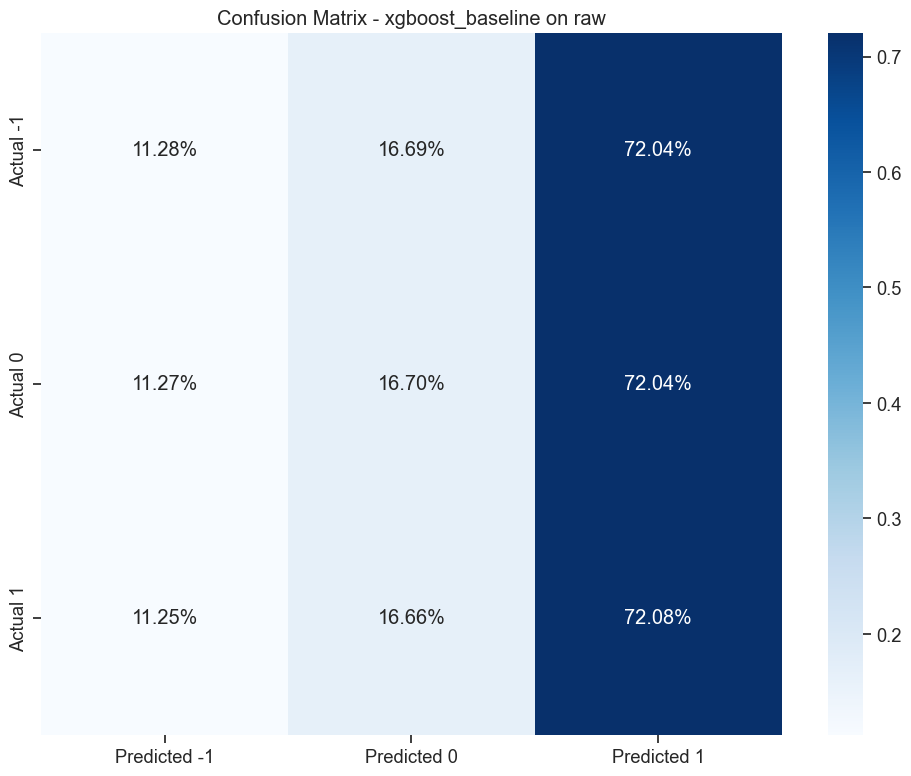

In [ ]:
print("\n--- Baseline XGBoost sur données brutes ---")
baseline_result = run_experiment(dataset_key="raw", model_key="xgboost_baseline", add_feat=False)
results_tracker = add_result(results_tracker, baseline_result)

if 'normalize_by_row' not in results_tracker.columns:
    results_tracker['normalize_by_row'] = False

print("\nRésultats détaillés de l'expérience baseline:")
display_experiment_result(baseline_result)

#### Performance globale

Accuracy de 31.05%: Cela signifie que le modèle prédit correctement la direction du prix dans environ 31% des cas. Pour un problème à 3 classes où une prédiction aléatoire donnerait ~33%, cette performance est à peine inférieure au hasard.

F1-Score pondéré de 0.2658: Cette métrique combine précision et rappel. Un score bas indique un déséquilibre entre ces deux mesures.

Analyse par classe : 

**Classe -1 (baisse de prix):**

- Precision de 30.14%: Quand le modèle prédit une baisse, il a raison dans 30% des cas.

- Recall très faible de 11.28%: Le modèle ne détecte que 11% des véritables baisses.


**Classe 0 (prix stable):**

- Precision de 41.17%: Meilleure précision des trois classes.

- Recall faible de 16.70%: Le modèle manque plus de 83% des cas où le prix reste stable.


**Classe 1 (hausse de prix):**

- Precision  de 28.85%: La plus faible précision des trois classes.

- Recall très élevé de 72.08%: Le modèle détecte bien les hausses, mais le résultat est biaisé. 


#### Biais du modèle

Le modèle montre un fort biais vers la classe 1 (hausse). Le modèle prédit "hausse" par défaut et la bonne performance du recall sur la classe 1 est due à sa tendance à prédire systématiquement cette classe
Il est particulièrement mauvais pour détecter les baisses (-1)

### 4.2 Benchmark XGBoost sur les différentes stratégies d'imputation

**experiment_runner()** exécute une expérience  : charge les données, prépare les variables (avec ajout ou normalisation facultative de caractéristiques), entraîne un modèle choisi, puis évalue ses performances à l’aide de métriques détaillées. On peut choisir de calculer les features ou non, de normaliser ou non, et map et remap les catégories pour s'adapter au XGBoost

In [ ]:
print("\n--- Comparaison des stratégies d'imputation avec XGBoost ---")

# Liste des stratégies d'imputation
imputation_strategies = ["raw", "ffbf", "bfff", "interp", "knn", "mice", "low_nan"]
imputation_results = []

# Tester les datasets standards (sans features ni normalisation)
for strategy in imputation_strategies:
    print(f"\nTest de {strategy} sans features ni normalisation...")
    try:
       
        result_without_features = run_experiment(
            dataset_key=strategy, 
            model_key="xgboost_baseline", 
            add_feat=False,  # Sans feature engineering
            normalize_by_row=False
        )
        results_tracker = add_result(results_tracker, result_without_features)
        imputation_results.append(result_without_features)
        print(f"Accuracy: {result_without_features['accuracy']:.4f}")
    except Exception as e:
        print(f"Erreur lors du traitement de {strategy}: {e}")

# Tester avec normalisation par ligne
for strategy in imputation_strategies:
    print(f"\nTest de {strategy} avec normalisation par ligne...")
    try:

        result_normalized = run_experiment(
            dataset_key=strategy, 
            model_key="xgboost_baseline", 
            add_feat=False,
            normalize_by_row=True         # Avec normalisation par ligne
        )
        results_tracker = add_result(results_tracker, result_normalized)
        imputation_results.append(result_normalized)
        print(f"Accuracy: {result_normalized['accuracy']:.4f}")
        
        # Calculer l'amélioration due à la normalisation
        standard_result = next((r for r in imputation_results 
                               if r['dataset'] == strategy and not r.get('normalize_by_row', False)), None)
        if standard_result:
            improvement = result_normalized['accuracy'] - standard_result['accuracy']
            print(f"Amélioration due à la normalisation: {improvement:.4f} ({improvement*100:.2f}%)")
    except Exception as e:
        print(f"Erreur lors de la normalisation de {strategy}: {e}")

#Tester les datasets avec features prétraitées
for strategy in imputation_strategies:
    if strategy == "low_nan":
        continue  # Pas de version avec features pour low_nan
        
    print(f"\nTest de {strategy} avec features prétraitées...")
    try:
        preprocessed_key = f"{strategy}_with_features"
        
        if preprocessed_key in DATASETS:
            # Sans normalisation
            result_with_features = run_experiment(
                dataset_key=preprocessed_key, 
                model_key="xgboost_baseline", 
                add_feat=False,         #On n'utilise pas la fonction de features puisqu'elles sont déjà calculées ici 
                normalize_by_row=False
            )
            results_tracker = add_result(results_tracker, result_with_features)
            imputation_results.append(result_with_features)
            print(f"Accuracy avec features prétraitées: {result_with_features['accuracy']:.4f}")
            
            # Avec normalisation par ligne
            result_features_normalized = run_experiment(
                dataset_key=preprocessed_key, 
                model_key="xgboost_baseline", 
                add_feat=False,
                normalize_by_row=True
            )
            results_tracker = add_result(results_tracker, result_features_normalized)
            imputation_results.append(result_features_normalized)
            print(f"Accuracy avec features et normalisation: {result_features_normalized['accuracy']:.4f}")
            
            # Comparer avec le dataset standard
            standard_result = next((r for r in imputation_results 
                                   if r['dataset'] == strategy and not r.get('normalize_by_row', False)), None)
            if standard_result:
                improvement_features = result_with_features['accuracy'] - standard_result['accuracy']
                print(f"Amélioration due aux features: {improvement_features:.4f} ({improvement_features*100:.2f}%)")
            
            # Comparer normalisation avec/sans features
            improvement_norm = result_features_normalized['accuracy'] - result_with_features['accuracy']
            print(f"Amélioration due à la normalisation: {improvement_norm:.4f} ({improvement_norm*100:.2f}%)")
        else:
            print(f"Le dataset prétraité '{preprocessed_key}' n'existe pas dans le registre.")
    except Exception as e:
        print(f"Erreur lors du traitement de {strategy} avec features: {e}")


--- Comparaison des stratégies d'imputation avec XGBoost ---

Test de raw sans features ni normalisation...
Attention: Valeurs manquantes détectées - Train: 969666, Test: 512130
Application de fillna(0)...
Accuracy: 0.3105

Test de ffbf sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3136

Test de bfff sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3132

Test de interp sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3118

Test de knn sans features ni normalisation...
Attention: Valeurs manquantes détectées - Train: 5362225, Test: 8004811
Application de fillna(0)...
Erreur lors du traitement de knn: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [ 0.  1.  2. nan]

Test de mice sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3112

Test de low_nan sans features ni normalisation...
Aucune valeur manquante détectée.
Accuracy: 0.3105

#### 4.3 Visualisation des résultats des benchmarks


--- Visualisation des résultats des benchmarks ---
Top 10 des meilleures configurations:


dataset                                dataset_description  \
10                interp          Données interpolation linéaire puis bffff   
12               low_nan          Colonnes avec <30% de NaN, imputation à 0   
2                   ffbf               Données forward filled puis backward   
3                   bfff               Données backward filled puis forward   
7                    raw                                     Données brutes   
9                   bfff               Données backward filled puis forward   
17    bfff_with_features  Données backward filled puis forward avec feat...   
8                   ffbf               Données forward filled puis backward   
4                 interp          Données interpolation linéaire puis bffff   
19  interp_with_features  Données interpolation linéaire puis bffff avec...   

               model normalize_by_row features_added  accuracy  f1_weighted  \
10  xgboost_baseline             True          False  0.318455     0.275464   
12  xgboost_baseline             True          False  0.316347     0.264087   
2   xgboost_baseline            False          False  0.313561     0.275949   
3   xgboost_baseline            False          False  0.313178     0.278233   
7   xgboost_baseline             True          False  0.312979     0.262334   
9   xgboost_baseline             True          False  0.312760     0.260070   
17  xgboost_baseline            False          False  0.312224     0.269205   
8   xgboost_baseline             True          False  0.312087     0.257210   
4   xgboost_baseline            False          False  0.311830     0.275198   
19  xgboost_baseline            False          False  0.311811     0.266444   

    total_time  
10   26.681862  
12   26.472266  
2    23.970196  
3    24.582174  
7    27.132666  
9    29.832149  
17   36.342103  
8    25.556113  
4    26.894272  
19   34.676225

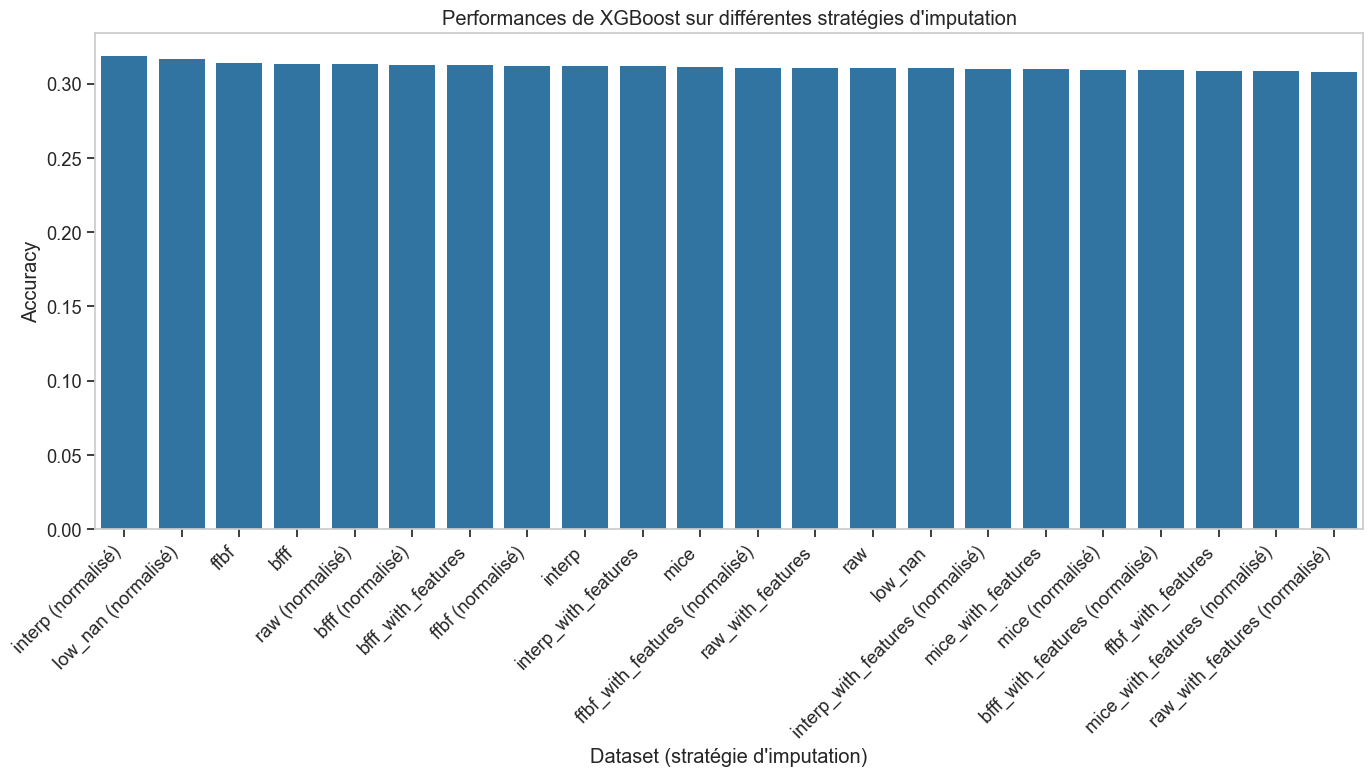

In [ ]:
print("\n--- Visualisation des résultats des benchmarks ---")

# Créer un DataFrame pour la visualisation
summary_df = results_tracker[["dataset", "dataset_description", "model", "normalize_by_row", 
                             "features_added", "accuracy", "f1_weighted", "total_time"]]
summary_df = summary_df.sort_values(by="accuracy", ascending=False)

print("Top 10 des meilleures configurations:")
display(summary_df.head(10))

# Visualisation les résultats par dataset et normalisation
plt.figure(figsize=(14, 8))
summary_plot_data = summary_df.copy()
summary_plot_data["dataset_norm"] = summary_plot_data["dataset"] + \
                                    summary_plot_data["normalize_by_row"].apply(lambda x: " (normalisé)" if x else "")
                                    
xgb_data = summary_plot_data[summary_plot_data["model"] == "xgboost_baseline"]

# Barplot en fonction de l'accuracy
sns.barplot(x="dataset_norm", y="accuracy", data=xgb_data)
plt.title('Performances de XGBoost sur différentes stratégies d\'imputation')
plt.xlabel('Dataset (stratégie d\'imputation)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Un résultat un peu surprenant, qu'importe la transformation qu'on applique aux données, la différence est minime malgré. On remarque que les modèles avec les lignes normalisées sont quand même premier, suivi de très près par le dataset de base sans transformation. Les features initiales rajoutées n'ont pas l'air d'imapcter de manière significative non plus. 

#### 4.4 Régression Logistique : 

In [ ]:
print("\n--- Test avec régression logistique sur ffbf, bfff, interp ---")

# Sélectionner quelques datasets pour la comparaison
selected_datasets = ["ffbf", "bfff", "interp"]

for dataset_key in selected_datasets:
    try:
        # Test avec régression logistique
        result = run_experiment(
            dataset_key=dataset_key,
            model_key="logistic",
            add_feat=True,
            normalize_by_row=False
        )
        results_tracker = add_result(results_tracker, result)
        print(f"Régression logistique sur {dataset_key}: Accuracy = {result['accuracy']:.4f}")
        
        # Comparer avec XGBoost
        xgb_result = next((r for r in imputation_results 
                           if r['dataset'] == dataset_key and not r.get('normalize_by_row', False)), None)
        if xgb_result:
            diff = result['accuracy'] - xgb_result['accuracy']
            print(f"Différence par rapport à XGBoost: {diff:.4f} ({diff*100:.2f}%)")
    except Exception as e:
        print(f"Erreur avec logistique sur {dataset_key}: {e}")


--- Test avec régression logistique sur quelques datasets ---
Aucune valeur manquante détectée.
Régression logistique sur ffbf: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.0972 (9.72%)
Aucune valeur manquante détectée.
Régression logistique sur bfff: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.0976 (9.76%)
Aucune valeur manquante détectée.
Régression logistique sur interp: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.0989 (9.89%)


##### Test supplémentaire avec low_nan 

Après les résultats suprenants de la régression logisitque, nous décidons de tester cette dernière sur le dataset classique légèrement retouché.

In [ ]:
selected_datasets = ["low_nan"]

for dataset_key in selected_datasets:
    try:
        # Test avec régression logistique
        result = run_experiment(
            dataset_key=dataset_key,
            model_key="logistic",
            add_feat=True,
            normalize_by_row=False
        )
        results_tracker = add_result(results_tracker, result)
        print(f"Régression logistique sur {dataset_key}: Accuracy = {result['accuracy']:.4f}")
        
        # Comparer avec XGBoost
        xgb_result = next((r for r in imputation_results 
                           if r['dataset'] == dataset_key and not r.get('normalize_by_row', False)), None)
        if xgb_result:
            diff = result['accuracy'] - xgb_result['accuracy']
            print(f"Différence par rapport à XGBoost: {diff:.4f} ({diff*100:.2f}%)")
    except Exception as e:
        print(f"Erreur avec logistique sur {dataset_key}: {e}")

Aucune valeur manquante détectée.
Régression logistique sur low_nan: Accuracy = 0.4108
Différence par rapport à XGBoost: 0.1003 (10.03%)


Remarques : Le résultat de la régression est assez surprenant pour au moins trois raisons. 

- 1 : L'accuracy du modèle est meilleure que celle du XGBoost
- 2 : Nous retrouvons l'accuracy du challenge avec un modèle différent et nous ne le retrouvons pas avec le XGBoost même, bien qu'il ne soit pas optimisé. 
- 3 : C'est la seconde fois que nous effectuons ce test, notre second notebook. Le second notebook "redaction.ipynb" est disponible sur le GitHub, et malgré un code structuré différemment, le fonds est exactement le même. Nous effectuons une régression logistique via experiment_runner() qui a par défaut row_normalisation à False et add_features à True. Les paramètres sont les mêmes et pourtant nous observons une accuracy à 41,08% sur le ffbf pour 34,60% sur l'autre notebook. 

Enfin, il est important de noter que ce chiffre 41,08% n'est pas anodin. Déjà, que 3 modèles entrainés sur 4 datasets différents aient la même accuracy au centième près est étonnant, mais également, on retrouve ce chiffre dans le notebook MLP.ipynb (GitHub) pour le MLP et Encodeur. Nous n'avons pas trouvé d'explication à ce résultat, sachant que les données utilisées dans MLP.ipynb sont les données brutes (celles directement fournies par le challenge). C'est peut être un hasard, mais un hasard très précis. 

#### 4.5 Résumé des performances des modèles de référence


--- Résumé des performances des modèles de référence ---


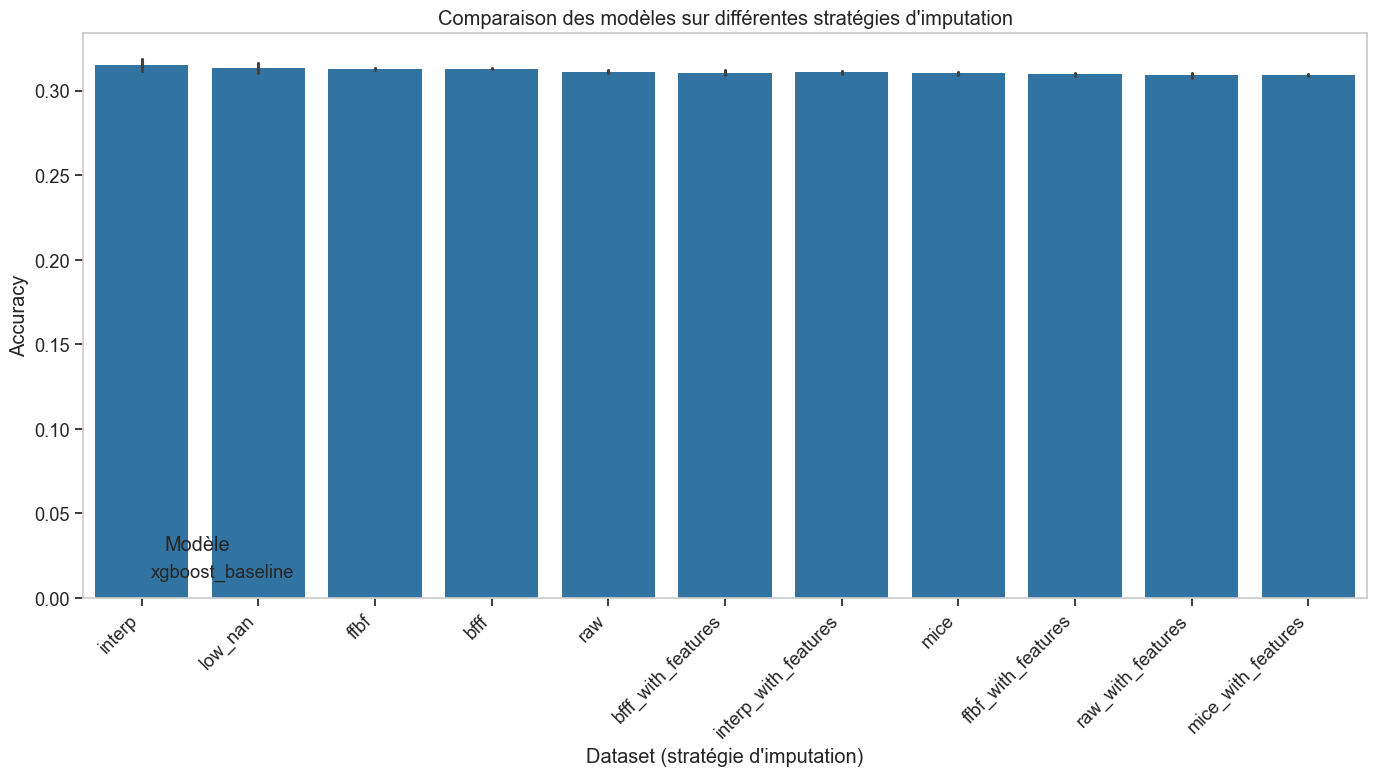


Meilleur résultat:
Dataset: interp - Données interpolation linéaire puis bffff
Modèle: xgboost_baseline
Normalisation: True
Features ajoutées: False
Accuracy: 0.3185
F1 score pondéré: 0.2755
Temps total: 26.68s


In [ ]:
print("\n--- Résumé des performances des modèles de référence ---")

model_comparison = summary_df[["model", "dataset", "normalize_by_row", "accuracy", "f1_weighted"]]
model_comparison = model_comparison.sort_values(by="accuracy", ascending=False)

# Visualiser la comparaison entre XGBoost et régression logistique
plt.figure(figsize=(14, 8))
sns.barplot(x="dataset", y="accuracy", hue="model", data=model_comparison)
plt.title('Comparaison des modèles sur différentes stratégies d\'imputation')
plt.xlabel('Dataset (stratégie d\'imputation)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.legend(title="Modèle")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Meilleur résultat
best_result = summary_df.iloc[0]
print(f"\nMeilleur résultat:")
print(f"Dataset: {best_result['dataset']} - {best_result['dataset_description']}")
print(f"Modèle: {best_result['model']}")
print(f"Normalisation: {best_result['normalize_by_row']}")
print(f"Features ajoutées: {best_result['features_added']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"F1 score pondéré: {best_result['f1_weighted']:.4f}")
print(f"Temps total: {best_result['total_time']:.2f}s")

## 5. Analyse approfondie et optimisation des modèles
 
Après avoir établi nos modèles de référence, nous entrons maintenant dans une phase d'analyse et d'optimisation plus poussée. Cette section vise à exploiter pleinement le potentiel prédictif de nos données en améliorant nos modèles à plusieurs niveaux: sélection des features les plus pertinentes, optimisation fine des hyperparamètres, et développement de stratégies pour contrôler le surapprentissage.

L'objectif est d'améliorer nos performances prédictives tout en comprenant les mécanismes qui sous-tendent ces améliorations. Cette compréhension est cruciale dans le contexte des marchés financiers, où les relations entre variables explicatives et mouvements de prix peuvent être subtiles, instables et fortement non-linéaires.

### 5.1 Sélection des datasets pour l'analyse approfondie 

In [33]:
from utils.data_loading import load_dataset_for_analysis, load_datasets, load_dataset_without_day_id, select_financial_and_rendements, select_optimized_features_no_day_equity

In [ ]:
# Identifier les 3 meilleurs datasets d'après les résultats précédents
xgb_summary = summary_df[summary_df['model'] == 'xgboost_baseline']
top_datasets = xgb_summary.head(3)

print("Top 3 des meilleures configurations:")
display(top_datasets)

# Récupérer les informations des meilleurs datasets
best_configs = []
for _, row in top_datasets.iterrows():
    config = {
        "dataset": row["dataset"],
        "normalize": row["normalize_by_row"],
        "description": row["dataset_description"]
    }
    best_configs.append(config)


--- Sélection des meilleurs datasets pour analyse approfondie ---
Top 3 des meilleures configurations:


dataset                        dataset_description             model  \
10   interp  Données interpolation linéaire puis bffff  xgboost_baseline   
12  low_nan  Colonnes avec <30% de NaN, imputation à 0  xgboost_baseline   
2      ffbf       Données forward filled puis backward  xgboost_baseline   

   normalize_by_row features_added  accuracy  f1_weighted  total_time  
10             True          False  0.318455     0.275464   26.681862  
12             True          False  0.316347     0.264087   26.472266  
2             False          False  0.313561     0.275949   23.970196

### 5.2 Chargement et préparation des données pour l'analyse des features

In [ ]:
# Fonction pour charger un dataset spécifique
from utils.data_loading import load_dataset_for_analysis

# Utiliser le meilleur dataset pour l'analyse
best_dataset = best_configs[0]["dataset"]
best_normalize = best_configs[0]["normalize"]

# Charger les données
X_train, y_train, X_test, y_test = load_dataset_for_analysis(best_dataset, best_normalize)

print(f"Dataset sélectionné: {best_dataset} (normalize={best_normalize})")
print(f"Dimensions: {X_train.shape}")


--- Préparation des données pour l'analyse des features ---
Dataset sélectionné: interp (normalize=True)
Dimensions: (730784, 55)


### 5.3 Analyse en composantes principales (PCA)

L'analyse en composantes principales nous permet d'explorer la structure dimensionnelle de nos données de rendements. En transformant nos variables potentiellement corrélées en un ensemble de variables linéairement non corrélées, nous pouvons identifier les axes de variation principaux dans nos données. Cette analyse révèle la complexité intrinsèque de nos données financières, avec une variance distribuée sur de nombreuses composantes sans structure dominante claire, ce qui explique en partie la difficulté du problème prédictif.


--- Analyse en composantes principales (PCA) ---

Analyse PCA sur le dataset interp...
Temps de chargement: 3.07 secondes
Temps d'exécution PCA: 0.00 secondes
Composantes nécessaires pour 70.0% de variance expliquée: 33
Composantes nécessaires pour 80.0% de variance expliquée: 39
Composantes nécessaires pour 90.0% de variance expliquée: 46
Composantes nécessaires pour 95.0% de variance expliquée: 49
Composantes nécessaires pour 99.0% de variance expliquée: 53


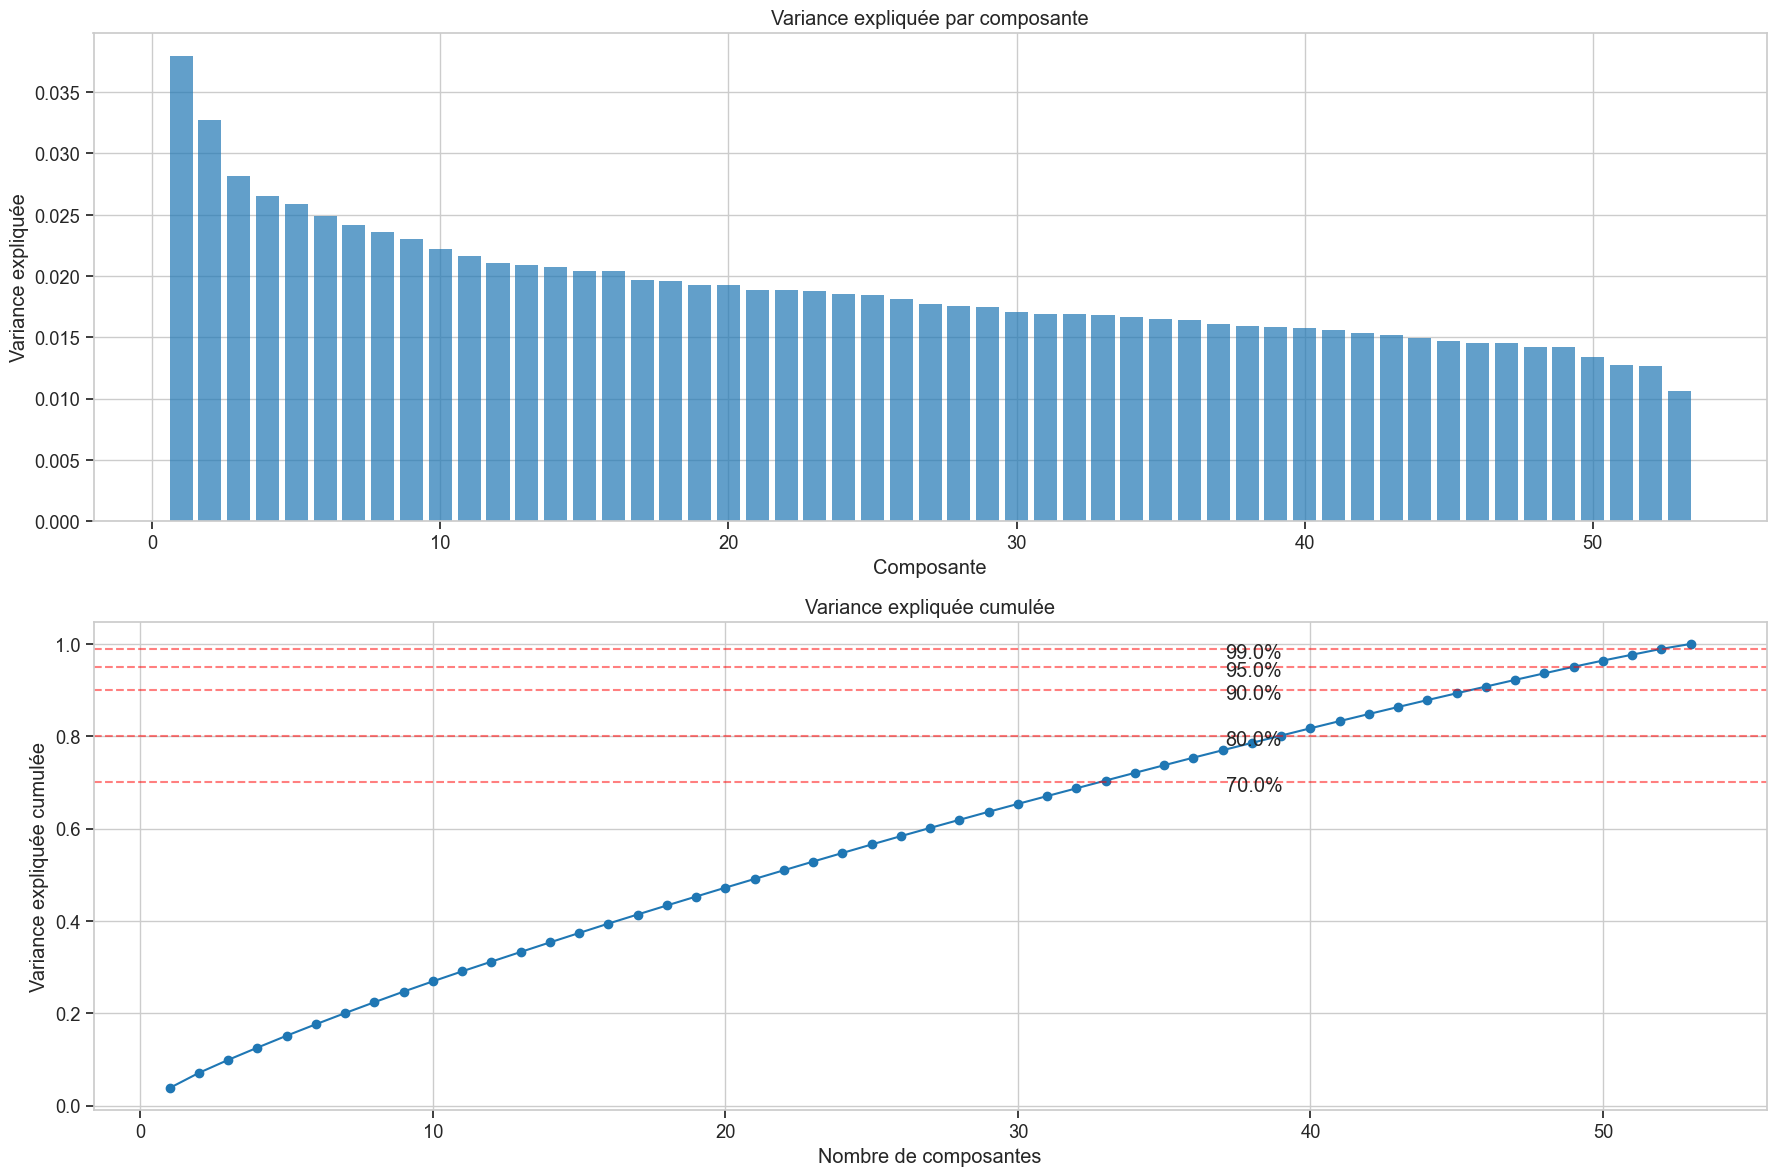

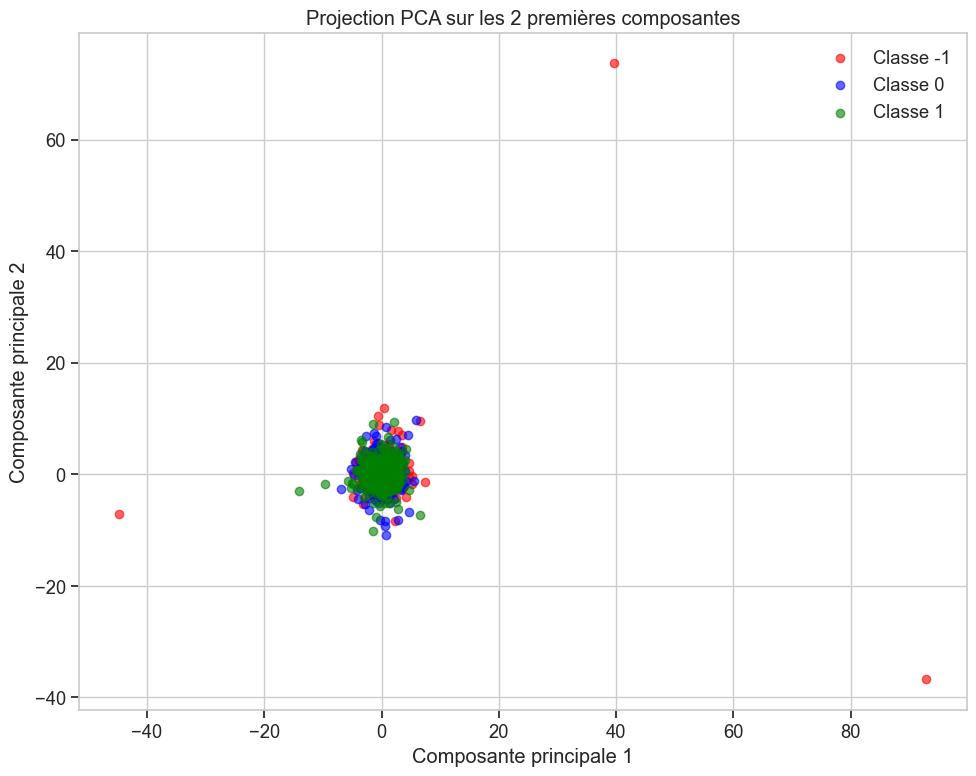

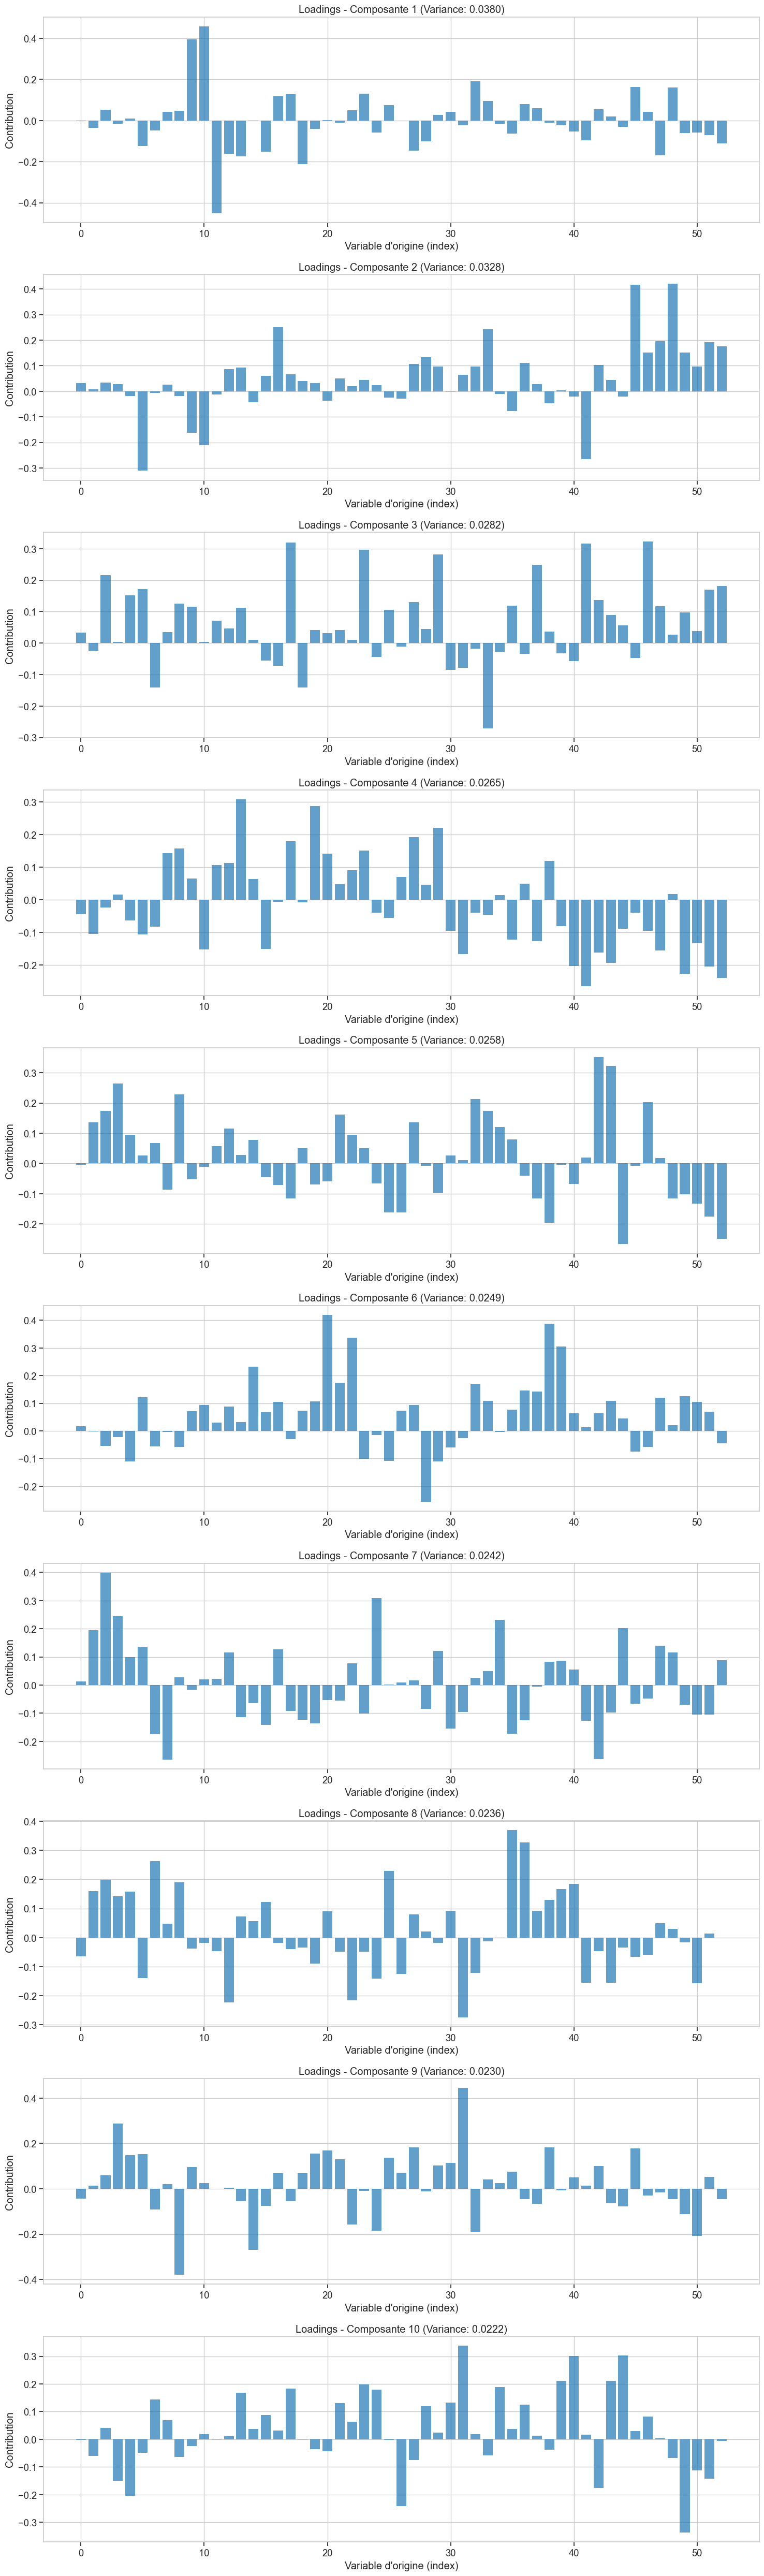


Variables les plus contributives par composante:

Composante 1:
  r10: 0.4589
  r11: -0.4507
  r9: 0.3953
  r18: -0.2124
  r32: 0.1906

Composante 2:
  r48: 0.4199
  r45: 0.4160
  r5: -0.3111
  r41: -0.2659
  r16: 0.2509

Composante 3:
  r46: 0.3223
  r17: 0.3188
  r41: 0.3170
  r23: 0.2972
  r29: 0.2809

Composante 4:
  r13: 0.3078
  r19: 0.2879
  r41: -0.2647
  r52: -0.2395
  r49: -0.2265

Composante 5:
  r42: 0.3516
  r43: 0.3217
  r44: -0.2661
  r3: 0.2641
  r52: -0.2484

Composante 6:
  r20: 0.4200
  r38: 0.3884
  r22: 0.3380
  r39: 0.3053
  r28: -0.2561

Composante 7:
  r2: 0.3996
  r24: 0.3089
  r7: -0.2643
  r42: -0.2639
  r3: 0.2446

Composante 8:
  r35: 0.3689
  r36: 0.3272
  r31: -0.2734
  r6: 0.2623
  r25: 0.2292

Composante 9:
  r31: 0.4444
  r8: -0.3797
  r3: 0.2887
  r14: -0.2697
  r50: -0.2084

Composante 10:
  r31: 0.3381
  r49: -0.3374
  r44: 0.3025
  r40: 0.3008
  r26: -0.2416


In [ ]:
pca_results = perform_pca_analysis(dataset_key=best_dataset, sample_size=10000)

Interprétation : 

L'ACP réalisée sur rendements et features révèle plusieurs aspects de la structure des données.

**Structure de variance**

Le graphique de variance expliquée montre une décroissance relativement graduelle, sans rupture nette. La première composante explique environ 3,8% de la variance totale, et chacune des composantes suivantes contribue légèrement moins. Cette distribution "en peigne" indique qu'aucune dimension ne domine clairement la structure des données. Pour capturer 90% de la variance, il faudrait conserver environ 40 composantes (comme indiqué sur le graphique de variance cumulée), ce qui suggère une forte dimensionnalité intrinsèque des données. On ne peut pas appliquer la "règle du coude" dans ce cas précis.

**Séparation des classes**

La projection des données sur les deux premières composantes principales (Image 2) ne montre pas de séparation claire entre les trois classes (-1, 0, 1). Les points de toutes les classes se superposent fortement au centre du graphique, avec seulement quelques outliers isolés appartenant majoritairement à la classe -1 (baisse). Cette absence de séparation nette explique en partie pourquoi les modèles de classification ont des performances limitées - les rendements matinaux ne permettent pas de distinguer facilement les mouvements de prix de l'après-midi dans cet espace réduit.

**Contribution des variables**

L'analyse des loadings (Image 3) montre des patterns intéressants:

**Première composante**: Fortement influencée par r10 et r11 (avec des signes opposés), ainsi que r9, ce qui suggère que cette dimension capture principalement les mouvements de prix autour de la période 10h20-10h30 (environ 50-55 minutes après l'ouverture du marché).

**Deuxième composante**: Dominée par r48 et r45, qui correspondent aux rendements de fin de matinée, juste avant la période à prédire, ainsi que r5 avec un signe opposé. Cette composante semble donc capturer un contraste entre les mouvements de début et de fin de matinée.

**Composantes suivantes**: Les autres composantes présentent des combinaisons plus variées de variables, avec des contributions de rendements à différents moments de la journée, sans pattern temporel évident.

Cette structure complexe de loadings, où différentes périodes de temps contribuent à différentes composantes, suggère que les informations prédictives sont dispersées à travers plusieurs moments de la journée de trading, sans qu'une période spécifique ne soit nettement dominante.
Implications pour la modélisation

Les résultats de l'ACP expliquent pourquoi la sélection de features et l'utilisation d'algorithmes d'ensemble n'améliorent que marginalement les performances prédictives. La nature intrinsèquement complexe et bruitée des données financières, combinée à l'absence de structure claire séparant les classes, rend le problème de prédiction particulièrement difficile. Une grande partie de l'information pertinente est distribuée sur de nombreuses dimensions, et la réduction dimensionnelle agressive risque d'éliminer des signaux prédictifs subtils.
Pour améliorer les performances, des approches qui capturent mieux les interactions non-linéaires entre variables et les dépendances temporelles pourraient être plus adaptées qu'une simple sélection de features basée sur des mesures d'importance individuelles.

#### 5.4 Ajout des features financières

Pour enrichir notre espace de features, nous intégrons des indicateurs financiers avancés dérivés des rendements bruts. Ces indicateurs, inspirés des pratiques d'analyse technique et quantitative, incluent des mesures de volatilité sur différentes fenêtres temporelles, des ratios de performance/risque comme le ratio de Sharpe, et des indicateurs de momentum. Ces features additionnelles visent à capturer des dynamiques de marché plus complexes que les simples rendements individuels.

In [ ]:
# Appliquer les features financières
X_train_with_financial = add_financial_features(X_train)
X_test_with_financial = add_financial_features(X_test)

# Afficher les nouvelles features
new_financial_features = [col for col in X_train_with_financial.columns if col not in X_train.columns]
print(f"Features financières ajoutées: {len(new_financial_features)}")
print("Top 10 nouvelles features:", ', '.join(new_financial_features[:10]))


--- Ajout de features financières avancées ---
Ajout de 8 nouvelles features financières
Ajout de 8 nouvelles features financières
Features financières ajoutées: 8
Top 10 nouvelles features: volatility_10, volatility_20, volatility_30, sharpe_ratio, momentum, trend_slope, pos_ratio, neg_ratio


#### 5.5.1 Sélection des features - Approche 1: Garder tous les rendements

Pour la sélection des features, nous allons effectuer deux approches. Une première approche où l'on conserve l'ensemble des rendements et on effectue la sélection sur le reste des features et la seconde où toutes les features sont challengées. La logique derrière est d'observer si conserver l'ensemble des rendements permet de mieux prédire les mouvements de marchés. Il est possible que malgré la faible puissance d'explication de chacun des rendements pris individuellement, peut être que pris conjointement, via la corrélation, on puisse mieux expliquer les mouvements, même si cela implique de conserver plus de features et rendre les modèles plus lourds. 

In [ ]:
print("\n--- Sélection des features - Approche 1: Conserver tous les rendements ---")

# Identifier les features de rendement
rendement_cols = [col for col in X_train.columns if col.startswith('r') and col[1:].isdigit()]
derived_cols = [col for col in X_train_with_financial.columns if col not in rendement_cols]

print(f"Nombre de features de rendement: {len(rendement_cols)}")
print(f"Nombre de features dérivées (y compris financières): {len(derived_cols)}")

# Utiliser l'information mutuelle pour sélectionner les features dérivées
X_derived = X_train_with_financial[derived_cols]
mi_results_derived = select_by_mutual_info(X_derived, y_train, top_n=20, plot=False)
selected_derived_features = mi_results_derived['selected_features'][:15]  # Top 15

# Afficher les features dérivées sélectionnées
print(f"\nTop 15 features dérivées sélectionnées:")
for i, feature in enumerate(selected_derived_features):
    print(f"{i+1}. {feature}")

# Combiner les rendements avec les features dérivées sélectionnées
approach1_features = rendement_cols + selected_derived_features
print(f"\nApproche 1: Total de {len(approach1_features)} features ({len(rendement_cols)} rendements + {len(selected_derived_features)} dérivées)")


--- Sélection des features - Approche 1: Conserver tous les rendements ---
Nombre de features de rendement: 53
Nombre de features dérivées (y compris financières): 10

Top 15 features dérivées sélectionnées:
1. day
2. equity
3. pos_ratio
4. neg_ratio
5. momentum
6. sharpe_ratio
7. volatility_20
8. trend_slope
9. volatility_30
10. volatility_10

Approche 1: Total de 63 features (53 rendements + 10 dérivées)


#### 5.5.2 Sélection des features - Approche 2: Sélectionner parmi toutes les features


--- Sélection des features - Approche 2: Sélectionner parmi toutes les features ---


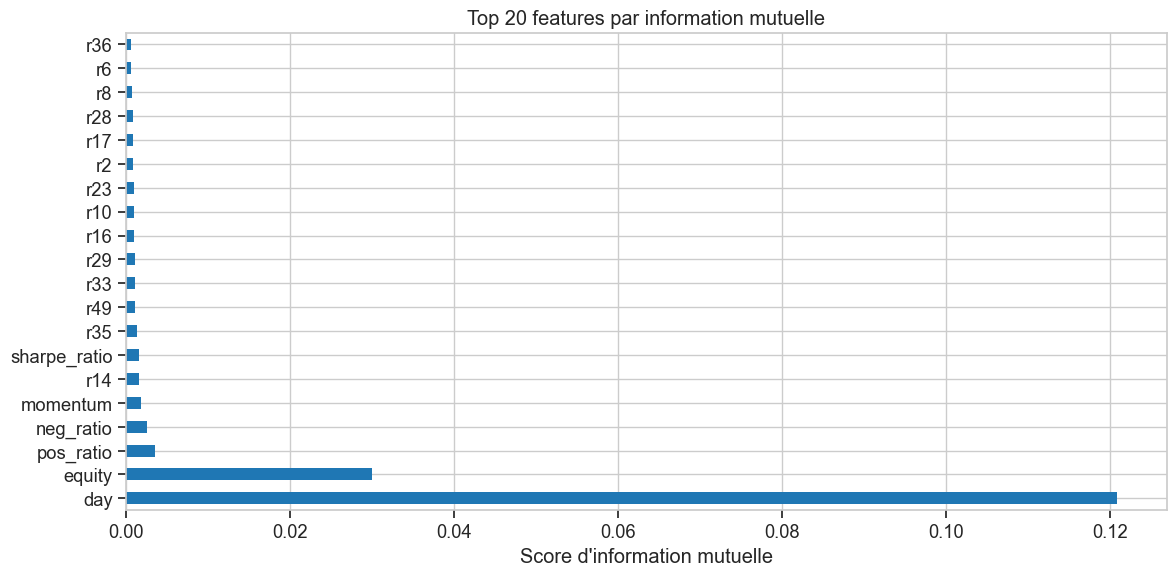

Top features par information mutuelle:
day             0.120834
equity          0.030033
pos_ratio       0.003579
neg_ratio       0.002605
momentum        0.001805
r14             0.001621
sharpe_ratio    0.001603
r35             0.001398
r49             0.001128
r33             0.001104
dtype: float64

Approche 2: Total de 30 features sélectionnées
Top 15 features:
1. day
2. equity
3. pos_ratio
4. neg_ratio
5. momentum
6. r14
7. sharpe_ratio
8. r35
9. r49
10. r33
11. r29
12. r16
13. r10
14. r23
15. r2


In [ ]:
print("\n--- Sélection des features - Approche 2: Sélectionner parmi toutes les features ---")

# Utiliser l'information mutuelle sur toutes les features
mi_results_all = select_by_mutual_info(X_train_with_financial, y_train, top_n=30, plot=True)
approach2_features = mi_results_all['selected_features'][:30]  # Top 30

print(f"\nApproche 2: Total de {len(approach2_features)} features sélectionnées")
print("Top 15 features:")
for i, feature in enumerate(approach2_features[:15]):
    print(f"{i+1}. {feature}")

#### 5.6 Détermination du nombre optimal de features


--- Détermination du nombre optimal de features ---

Optimisation du nombre de features pour l'approche 2...


100%|██████████| 5/5 [02:39<00:00, 31.89s/it]


Nombre optimal de features: 20
Score de validation croisée: 0.4736 ± 0.0017


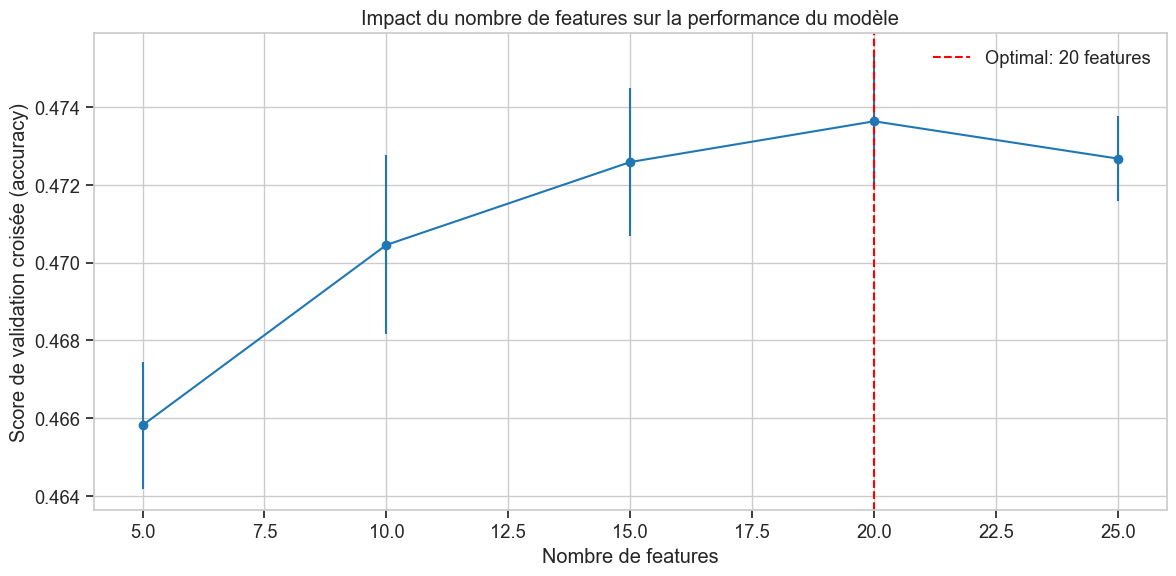


Nombre optimal de features: 20
Top 10 des features optimales:
1. day
2. equity
3. pos_ratio
4. neg_ratio
5. momentum
6. r14
7. r35
8. r49
9. r33
10. r29


In [ ]:
print("\n--- Détermination du nombre optimal de features ---")

# Définir une factory function pour XGBoost
def xgboost_factory():
    """Renvoie une nouvelle instance de XGBoost"""
    return XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        random_state=42
    )

# Mapping pour les étiquettes de classe
mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(mapping)

# Optimisation pour l'approche 2 (généralement plus performante)
feature_ranking = mi_results_all['selected_features']
print("\nOptimisation du nombre de features pour l'approche 2...")

# Pour éviter d'exécuter une optimisation coûteuse, on limite le nombre d'essais
optimization_result = optimize_feature_count(
    X_train_with_financial, y_train_mapped,  # Utiliser les classes mappées
    model_factory=xgboost_factory,
    feature_ranking=feature_ranking,
    n_features_range=range(5, min(101, len(feature_ranking)), 5)
)

# Récupérer le nombre optimal de features et les features correspondantes
optimal_n_features = optimization_result['optimal_n_features']
optimal_features = optimization_result['optimal_features']

print(f"\nNombre optimal de features: {optimal_n_features}")
print(f"Top 10 des features optimales:")
for i, feature in enumerate(optimal_features[:10]):
    print(f"{i+1}. {feature}")


#### 5.7 Optimisation des hyperparamètres de XGBoost

In [ ]:
print("\n--- Optimisation des hyperparamètres de XGBoost ---")

# Définir la grille de paramètres pour XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Utiliser les features optimales pour l'optimisation des hyperparamètres
X_optimal = X_train_with_financial[optimal_features]
X_test_optimal = X_test_with_financial[optimal_features]

# Optimiser XGBoost avec les classes mappées
optimization_result = optimize_hyperparameters(
    xgboost_factory(),
    xgb_param_grid,
    X_optimal,
    y_train_mapped,  # Utiliser les classes mappées
    n_iter=10,  # Réduit pour des raisons de temps
    use_random=True
)

# Récupérer le meilleur modèle et ses paramètres
best_params = optimization_result["best_params"]
best_score = optimization_result["best_score"]

print(f"Meilleur score de validation croisée: {best_score:.4f}")
print("Meilleurs paramètres:")
for param, value in best_params.items():
    print(f"- {param}: {value}")



--- Optimisation des hyperparamètres de XGBoost ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Meilleur score de validation croisée: 0.4756
Temps d'optimisation: 515.06 secondes
Meilleur score de validation croisée: 0.4756
Meilleurs paramètres:
- subsample: 0.8
- n_estimators: 300
- max_depth: 7
- learning_rate: 0.1
- gamma: 0.1
- colsample_bytree: 0.5


#### 5.7.1 Optimisation des hyperparamètres de XGBoost sur les données brutes

Cette étape est une étape de test afin de regarder si l'optimisation du modèle sans features, donc seulement avec les rendements et day, equity permettent de mieux prédire

In [ ]:
raw_dataset_key = "raw" 
print(f"Utilisation du dataset {raw_dataset_key} pour la comparaison")

# Charger les données brutes
X_raw_train, y_raw_train, X_raw_test, y_raw_test = load_dataset_for_analysis(raw_dataset_key, normalize=best_normalize)

# Mapping pour les étiquettes de classe
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_raw_train_mapped = y_raw_train.map(mapping)

# Optimiser XGBoost avec les classes mappées sur le dataset brut
raw_optimization_result = optimize_hyperparameters(
    xgboost_factory(),
    xgb_param_grid,
    X_raw_train,
    y_raw_train_mapped,  # Utiliser les classes mappées
    n_iter=10,  # Réduit pour des raisons de temps
    use_random=True
)

# Récupérer le meilleur modèle et ses paramètres
raw_best_params = raw_optimization_result["best_params"]
raw_best_score = raw_optimization_result["best_score"]

print(f"Meilleur score de validation croisée sur dataset {raw_dataset_key}: {raw_best_score:.4f}")
print(f"Meilleurs paramètres sur dataset {raw_dataset_key}:")
for param, value in raw_best_params.items():
    print(f"- {param}: {value}")

# Créer le modèle XGBoost optimisé sur dataset brut
raw_optimized_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    random_state=42,
    **raw_best_params
)

# Entraîner le modèle
start_train_time = time.time()
raw_optimized_model.fit(X_raw_train, y_raw_train_mapped)  # Utiliser les classes mappées
raw_train_time = time.time() - start_train_time

# Faire des prédictions
start_pred_time = time.time()
raw_y_pred_mapped = raw_optimized_model.predict(X_raw_test)
raw_pred_time = time.time() - start_pred_time

# Reconvertir les prédictions au format original
raw_y_pred = pd.Series(raw_y_pred_mapped).map(inverse_mapping)

# Évaluer les performances
raw_accuracy = accuracy_score(y_raw_test, raw_y_pred)
raw_report = classification_report(y_raw_test, raw_y_pred, output_dict=True)

print(f"\nAccuracy du modèle optimisé sur dataset {raw_dataset_key}: {raw_accuracy:.4f}")
print(f"F1 score pondéré: {raw_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {raw_train_time:.2f}s, Prédiction: {raw_pred_time:.2f}s")

# Ajouter au tracker de résultats
raw_result = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset {raw_dataset_key} avec hyperparamètres optimisés",
    "model": "xgboost_raw_optimized",
    "model_description": f"XGBoost optimisé sur dataset {raw_dataset_key}",
    "features_added": False,
    "feature_sets": ["Aucune"],
    "normalize_by_row": best_normalize,
    "accuracy": raw_accuracy,
    "precision_weighted": raw_report["weighted avg"]["precision"],
    "recall_weighted": raw_report["weighted avg"]["recall"],
    "f1_weighted": raw_report["weighted avg"]["f1-score"],
    "training_time": raw_train_time,
    "prediction_time": raw_pred_time,
    "total_time": raw_train_time + raw_pred_time,
    "notes": f"XGBoost optimisé sur le dataset {raw_dataset_key} brut"
}

results_tracker = add_result(results_tracker, raw_result)

Utilisation du dataset raw pour la comparaison
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Meilleur score de validation croisée: 0.4819
Temps d'optimisation: 798.70 secondes
Meilleur score de validation croisée sur dataset raw: 0.4819
Meilleurs paramètres sur dataset raw:
- subsample: 0.8
- n_estimators: 300
- max_depth: 7
- learning_rate: 0.1
- gamma: 0.1
- colsample_bytree: 0.5

Accuracy du modèle optimisé sur dataset raw: 0.3111
F1 score pondéré: 0.2496
Temps d'entraînement: 59.16s, Prédiction: 2.34s


Accuracy non optimisée : 0.316347

Accuracy optimisée : 0.3111

####  5.8 Évaluation du modèle XGBoost optimisé (Avec Features)


--- Évaluation du modèle XGBoost optimisé ---
Accuracy sur l'ensemble de test: 0.3132
F1 score pondéré: 0.2535
Temps d'entraînement: 29.69s, Prédiction: 2.50s


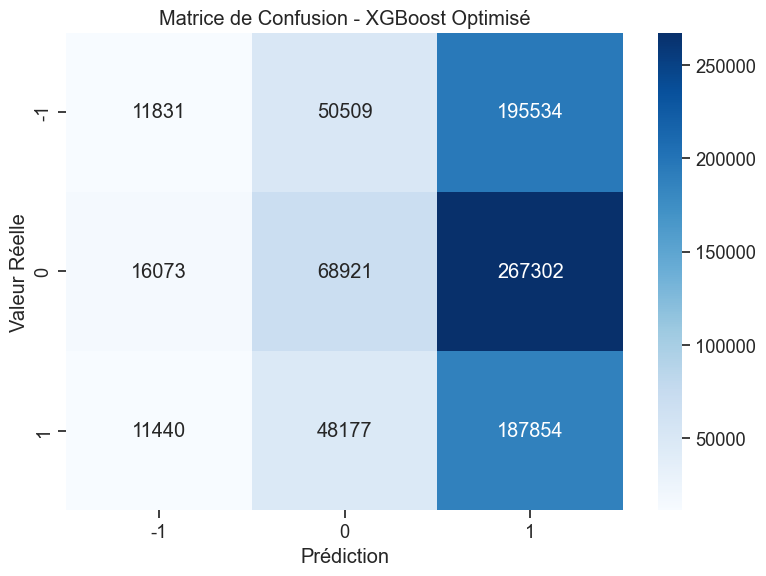

In [ ]:
# Créer le modèle XGBoost optimisé
optimized_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    random_state=42,
    **best_params
)

# Définir le mapping pour les classes
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_train_mapped = y_train.map(mapping)

# Entraîner le modèle
start_train_time = time.time()
optimized_model.fit(X_optimal, y_train_mapped)  # Utiliser les classes mappées
train_time = time.time() - start_train_time

# Faire des prédictions
start_pred_time = time.time()
y_pred_mapped = optimized_model.predict(X_test_optimal)
pred_time = time.time() - start_pred_time

# Reconvertir les prédictions au format original
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

# Évaluer les performances
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print(f"Accuracy sur l'ensemble de test: {accuracy:.4f}")
print(f"F1 score pondéré: {report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {train_time:.2f}s, Prédiction: {pred_time:.2f}s")

# Ajouter au tracker de résultats
result = {
    "dataset": best_dataset,
    "dataset_description": f"{best_configs[0]['description']} avec features optimisées",
    "model": "xgboost_optimized",
    "model_description": f"XGBoost optimisé avec {len(optimal_features)} features",
    "features_added": True,
    "feature_sets": ["Optimisées"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy,
    "precision_weighted": report["weighted avg"]["precision"],
    "recall_weighted": report["weighted avg"]["recall"],
    "f1_weighted": report["weighted avg"]["f1-score"],
    "training_time": train_time,
    "prediction_time": pred_time,
    "total_time": train_time + pred_time,
    "notes": f"Optimisé avec {optimal_n_features} features et hyperparamètres"
}

results_tracker = add_result(results_tracker, result)

# Matrice de confusion
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title('Matrice de Confusion - XGBoost Optimisé')
plt.xlabel('Prédiction')
plt.ylabel('Valeur Réelle')
plt.tight_layout()
plt.show()

#### 5.9 Analyse SHAP pour interpréter le modèle


--- Analyse SHAP pour l'interprétation du modèle ---


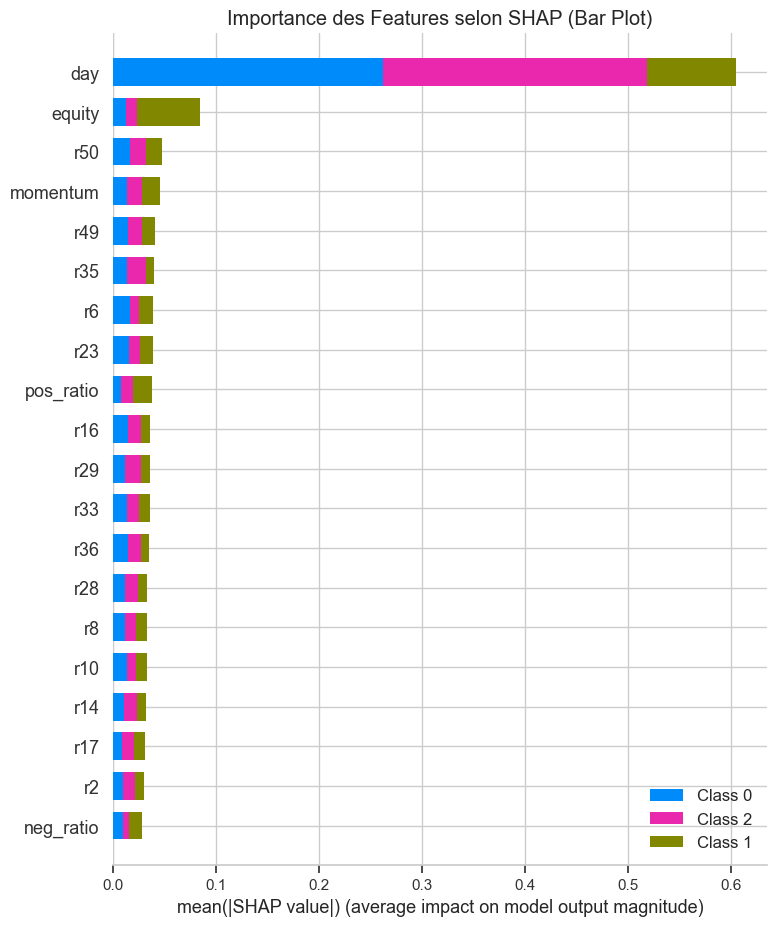

<Figure size 1200x1000 with 0 Axes>

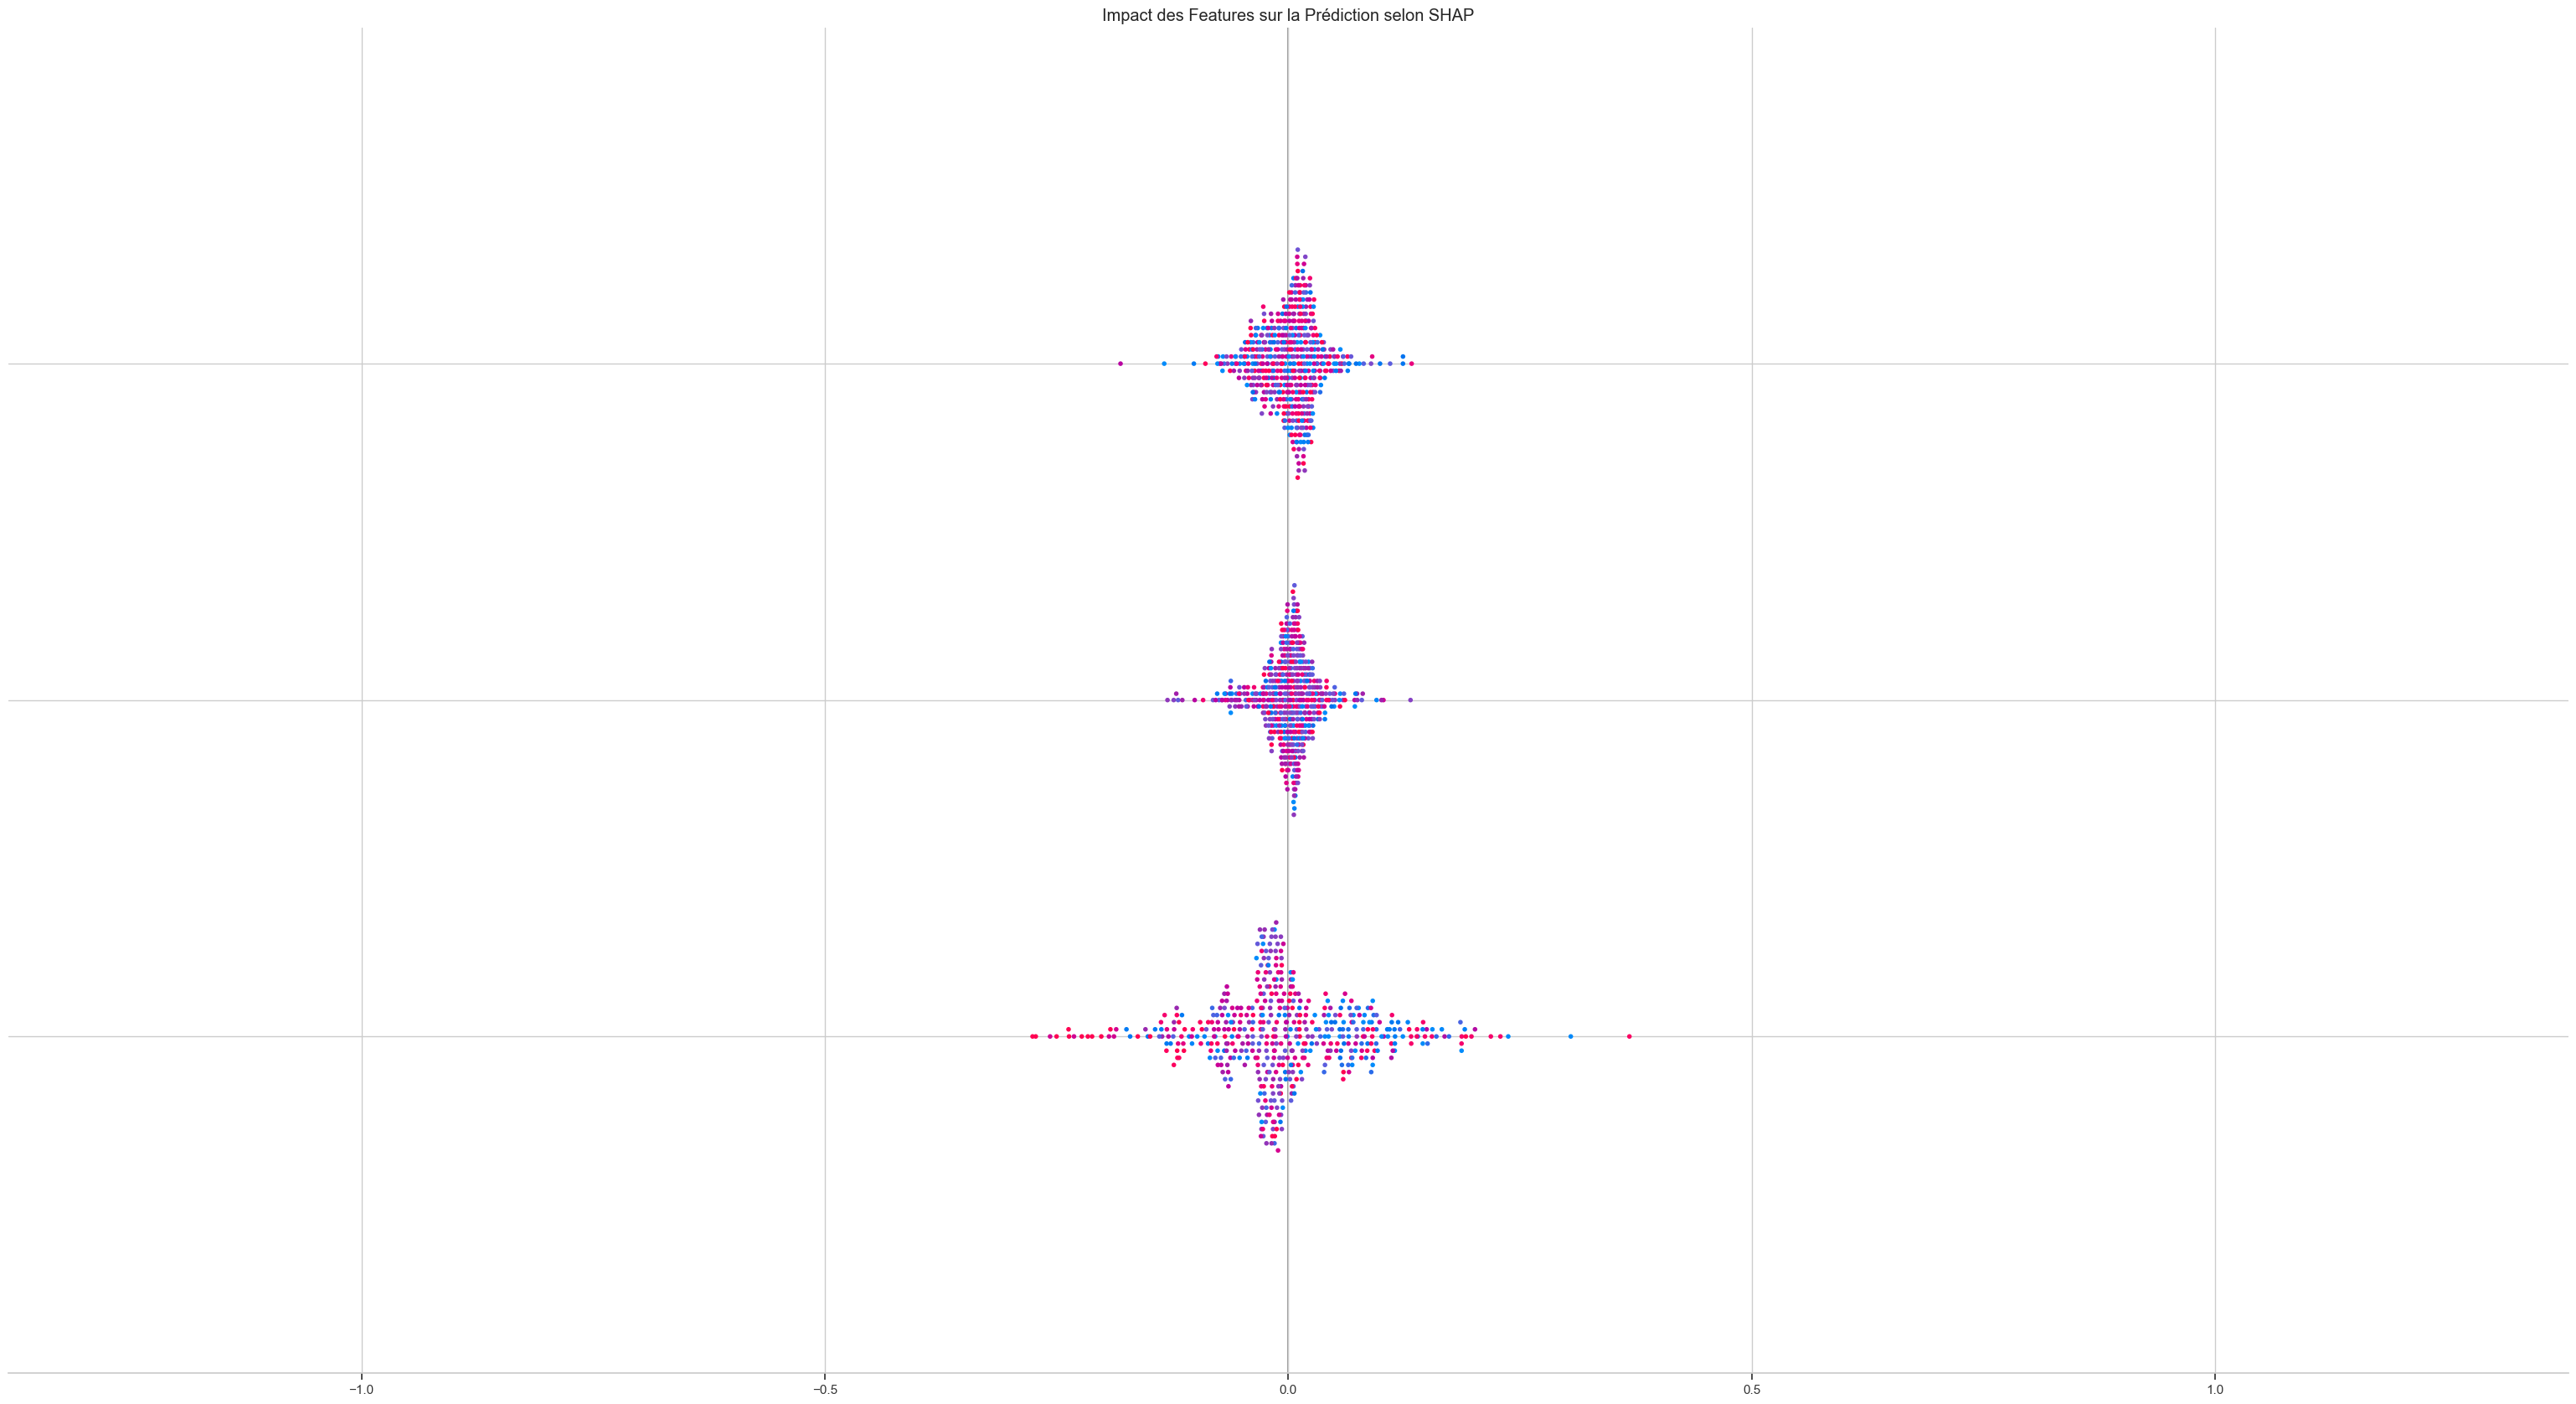

Analyse SHAP complétée avec succès


In [ ]:
print("\n--- Analyse SHAP pour l'interprétation du modèle ---")

try:
    # Import shap if available
    import shap
    
    # Réduire l'échantillon pour l'analyse SHAP
    sample_size = min(500, len(X_optimal))
    X_train_sample = X_optimal.sample(sample_size, random_state=42)
    
    # Analyser le modèle avec SHAP
    shap_values, explainer = analyze_with_shap(optimized_model, X_train_sample)
    
    if shap_values is not None:
        # Visualiser le résumé des valeurs SHAP (Bar Plot)
        plot_shap_summary(shap_values, X_train_sample, plot_type="bar")
        
        # Visualiser l'impact détaillé des features (Dot Plot)
        plot_shap_summary(shap_values, X_train_sample, plot_type="dot")
        
        print("Analyse SHAP complétée avec succès")
    else:
        print("Impossible de calculer les valeurs SHAP")
        
except ImportError:
    print("La bibliothèque SHAP n'est pas installée. Utilisez 'pip install shap' pour l'installer.")
except Exception as e:
    print(f"Erreur lors de l'analyse SHAP: {e}")

#### 5.10 Comparaison avec le modèle de référence


--- Comparaison avec les modèles de référence ---
Modèle de référence (XGBoost baseline): Accuracy = 0.3185
Modèle optimisé sur données brutes (raw): Accuracy = 0.3111
Modèle optimisé avec sélection de features: Accuracy = 0.3132
Amélioration avec sélection de features: -0.0053 (-0.53%)
Amélioration avec optimisation sur données brutes: -0.0073 (-0.73%)


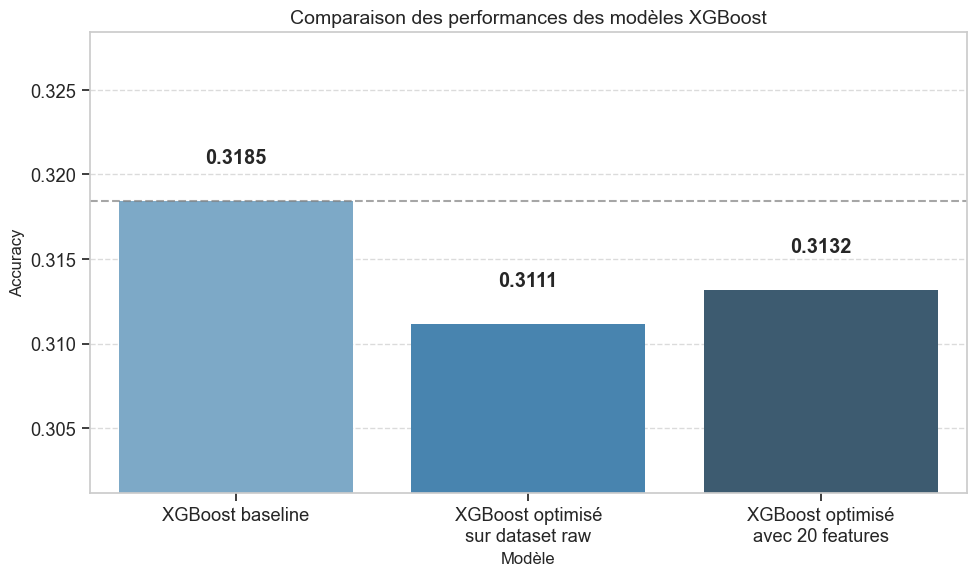

In [ ]:
# 5.12 Comparaison avec les modèles de référence
print("\n--- Comparaison avec les modèles de référence ---")

# Récupérer les performances du modèle de référence baseline
benchmark_model = next((r for r in results_tracker.to_dict('records') 
                        if r['dataset'] == best_dataset and 
                        r['model'] == 'xgboost_baseline' and 
                        r['normalize_by_row'] == best_normalize), None)

# Récupérer les performances du modèle optimisé sur données brutes
raw_optimized_model = next((r for r in results_tracker.to_dict('records') 
                           if r['dataset'] == raw_dataset_key and 
                           r['model'] == 'xgboost_raw_optimized' and 
                           r['normalize_by_row'] == best_normalize), None)

if benchmark_model and raw_optimized_model:
    benchmark_accuracy = benchmark_model["accuracy"]
    raw_opt_accuracy = raw_optimized_model["accuracy"]
    
    improvement_features = accuracy - benchmark_accuracy
    improvement_raw = raw_opt_accuracy - benchmark_accuracy
    
    print(f"Modèle de référence (XGBoost baseline): Accuracy = {benchmark_accuracy:.4f}")
    print(f"Modèle optimisé sur données brutes ({raw_dataset_key}): Accuracy = {raw_opt_accuracy:.4f}")
    print(f"Modèle optimisé avec sélection de features: Accuracy = {accuracy:.4f}")
    print(f"Amélioration avec sélection de features: {improvement_features:.4f} ({improvement_features*100:.2f}%)")
    print(f"Amélioration avec optimisation sur données brutes: {improvement_raw:.4f} ({improvement_raw*100:.2f}%)")
    
    # Visualiser la comparaison avec un graphique amélioré
    plt.figure(figsize=(10, 6))
    comparison_data = pd.DataFrame([
        {"Modèle": "XGBoost baseline", "Accuracy": benchmark_accuracy},
        {"Modèle": f"XGBoost optimisé\nsur dataset {raw_dataset_key}", "Accuracy": raw_opt_accuracy},
        {"Modèle": f"XGBoost optimisé\navec {optimal_n_features} features", "Accuracy": accuracy}
    ])
    
    # Créer le barplot avec bordures distinctes
    ax = sns.barplot(x="Modèle", y="Accuracy", data=comparison_data, palette="Blues_d")
    
    # Ajouter une ligne horizontale à l'accuracy du modèle de référence
    plt.axhline(y=benchmark_accuracy, color='gray', linestyle='--', alpha=0.7)
    
    # Ajouter les valeurs sur les barres
    for i, row in comparison_data.iterrows():
        plt.text(i, row["Accuracy"] + 0.002, f"{row['Accuracy']:.4f}", 
                ha='center', va='bottom', fontweight='bold')
    
    # Améliorer la présentation du graphique
    plt.title('Comparaison des performances des modèles XGBoost', fontsize=14)
    plt.xlabel('Modèle', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    # Définir des limites raisonnables pour l'axe y
    min_accuracy = min(benchmark_accuracy, accuracy, raw_opt_accuracy) - 0.01
    max_accuracy = max(benchmark_accuracy, accuracy, raw_opt_accuracy) + 0.01
    plt.ylim(min_accuracy, max_accuracy)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
else:
    print("Impossible de trouver un modèle de référence comparable pour la comparaison.")

##### Analyse des résultats de la modélisation prédictive des rendements financiers

**Sélection de features et importance des variables**

L'analyse de sélection des features a révélé plusieurs insights importants :

**Prédominance des variables catégorielles** : Les variables day et equity se démarquent nettement comme les plus informatives (scores d'information mutuelle respectifs de 0.12 et 0.03), loin devant toutes les autres features qui ont des scores inférieurs à 0.004 avec une forte dominance temporelle. Cette prépondérance suggère que les caractéristiques temporelles et les spécificités des actions individuelles influencent fortement le comportement des rendements.

**Importance des métriques agrégées** : Les ratios de tendance (pos_ratio, neg_ratio) et les indicateurs dérivés comme le momentum et le sharpe_ratio se classent parmi les features les plus importantes, avant même les rendements individuels. Ce résultat n'est pas surprenant mais cela n'implique pas réellement qu'ils permettent de mieux prédire pour autant puisque le XGBoost sans features obtient un meilleur score.

**Analyse SHAP et interprétabilité**

L'analyse SHAP confirme et complète les observations précédentes :

***Confirmation de l'importance des variables contextuelles*** : La variable **day** domine largement les autres en termes d'impact sur les prédictions, suivie par equity. Cela renforce l'hypothèse que le contexte temporel et les caractéristiques propres à chaque action sont des déterminants majeurs.

Différenciation par classe : Les variables ont des impacts différents selon les classes de prédiction (baisse, stable, hausse), comme le montre la répartition des couleurs sur le graphique SHAP. Par exemple, certaines features semblent spécifiquement importantes pour prédire la classe 1 (hausse).

Distribution des effets : Le graphique SHAP en points montre une distribution complexe des effets des features, avec des patterns distinctifs pour les principales variables. Ceci révèle des relations non-linéaires entre les variables et les prédictions.

**Surapprentissage et performances des modèles**

Le problème le plus significatif observé est l'écart important entre les performances en validation croisée et sur l'ensemble de test :

**Écart validation/test important** : Les scores de validation croisée atteignent 0.48 alors que les performances sur l'ensemble de test plafonnent autour de 0.31, indiquant un surapprentissage prononcé.

Dégradation avec l'optimisation : Contre-intuitivement, l'optimisation des hyperparamètres et la sélection de features n'améliorent pas les performances sur l'ensemble de test, mais les dégradent légèrement (baseline : 0.3185, optimisé : 0.3132, raw optimisé : 0.3111).

Causes probables :

La séparation stricte entre les jours et actions des ensembles d'entraînement et de test crée un défi de généralisation majeur
Les hyperparamètres optimisés (max_depth=7, n_estimators=300) favorisent potentiellement la mémorisation des données d'entraînement
L'utilisation excessive des variables day et equity pourrait empêcher le modèle d'apprendre des patterns généralisables


Cette analyse suggère plusieurs pistes d'amélioration :

Réduction de la complexité des modèles : Limiter la profondeur des arbres et augmenter la régularisation pourrait aider à réduire le surapprentissage.
Approaches alternatives de feature engineering :

Créer des features plus généralisables qui capturent des patterns indépendants du jour ou de l'action spécifique
Explorer des transformations temporelles relatives plutôt qu'absolues
Considérer des variables macroéconomiques ou sectorielles pour enrichir le contexte


**Stratégies d'entraînement adaptées :**

Implémenter une validation temporelle plus représentative du problème réel
Explorer des approches d'ensemble combinant différents niveaux de complexité
Tester l'apprentissage par transfert pour mieux généraliser entre différentes actions

En conclusion, ce cas illustre parfaitement les défis inhérents à la prédiction financière : la non-stationnarité des données, la difficulté de généralisation entre différents instruments et périodes, et la propension des modèles à capturer du bruit plutôt que du signal. Ces résultats, bien que modestes en termes de performance prédictive, offrent néanmoins des insights précieux sur les limites des approches d'apprentissage automatique dans ce domaine.

#### 5.11 Analyse supplémentaire sans Equity & Day et Top Features 

On a choisi d'effectuer un dernier test, cette fois-ci on conserve le dataframe de base (raw) avec des lignes contenant seulement 70%+ de non NaN mais en retirant la composante temporelle et equity afin que le modèle apprennne seulement des relations des rendements et des rendements avec les top features. 

In [ ]:
# Charger les données sans day et equity
raw_dataset_key = "low_nan"  
print(f"\n--- Test du modèle sans day et equity sur dataset {raw_dataset_key} ---")
X_raw_train_no_day, y_raw_train, X_raw_test_no_day, y_raw_test = load_dataset_without_day_id(raw_dataset_key, normalize=best_normalize)

# Mapping pour les étiquettes de classe
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_raw_train_mapped = y_raw_train.map(mapping)

# Optimiser XGBoost sans day ni equity
no_day_optimization_result = optimize_hyperparameters(
    xgboost_factory(),
    xgb_param_grid,
    X_raw_train_no_day,
    y_raw_train_mapped,
    n_iter=10,
    use_random=True
)

# Récupérer le meilleur modèle et ses paramètres
no_day_best_params = no_day_optimization_result["best_params"]
no_day_best_score = no_day_optimization_result["best_score"]

print(f"Meilleur score de validation croisée (sans day ni equity): {no_day_best_score:.4f}")
print(f"Meilleurs paramètres:")
for param, value in no_day_best_params.items():
    print(f"- {param}: {value}")

# Créer et entraîner le modèle
no_day_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    random_state=42,
    **no_day_best_params
)

start_train_time = time.time()
no_day_model.fit(X_raw_train_no_day, y_raw_train_mapped)
no_day_train_time = time.time() - start_train_time

# Faire des prédictions
start_pred_time = time.time()
no_day_y_pred_mapped = no_day_model.predict(X_raw_test_no_day)
no_day_pred_time = time.time() - start_pred_time

# Reconvertir les prédictions
no_day_y_pred = pd.Series(no_day_y_pred_mapped).map(inverse_mapping)

# Évaluer les performances
no_day_accuracy = accuracy_score(y_raw_test, no_day_y_pred)
no_day_report = classification_report(y_raw_test, no_day_y_pred, output_dict=True)

print(f"\nAccuracy du modèle sans day ni ID: {no_day_accuracy:.4f}")
print(f"F1 score pondéré: {no_day_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {no_day_train_time:.2f}s, Prédiction: {no_day_pred_time:.2f}s")

# Ajouter au tracker de résultats
no_day_result = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset {raw_dataset_key} sans day ni equity",
    "model": "xgboost_no_day_id",
    "model_description": "XGBoost optimisé sans day ni ID",
    "features_added": False,
    "feature_sets": ["Sans day/ID"],
    "normalize_by_row": best_normalize,
    "accuracy": no_day_accuracy,
    "precision_weighted": no_day_report["weighted avg"]["precision"],
    "recall_weighted": no_day_report["weighted avg"]["recall"],
    "f1_weighted": no_day_report["weighted avg"]["f1-score"],
    "training_time": no_day_train_time,
    "prediction_time": no_day_pred_time,
    "total_time": no_day_train_time + no_day_pred_time,
    "notes": "XGBoost sans variables contextuelles day et equity"
}

results_tracker = add_result(results_tracker, no_day_result)


--- Test du modèle sans day et ID sur dataset low_nan ---
Données chargées sans day et ID - Dimensions: (730784, 54)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Meilleur score de validation croisée: 0.4129
Temps d'optimisation: 937.27 secondes
Meilleur score de validation croisée (sans day ni ID): 0.4129
Meilleurs paramètres:
- subsample: 0.8
- n_estimators: 300
- max_depth: 7
- learning_rate: 0.1
- gamma: 0.1
- colsample_bytree: 0.5

Accuracy du modèle sans day ni ID: 0.3832
F1 score pondéré: 0.3210
Temps d'entraînement: 60.97s, Prédiction: 2.30s



--- Test du modèle avec rendements + features financières sur dataset raw ---
Ajout de 8 nouvelles features financières
Ajout de 8 nouvelles features financières
Sélection de 61 features (53 rendements + 9 financières)
Features financières: ['equity', 'pos_ratio', 'neg_ratio', 'momentum', 'sharpe_ratio', 'volatility_20', 'volatility_30', 'volatility_10', 'trend_slope']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Meilleur score de validation croisée: 0.4109
Temps d'optimisation: 912.70 secondes
Meilleur score de validation croisée (features financières): 0.4109
Meilleurs paramètres:
- subsample: 0.8
- n_estimators: 300
- max_depth: 7
- learning_rate: 0.1
- gamma: 0.1
- colsample_bytree: 0.5

Accuracy du modèle avec features financières: 0.3605
F1 score pondéré: 0.3424
Temps d'entraînement: 68.96s, Prédiction: 2.49s


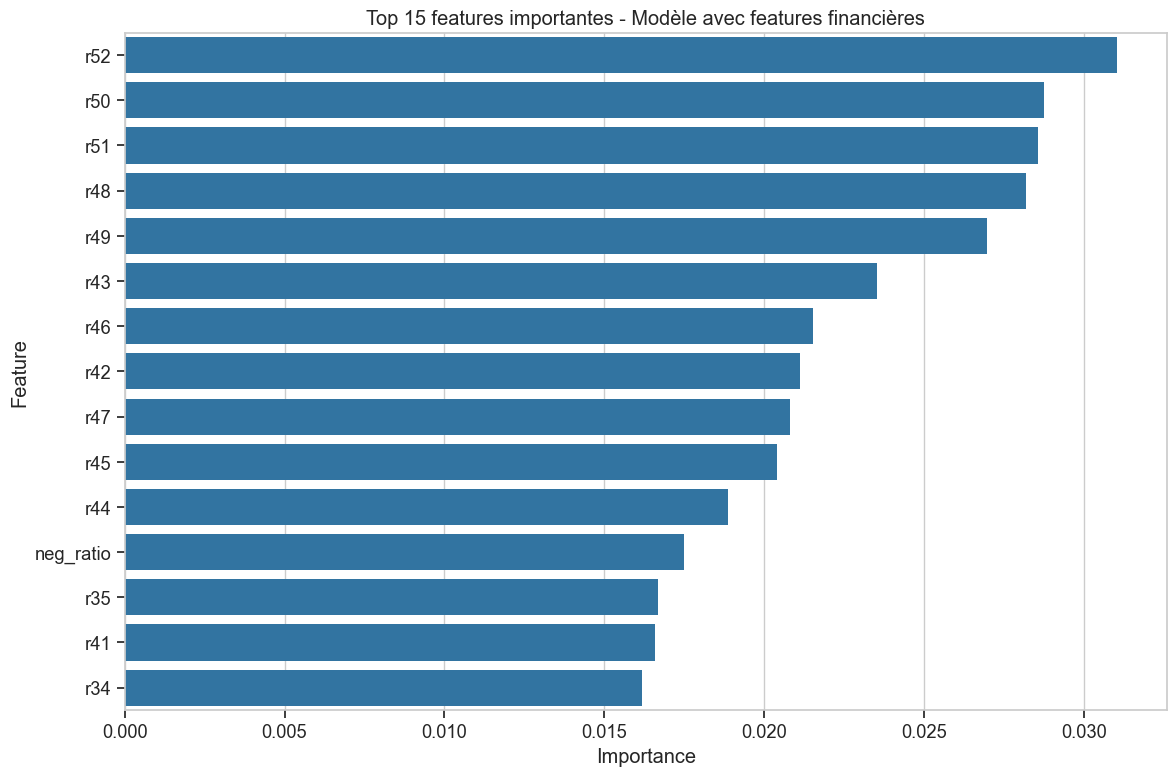

In [ ]:
# Charger les données
raw_dataset_key = "raw"
print(f"\n--- Test du modèle avec rendements + features financières sur dataset {raw_dataset_key} ---")
X_raw_train_full, y_raw_train, X_raw_test_full, y_raw_test = load_dataset_for_analysis(raw_dataset_key, normalize=best_normalize)

# Ajouter les features financières
X_raw_train_with_financial = add_financial_features(X_raw_train_full)
X_raw_test_with_financial = add_financial_features(X_raw_test_full)

# Sélectionner les features pertinentes
X_raw_train_selected, X_raw_test_selected = select_financial_and_rendements(
    X_raw_train_with_financial, 
    X_raw_test_with_financial
)

# Mapping pour les étiquettes de classe
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_raw_train_mapped = y_raw_train.map(mapping)

# Optimiser XGBoost avec les features sélectionnées
fin_features_optimization_result = optimize_hyperparameters(
    xgboost_factory(),
    xgb_param_grid,
    X_raw_train_selected,
    y_raw_train_mapped,
    n_iter=10,
    use_random=True
)

# Récupérer le meilleur modèle et ses paramètres
fin_features_best_params = fin_features_optimization_result["best_params"]
fin_features_best_score = fin_features_optimization_result["best_score"]

print(f"Meilleur score de validation croisée (features financières): {fin_features_best_score:.4f}")
print(f"Meilleurs paramètres:")
for param, value in fin_features_best_params.items():
    print(f"- {param}: {value}")

# Créer et entraîner le modèle
fin_features_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    random_state=42,
    **fin_features_best_params
)

start_train_time = time.time()
fin_features_model.fit(X_raw_train_selected, y_raw_train_mapped)
fin_features_train_time = time.time() - start_train_time

# Faire des prédictions
start_pred_time = time.time()
fin_features_y_pred_mapped = fin_features_model.predict(X_raw_test_selected)
fin_features_pred_time = time.time() - start_pred_time

# Reconvertir les prédictions
fin_features_y_pred = pd.Series(fin_features_y_pred_mapped).map(inverse_mapping)

# Évaluer les performances
fin_features_accuracy = accuracy_score(y_raw_test, fin_features_y_pred)
fin_features_report = classification_report(y_raw_test, fin_features_y_pred, output_dict=True)

print(f"\nAccuracy du modèle avec features financières: {fin_features_accuracy:.4f}")
print(f"F1 score pondéré: {fin_features_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {fin_features_train_time:.2f}s, Prédiction: {fin_features_pred_time:.2f}s")

# Visualiser l'importance des features
plt.figure(figsize=(12, 8))
features_importance = fin_features_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_raw_train_selected.columns,
    'Importance': features_importance
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 features importantes - Modèle avec features financières')
plt.tight_layout()
plt.show()

# Ajouter au tracker de résultats
fin_features_result = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset {raw_dataset_key} avec features financières",
    "model": "xgboost_financial_features",
    "model_description": "XGBoost optimisé avec rendements et features financières",
    "features_added": True,
    "feature_sets": ["Rendements + Financières"],
    "normalize_by_row": best_normalize,
    "accuracy": fin_features_accuracy,
    "precision_weighted": fin_features_report["weighted avg"]["precision"],
    "recall_weighted": fin_features_report["weighted avg"]["recall"],
    "f1_weighted": fin_features_report["weighted avg"]["f1-score"],
    "training_time": fin_features_train_time,
    "prediction_time": fin_features_pred_time,
    "total_time": fin_features_train_time + fin_features_pred_time,
    "notes": "XGBoost avec rendements et features financières sélectionnées"
}

results_tracker = add_result(results_tracker, fin_features_result)

In [ ]:
# Comparaison des différentes approches
print("\n--- Comparaison des différentes approches de modélisation ---")

# Sélectionner les modèles pertinents pour la comparaison
comparison_models = [
    {"model": "xgboost_baseline", "name": "XGBoost Baseline", "description": "Modèle de base avec toutes les features"},
    {"model": "xgboost_raw_optimized", "name": "XGBoost Raw Optimisé", "description": "Modèle optimisé sur dataset brut"},
    {"model": "xgboost_optimized", "name": "XGBoost Features Optimisées", "description": "Modèle avec 20 features optimales"},
    {"model": "xgboost_no_day_id", "name": "XGBoost Sans Day/ID", "description": "Modèle sans day ni ID"},
    {"model": "xgboost_financial_features", "name": "XGBoost Features Financières", "description": "Modèle avec rendements et features financières"}
]

# Extraire les résultats correspondants
comparison_results = []
for model_info in comparison_models:
    model_key = model_info["model"]
    # Chercher le modèle dans les résultats
    model_result = next((r for r in results_tracker.to_dict('records') if r['model'] == model_key), None)
    if model_result:
        comparison_results.append({
            "Modèle": model_info["name"],
            "Description": model_info["description"],
            "Accuracy": model_result["accuracy"],
            "F1 Score": model_result["f1_weighted"],
            "Temps total (s)": model_result["total_time"] if "total_time" in model_result else None
        })

# Créer un DataFrame pour la comparaison
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values("Accuracy", ascending=False)

print("Résultats de performance:")
display(comparison_df)

# Visualiser la comparaison
plt.figure(figsize=(12, 6))
sns.barplot(x="Modèle", y="Accuracy", data=comparison_df)
plt.title('Comparaison des performances des modèles')
plt.xlabel('Modèle')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Visualiser la comparaison des temps d'exécution
plt.figure(figsize=(12, 6))
sns.barplot(x="Modèle", y="Temps total (s)", data=comparison_df)
plt.title('Comparaison des temps d\'exécution')
plt.xlabel('Modèle')
plt.ylabel('Temps total (secondes)')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("\n--- Analyse des performances en fonction des approches de modélisation ---")
print(f"Meilleur modèle: {comparison_df.iloc[0]['Modèle']} avec une accuracy de {comparison_df.iloc[0]['Accuracy']:.4f}")

baseline_accuracy = next((r['Accuracy'] for r in comparison_results if r['Modèle'] == "XGBoost Baseline"), None)
if baseline_accuracy:
    for i, row in comparison_df.iterrows():
        if row['Modèle'] != "XGBoost Baseline":
            diff = row['Accuracy'] - baseline_accuracy
            print(f"{row['Modèle']}: {diff:.4f} ({diff*100:.2f}% par rapport à la baseline)")



Le fait de retirer la composante temporelle et l'equity a permis au modèle de contrôler le sur-apprentissage et mieux s'adapter à de nouvelles données, même sans l'utilisation de nouvelles features. 

Cette dernière remarque est assez pertinent parce qu'il permet au modèle de s'adapter non seulement aux nouvelles données, c'est à dire les mêmes actifs à des dates différentes, mais également des actifs différents, comme c'est le cas dans le jeu de données de test.

Il est important de souligner qu'avec l'analyse avec les features financières et des rendements qu'on observe que les features les plus importantes sont les rendements de fin de journée et que ces dernières ont plus de poids explicatif que des métriques agrégées. Cependant, il reste assez important de souligner, que la création de features, dans le cas du XGBoost, n'améliore pas, voire dégrade les performances du modèle. 

Nous conserverons quand même les features par la suite. 

## 6. Modèles non supervisés

Dans cette section, nous explorons l'utilisation de méthodes d'apprentissage non supervisé pour détecter des structures latentes dans les données. Notre objectif est d'identifier des configurations de marché similaires qui pourraient nous aider à mieux prédire les mouvements de prix en fin de journée.

Contrairement aux approches supervisées précédentes qui s'appuient directement sur la relation entre les rendements (pour rappel : 9h-14h) et la direction du prix en fin de journée, les méthodes non supervisées cherchent à identifier des regroupements naturels dans nos données, sans tenir compte de la variable cible. Ces regroupements peuvent révéler des dynamiques de marché que les approches supervisées ne capturent pas directement.

Notre intuition est que certaines configurations de rendements peuvent présenter des caractéristiques communes qui se traduisent par des comportements similaires en fin de journée. En identifiant ces configurations, nous pouvons potentiellement enrichir nos modèles de classification avec une nouvelle dimension d'information.

Nous avons choisi d'explorer deux algorithmes de clustering complémentaires: K-means, qui recherche des groupes sphériques basés sur la distance euclidienne, et DBSCAN, qui identifie des clusters de forme arbitraire basés sur la densité des points. Ces deux approches offrent des perspectives différentes sur la structure de nos données financières.

Notre méthodologie comprend plusieurs étapes: nous préparons d'abord les données en excluant les variables contextuelles (day et equity) qui pourraient biaiser le clustering, puis nous appliquons les algorithmes sur les données brutes et sur leurs projections dans un espace réduit via PCA. Enfin, nous évaluons l'apport prédictif des clusters identifiés en les intégrant comme features additionnelles dans nos modèles supervisés.

Le temps de calcul considérable requis par K-means (plus de 10 heures d'exécution sur notre jeu de données) soulève des questions importantes concernant l'équilibre entre gain de performance et coût computationnel, une considération cruciale dans un contexte de trading algorithmique où les décisions doivent souvent être prises rapidement.

###  6.1 Préparation des données

Nous allons conserver la structure de donnée la plus simple qui s'est avérée l'une des plus efficaces malgré sa simplicité. Nous conservons les features financières optimisées (celles qui ont été sélectionnés comme les plus importantes dans la partie 5) ainsi que l'ensemble des rendements en retirant equity et day.  L'objectif est de capturer les patterns intrinsèques aux rendements sans être influencé par le jour ou l'action spécifique.

In [34]:
print("\n--- Préparation des données pour les modèles non supervisés ---")


# Charger les données
raw_dataset_key = "raw"
X_raw_train_full, y_raw_train, X_raw_test_full, y_raw_test = load_dataset_for_analysis(raw_dataset_key, normalize=True)

# Sélectionner les features optimisées sans day ni equity
X_optimized, X_test_optimized = select_optimized_features_no_day_equity(X_raw_train_full, X_raw_test_full)



--- Préparation des données pour les modèles non supervisés ---
Ajout de 8 nouvelles features financières
Ajout de 8 nouvelles features financières
Sélection de 61 features sans day ni equity
Features financières: pos_ratio, neg_ratio, momentum, sharpe_ratio, volatility_20, volatility_30, volatility_10, trend_slope


### 6.2 Préparation des deux approches de clustering

Number of components to reach 90% variance: 1


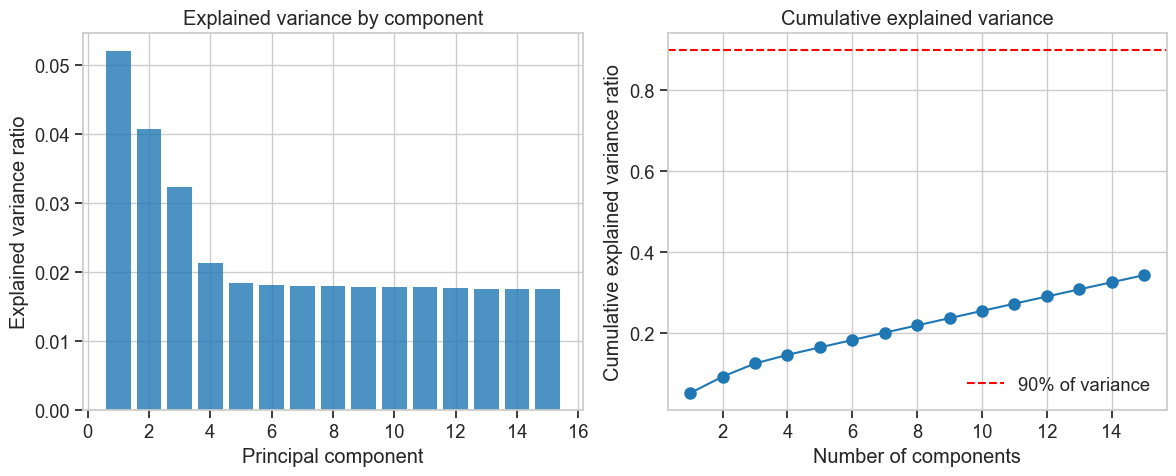

In [35]:
# Normaliser les données
scaler = StandardScaler()
X_optimized_scaled = scaler.fit_transform(X_optimized)
X_test_optimized_scaled = scaler.transform(X_test_optimized)

# PCA
n_components = min(15, X_optimized.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_optimized_scaled)
X_test_pca = pca.transform(X_test_optimized_scaled)

# Analyse de la varance expliquée 
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Nombre de composantes pour 90% de variance
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components to reach 90% variance: {n_components_90}")

# Visualisation
plt.figure(figsize=(12, 5))

# Variance expliquée par composante
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8)
plt.title('Explained variance by component')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.grid(True)

# Variance expliquée cumulée
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', markersize=8)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% of variance')
plt.title('Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


***Rien de nouveau à l'horizon mon capitaine !***

###  6.3 Comparaison PCA et Features Optimisées - K means 

Nous avons implémenté K-means sur deux types de données : directement sur les features optimisées et sur leur projection dans l'espace PCA. Cette approche permet de regrouper les observations similaires, créant ainsi une feature catégorielle potentiellement informative pour la classification. Bien que conceptuellement simple, K-means s'est révélé extrêmement gourmand en ressources computationnelles dans notre contexte (temps d'exécution de plus de 10 heures) - un élément à considérer sérieusement lors de la mise en production.

Le choix du nombre optimal de clusters a été déterminé par la méthode du coude et le score de silhouette, révélant une structure sous-jacente de 3-4 clusters dans nos données. Toutefois, la visualisation des clusters montre une superposition significative avec les classes à prédire, suggérant que la structure latente ne se superpose que partiellement avec notre variable cible.

Après un premier essai : ***Limites du K-means pour notre projet financier***

L'utilisation de l'échantillonnage et l'optimisation des paramètres pour K-means soulignent une limitation fondamentale de cet algorithme dans notre contexte de prédiction financière. K-means présente plusieurs inconvénients qui le rendent sous-optimal pour notre cas d'usage :

Premièrement, K-means impose une structure sphérique aux clusters, supposant que les données financières se regroupent naturellement en cercles ou hypersphères de taille similaire. Cette hypothèse est rarement valide dans les marchés financiers, où les configurations de rendements peuvent former des structures complexes et de densités variables. Les mouvements de marché présentent souvent des relations non-linéaires et des corrélations conditionnelles qui échappent à cette géométrie simplifiée.

Deuxièmement, la complexité computationnelle de K-means devient prohibitive sur nos jeux de données volumineux, nécessitant des compromis comme l'échantillonnage qui peuvent biaiser les résultats. Cette contrainte est particulièrement problématique en finance où chaque observation peut contenir des signaux précieux - l'échantillonnage risque d'éliminer des configurations de marché rares mais informatives. Dans un environnement de trading où la rapidité de décision est cruciale, un algorithme aussi coûteux en calcul constitue un handicap opérationnel significatif.

Enfin, K-means nécessite de spécifier a priori le nombre de clusters, une information que nous ne possédons pas dans le contexte des rendements financiers. Les marchés peuvent présenter un nombre variable d'états ou de régimes selon les conditions macroéconomiques, la liquidité ou le sentiment des investisseurs. Des approches plus flexibles comme DBSCAN, qui déterminent automatiquement le nombre de clusters basés sur la densité des données, correspondent mieux à la nature dynamique et imprévisible des marchés financiers.

Nous réessayons ce dernier sur un échantillon aléatoire et en réduisant le nombre de clusters.


--- Préparation du clustering K-means avec échantillonnage ---
Données échantillonnées: 10000 exemples sur 730784 (1.4%)
Paramètres K-means: k_range=[2, 3, 4, 5], n_init=3

Testant différentes valeurs de k...


  0%|          | 0/4 [00:00<?, ?it/s]


Analyse avec k=2 clusters:
  K-means sur PCA: calcul en cours...


  File "c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  K-means sur PCA: terminé - inertie=189370.01, silhouette=0.0943
  K-means sur features optimisées: calcul en cours...


 25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

  K-means sur features optimisées: terminé - inertie=585305.48, silhouette=0.0346

Analyse avec k=3 clusters:
  K-means sur PCA: calcul en cours...
  K-means sur PCA: terminé - inertie=176463.74, silhouette=0.0945
  K-means sur features optimisées: calcul en cours...


 50%|█████     | 2/4 [00:06<00:05,  2.97s/it]

  K-means sur features optimisées: terminé - inertie=572296.41, silhouette=0.0234

Analyse avec k=4 clusters:
  K-means sur PCA: calcul en cours...
  K-means sur PCA: terminé - inertie=169169.36, silhouette=0.0841
  K-means sur features optimisées: calcul en cours...


 75%|███████▌  | 3/4 [00:08<00:02,  2.83s/it]

  K-means sur features optimisées: terminé - inertie=564899.68, silhouette=0.0176

Analyse avec k=5 clusters:
  K-means sur PCA: calcul en cours...
  K-means sur PCA: terminé - inertie=164002.99, silhouette=0.0724
  K-means sur features optimisées: calcul en cours...


100%|██████████| 4/4 [00:11<00:00,  2.84s/it]

  K-means sur features optimisées: terminé - inertie=559314.56, silhouette=0.0083


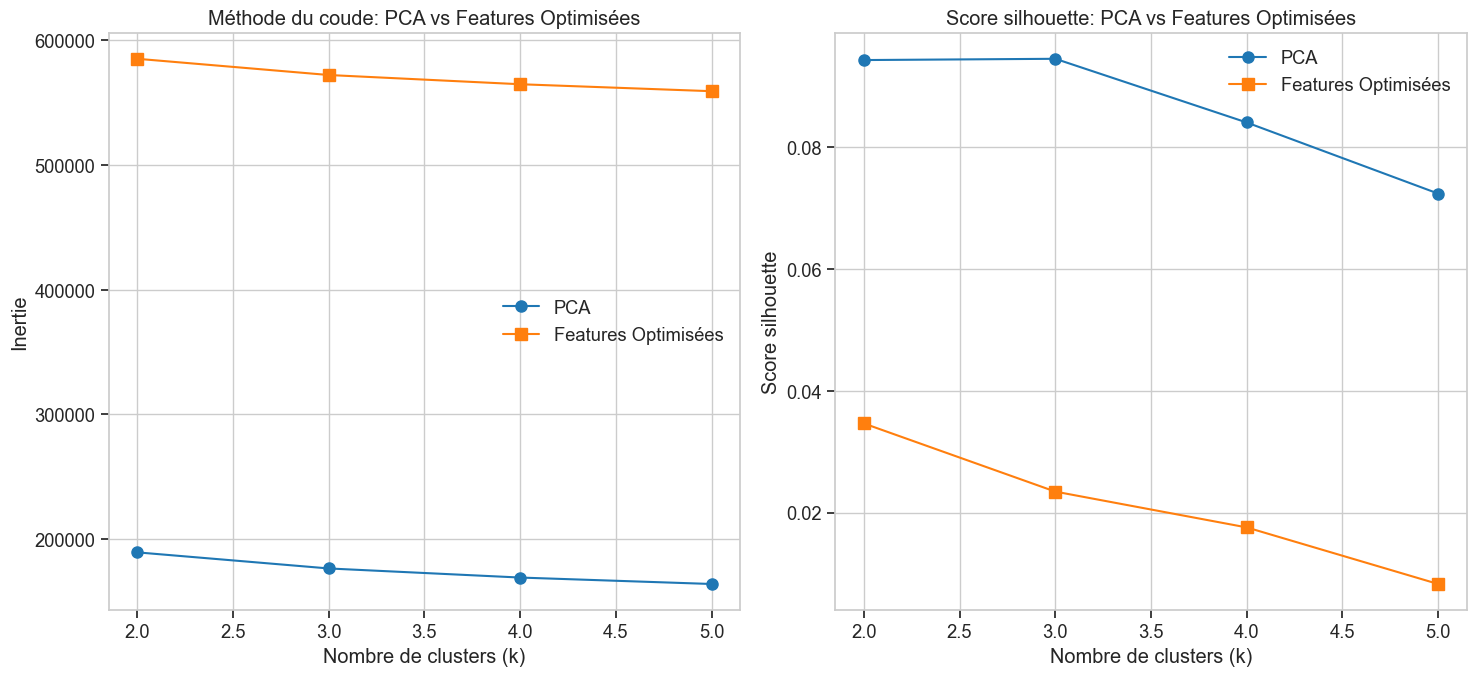

Nombre optimal de clusters (PCA): 3
Nombre optimal de clusters (Features Optimisées): 2

Application du clustering optimal sur l'ensemble des données...
K-means PCA avec 3 clusters: calcul en cours...
K-means PCA: terminé
K-means sur features optimisées avec 2 clusters: calcul en cours...
K-means sur features optimisées: terminé
Clustering K-means terminé avec succès.


In [36]:
print("\n--- Préparation du clustering K-means avec échantillonnage ---")

# Paramètres d'échantillonnage et optimisation
sample_size = min(10000, len(X_optimized))  # Limiter à 10 000 exemples maximum
k_range = range(2, 6)  # Tester seulement de 2 à 5 clusters
n_init_value = 3  # Réduire le nombre d'initialisations

# Échantillonner les données
np.random.seed(42)
sample_indices = np.random.choice(len(X_optimized), sample_size, replace=False)
X_optimized_scaled_sample = X_optimized_scaled[sample_indices]
X_pca_sample = X_pca[sample_indices]

print(f"Données échantillonnées: {sample_size} exemples sur {len(X_optimized)} ({sample_size/len(X_optimized)*100:.1f}%)")
print(f"Paramètres K-means: k_range={list(k_range)}, n_init={n_init_value}")

# Déterminer le nombre optimal de clusters pour les deux approches
inertia_values_pca = []
inertia_values_direct = []
silhouette_scores_pca = []
silhouette_scores_direct = []

# Calculer les métriques pour les deux approches
from sklearn.metrics import silhouette_score
from tqdm import tqdm

print("\nTestant différentes valeurs de k...")
for k in tqdm(k_range):
    print(f"\nAnalyse avec k={k} clusters:")
    
    # Approche PCA
    print(f"  K-means sur PCA: calcul en cours...")
    kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=n_init_value)
    kmeans_pca.fit(X_pca_sample)
    inertia_values_pca.append(kmeans_pca.inertia_)
    silhouette_score_pca = silhouette_score(X_pca_sample, kmeans_pca.labels_)
    silhouette_scores_pca.append(silhouette_score_pca)
    print(f"  K-means sur PCA: terminé - inertie={kmeans_pca.inertia_:.2f}, silhouette={silhouette_score_pca:.4f}")
    
    # Approche directe
    print(f"  K-means sur features optimisées: calcul en cours...")
    kmeans_direct = KMeans(n_clusters=k, random_state=42, n_init=n_init_value)
    kmeans_direct.fit(X_optimized_scaled_sample)
    inertia_values_direct.append(kmeans_direct.inertia_)
    silhouette_score_direct = silhouette_score(X_optimized_scaled_sample, kmeans_direct.labels_)
    silhouette_scores_direct.append(silhouette_score_direct)
    print(f"  K-means sur features optimisées: terminé - inertie={kmeans_direct.inertia_:.2f}, silhouette={silhouette_score_direct:.4f}")

# Visualiser les métriques
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values_pca, 'o-', markersize=8, label='PCA')
plt.plot(k_range, inertia_values_direct, 's-', markersize=8, label='Features Optimisées')
plt.title('Méthode du coude: PCA vs Features Optimisées')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores_pca, 'o-', markersize=8, label='PCA')
plt.plot(k_range, silhouette_scores_direct, 's-', markersize=8, label='Features Optimisées')
plt.title('Score silhouette: PCA vs Features Optimisées')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score silhouette')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Déterminer le nombre optimal de clusters pour chaque approche
optimal_k_pca = k_range[np.argmax(silhouette_scores_pca)]
optimal_k_direct = k_range[np.argmax(silhouette_scores_direct)]

print(f"Nombre optimal de clusters (PCA): {optimal_k_pca}")
print(f"Nombre optimal de clusters (Features Optimisées): {optimal_k_direct}")

# Appliquer K-means avec le nombre optimal de clusters sur l'ensemble complet
print("\nApplication du clustering optimal sur l'ensemble des données...")

print(f"K-means PCA avec {optimal_k_pca} clusters: calcul en cours...")
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=42, n_init=n_init_value)
kmeans_pca.fit(X_pca)
cluster_labels_pca = kmeans_pca.labels_
print(f"K-means PCA: terminé")

print(f"K-means sur features optimisées avec {optimal_k_direct} clusters: calcul en cours...")
kmeans_direct = KMeans(n_clusters=optimal_k_direct, random_state=42, n_init=n_init_value)
kmeans_direct.fit(X_optimized_scaled)
cluster_labels_direct = kmeans_direct.labels_
print(f"K-means sur features optimisées: terminé")

print("Clustering K-means terminé avec succès.")

Le score de silhouette nettement supérieur pour l'approche PCA (environ 0.09 contre 0.03 pour les features optimisées) suggère que la réduction dimensionnelle par PCA produit des clusters plus cohérents. La méthode du coude indique que l'inertie se stabilise autour de 3-4 clusters pour les deux approches, bien que les valeurs absolues d'inertie soient très différentes en raison des espaces de représentation distincts.

### 6.4 Visualisation des clusters et relation avec les classes

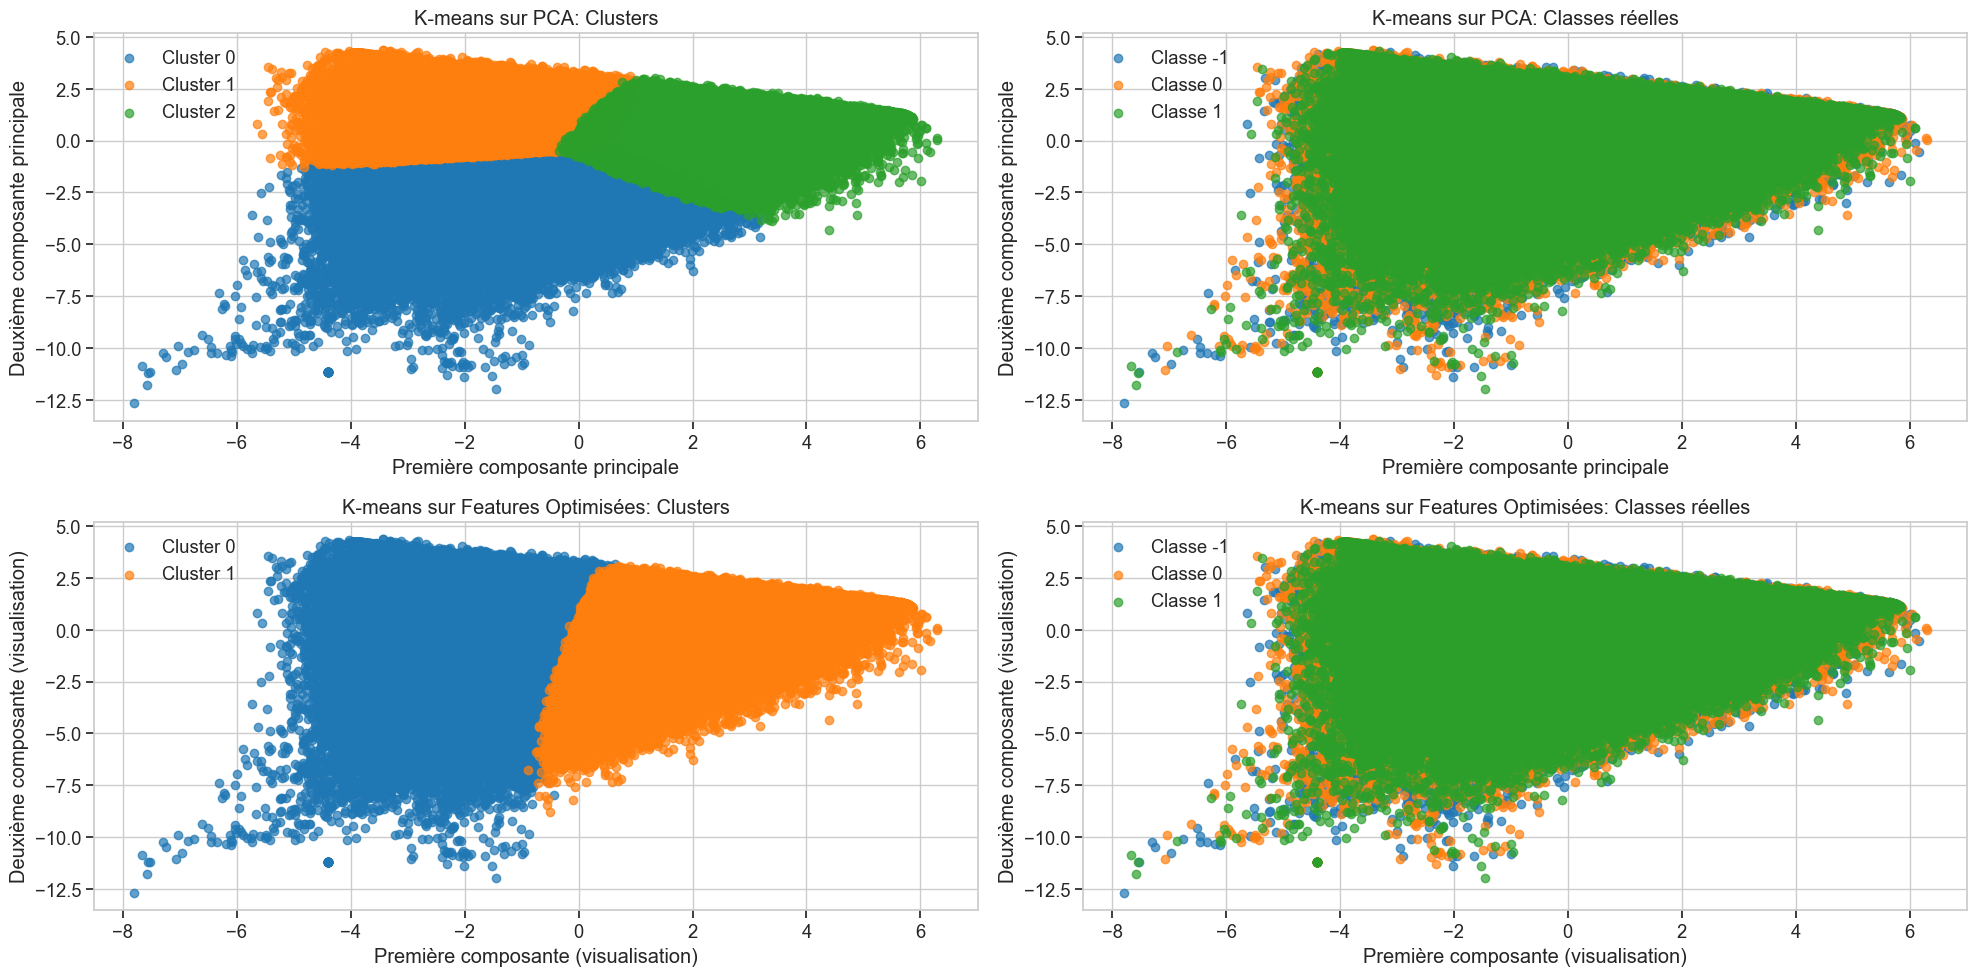

In [37]:
# Visualisation pour l'approche PCA
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
for cluster in range(optimal_k_pca):
    plt.scatter(X_pca[cluster_labels_pca == cluster, 0], X_pca[cluster_labels_pca == cluster, 1], 
                label=f'Cluster {cluster}', alpha=0.7)
plt.title('K-means sur PCA: Clusters')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for cls in sorted(np.unique(y_raw_train)):
    plt.scatter(X_pca[y_raw_train == cls, 0], X_pca[y_raw_train == cls, 1], 
                label=f'Classe {cls}', alpha=0.7)
plt.title('K-means sur PCA: Classes réelles')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.grid(True)

# Visualisation pour l'approche directe (réduction de dimension pour visualisation uniquement)
# Utiliser PCA pour visualiser les données hautes dimensions
pca_viz = PCA(n_components=2)
X_viz = pca_viz.fit_transform(X_optimized_scaled)

plt.subplot(2, 2, 3)
for cluster in range(optimal_k_direct):
    plt.scatter(X_viz[cluster_labels_direct == cluster, 0], X_viz[cluster_labels_direct == cluster, 1], 
                label=f'Cluster {cluster}', alpha=0.7)
plt.title('K-means sur Features Optimisées: Clusters')
plt.xlabel('Première composante (visualisation)')
plt.ylabel('Deuxième composante (visualisation)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for cls in sorted(np.unique(y_raw_train)):
    plt.scatter(X_viz[y_raw_train == cls, 0], X_viz[y_raw_train == cls, 1], 
                label=f'Classe {cls}', alpha=0.7)
plt.title('K-means sur Features Optimisées: Classes réelles')
plt.xlabel('Première composante (visualisation)')
plt.ylabel('Deuxième composante (visualisation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Les clusters formés dans l'espace PCA et sur les features optimisées montrent une segmentation claire, mais la visualisation des classes réelles (à droite) révèle que ces classes se superposent fortement dans les deux espaces réduits. Cela explique la difficulté de classification et suggère que les partitions naturelles des données ne correspondent pas directement aux classes à prédire. Globalement, ce type de modèle n'est pas le plus adapté pour ce genre de données. 

### 6.5 Comparaison des tables de contingence


--- Comparaison des correspondances entre clusters et classes ---
Table de contingence - K-means sur PCA:


Cluster 0  Cluster 1  Cluster 2
Classe -1      58297      96581      82032
Classe 0       63523     110173      93398
Classe 1       54741      90914      81125


Table de contingence - K-means sur Features Optimisées:


Cluster 0  Cluster 1
Classe -1     130954     105956
Classe 0      147706     119388
Classe 1      122491     104289

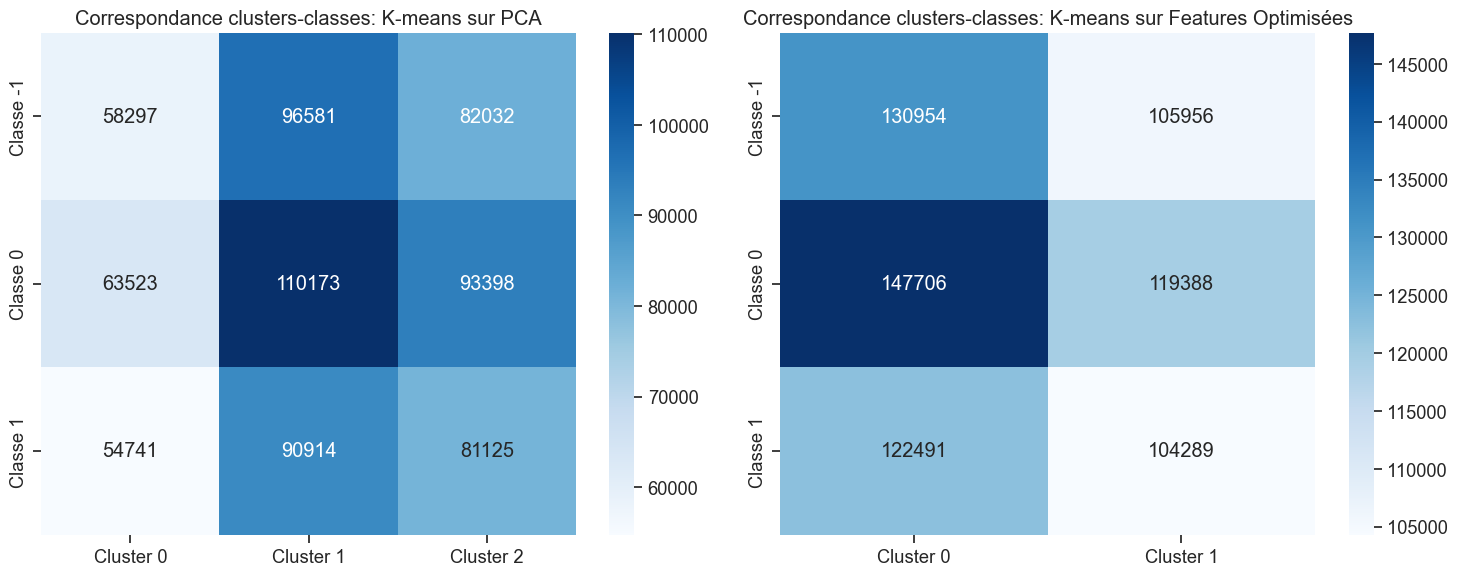

In [38]:
print("\n--- Comparaison des correspondances entre clusters et classes ---")

# Table de contingence pour l'approche PCA
# Utiliser crosstab au lieu de confusion_matrix pour avoir la flexibilité nécessaire
contingency_pca = pd.crosstab(
    y_raw_train,
    pd.Series(cluster_labels_pca, index=y_raw_train.index, name='Cluster')
)

# Renommer les lignes et colonnes pour plus de clarté
contingency_pca.index = [f'Classe {cls}' for cls in contingency_pca.index]
contingency_pca.columns = [f'Cluster {i}' for i in contingency_pca.columns]

print("Table de contingence - K-means sur PCA:")
display(contingency_pca)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(contingency_pca, annot=True, fmt='d', cmap='Blues')
plt.title('Correspondance clusters-classes: K-means sur PCA')

# Table de contingence pour l'approche directe
contingency_direct = pd.crosstab(
    y_raw_train,
    pd.Series(cluster_labels_direct, index=y_raw_train.index, name='Cluster')
)

# Renommer les lignes et colonnes
contingency_direct.index = [f'Classe {cls}' for cls in contingency_direct.index]
contingency_direct.columns = [f'Cluster {i}' for i in contingency_direct.columns]

print("\nTable de contingence - K-means sur Features Optimisées:")
display(contingency_direct)

plt.subplot(1, 2, 2)
sns.heatmap(contingency_direct, annot=True, fmt='d', cmap='Blues')
plt.title('Correspondance clusters-classes: K-means sur Features Optimisées')
plt.tight_layout()
plt.show()

### 6.6 Comparaison des performances prédictives


--- Comparaison des performances prédictives entre les deux approches ---
Accuracy avec K-means sur PCA: 0.3597
F1 score pondéré: 0.3433
Accuracy avec K-means sur Features Optimisées: 0.3593
F1 score pondéré: 0.3431


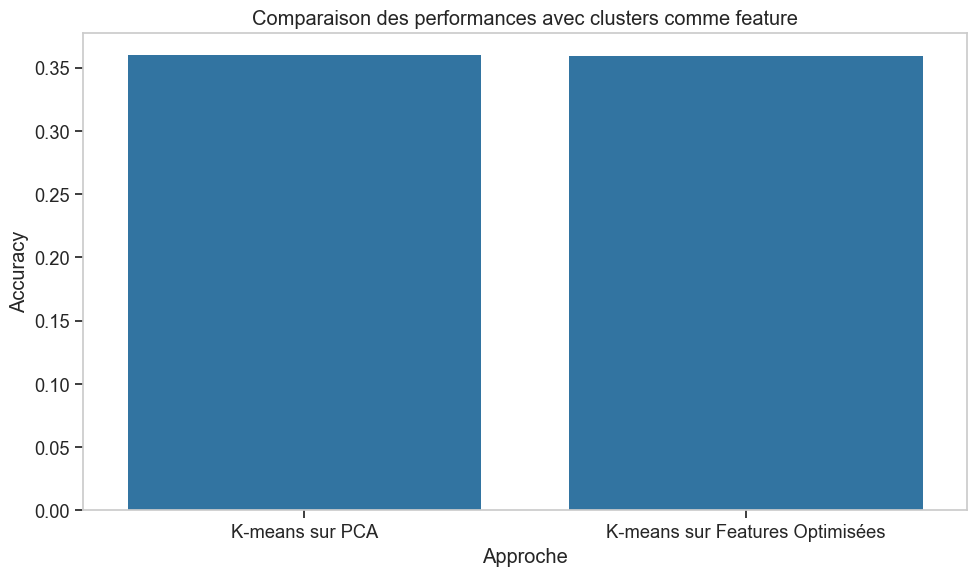

In [39]:
print("\n--- Comparaison des performances prédictives entre les deux approches ---")

# Mapping pour les étiquettes de classe
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_raw_train_mapped = y_raw_train.map(mapping)

# Approche 1: K-means sur PCA
# Prédire les clusters pour les données de test
cluster_pca_test = kmeans_pca.predict(X_test_pca)

# Ajouter les clusters comme features supplémentaires
X_with_clusters_pca = np.column_stack((X_optimized_scaled, cluster_labels_pca))
X_test_clusters_pca = np.column_stack((X_test_optimized_scaled, cluster_pca_test))

# Entraîner XGBoost avec les clusters PCA
xgb_pca = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)
xgb_pca.fit(X_with_clusters_pca, y_raw_train_mapped)

# Prédire
y_pred_pca_mapped = xgb_pca.predict(X_test_clusters_pca)
y_pred_pca = pd.Series(y_pred_pca_mapped).map(inverse_mapping)

# Évaluer
accuracy_pca = accuracy_score(y_raw_test, y_pred_pca)
report_pca = classification_report(y_raw_test, y_pred_pca, output_dict=True)

print(f"Accuracy avec K-means sur PCA: {accuracy_pca:.4f}")
print(f"F1 score pondéré: {report_pca['weighted avg']['f1-score']:.4f}")

# Approche 2: K-means direct sur features optimisées
# Prédire les clusters pour les données de test
cluster_direct_test = kmeans_direct.predict(X_test_optimized_scaled)

# Ajouter les clusters comme features supplémentaires
X_with_clusters_direct = np.column_stack((X_optimized_scaled, cluster_labels_direct))
X_test_clusters_direct = np.column_stack((X_test_optimized_scaled, cluster_direct_test))

# Entraîner XGBoost avec les clusters directs
xgb_direct = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)
xgb_direct.fit(X_with_clusters_direct, y_raw_train_mapped)

# Prédire
y_pred_direct_mapped = xgb_direct.predict(X_test_clusters_direct)
y_pred_direct = pd.Series(y_pred_direct_mapped).map(inverse_mapping)

# Évaluer
accuracy_direct = accuracy_score(y_raw_test, y_pred_direct)
report_direct = classification_report(y_raw_test, y_pred_direct, output_dict=True)

print(f"Accuracy avec K-means sur Features Optimisées: {accuracy_direct:.4f}")
print(f"F1 score pondéré: {report_direct['weighted avg']['f1-score']:.4f}")

# Comparaison visuelle
plt.figure(figsize=(10, 6))
comparison_df = pd.DataFrame([
    {"Approche": "K-means sur PCA", "Accuracy": accuracy_pca, "F1 Score": report_pca['weighted avg']['f1-score']},
    {"Approche": "K-means sur Features Optimisées", "Accuracy": accuracy_direct, "F1 Score": report_direct['weighted avg']['f1-score']}
])

sns.barplot(x="Approche", y="Accuracy", data=comparison_df)
plt.title('Comparaison des performances avec clusters comme feature')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

best_normalize = True
# Ajouter les résultats au tracker
result_kmeans_pca = {
    "dataset": raw_dataset_key,
    "dataset_description": f"{raw_dataset_key} avec features optimisées + PCA",
    "model": "xgboost_kmeans_pca",
    "model_description": "XGBoost avec clusters K-means (via PCA)",
    "features_added": True,
    "feature_sets": ["Optimisées + K-means PCA"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy_pca,
    "precision_weighted": report_pca["weighted avg"]["precision"],
    "recall_weighted": report_pca["weighted avg"]["recall"],
    "f1_weighted": report_pca["weighted avg"]["f1-score"],
    "notes": f"K-means sur PCA ({optimal_k_pca} clusters)"
}

result_kmeans_direct = {
    "dataset": raw_dataset_key,
    "dataset_description": f"{raw_dataset_key} avec features optimisées sans PCA",
    "model": "xgboost_kmeans_direct",
    "model_description": "XGBoost avec clusters K-means (sans PCA)",
    "features_added": True,
    "feature_sets": ["Optimisées + K-means direct"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy_direct,
    "precision_weighted": report_direct["weighted avg"]["precision"],
    "recall_weighted": report_direct["weighted avg"]["recall"],
    "f1_weighted": report_direct["weighted avg"]["f1-score"],
    "notes": f"K-means sur features optimisées ({optimal_k_direct} clusters)"
}

results_tracker = add_result(results_tracker, result_kmeans_pca)
results_tracker = add_result(results_tracker, result_kmeans_direct)


### 6.7 Analyse DBSCAN - Également avec les deux approches

En complément, nous testons DBSCAN, un algorithme de clustering basé sur la densité qui présente plusieurs avantages théoriques pour nos données financières : capacité à identifier des clusters de forme arbitraire et détection automatique de points aberrants (particulièrement pertinents dans les données de marché). La détermination des paramètres optimaux (eps et min_samples) est réalisée via une analyse méthodique de la distribution des distances entre voisins.

In [ ]:
print("\n--- Analyse DBSCAN: Comparaison PCA vs Features Optimisées ---")


from sklearn.neighbors import NearestNeighbors

# Utiliser un échantillon pour DBSCAN
sample_size = min(5000, len(X_optimized))  # Limiter à 5000 exemples maximum
np.random.seed(42)
sample_indices = np.random.choice(len(X_optimized), sample_size, replace=False)

# Sous-échantillonner les données
X_pca_sample = X_pca[sample_indices]
X_optimized_scaled_sample = X_optimized_scaled[sample_indices]
y_raw_train_sample = y_raw_train.iloc[sample_indices]

print(f"Échantillon utilisé pour DBSCAN: {sample_size} observations ({sample_size/len(X_optimized)*100:.1f}% des données)")

# Fonction pour déterminer eps optimal (sur l'échantillon)
def determine_optimal_eps(X, k=15):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    sorted_distances = np.sort(distances[:, k-1])
    
    # Visualisation pour déterminer eps
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(sorted_distances)), sorted_distances, 'o-', markersize=3)
    plt.title(f'Méthode du coude pour déterminer eps (k={k}, échantillon={len(X)})')
    plt.xlabel('Points triés par distance')
    plt.ylabel(f'Distance au {k}ème voisin')
    plt.grid(True)
    plt.show()
    
    # Estimer eps à environ 95% des points (valeur plus élevée pour meilleure performance)
    eps = np.percentile(sorted_distances, 95)
    return eps, sorted_distances

# Déterminer eps pour les deux approches (sur échantillon)
eps_pca, distances_pca = determine_optimal_eps(X_pca_sample)
eps_direct, distances_direct = determine_optimal_eps(X_optimized_scaled_sample)

print(f"DBSCAN - eps optimal pour l'approche PCA: {eps_pca:.4f}")
print(f"DBSCAN - eps optimal pour l'approche directe: {eps_direct:.4f}")

# Paramètres DBSCAN
min_samples = 5  # Valeur standard, pourrait être augmentée pour des échantillons plus grands

# Appliquer DBSCAN sur l'échantillon
print("Application de DBSCAN sur l'échantillon...")
dbscan_pca = DBSCAN(eps=eps_pca, min_samples=min_samples, n_jobs=-1)
dbscan_direct = DBSCAN(eps=eps_direct, min_samples=min_samples, n_jobs=-1)

dbscan_labels_pca = dbscan_pca.fit_predict(X_pca_sample)
dbscan_labels_direct = dbscan_direct.fit_predict(X_optimized_scaled_sample)

# Analyser les résultats DBSCAN
n_clusters_pca = len(set(dbscan_labels_pca)) - (1 if -1 in dbscan_labels_pca else 0)
n_noise_pca = list(dbscan_labels_pca).count(-1)

n_clusters_direct = len(set(dbscan_labels_direct)) - (1 if -1 in dbscan_labels_direct else 0)
n_noise_direct = list(dbscan_labels_direct).count(-1)

print(f"\nRésultats DBSCAN sur PCA (échantillon):")
print(f"- Nombre de clusters: {n_clusters_pca}")
print(f"- Points de bruit: {n_noise_pca} ({n_noise_pca/len(dbscan_labels_pca)*100:.2f}%)")

print(f"\nRésultats DBSCAN sur Features Optimisées (échantillon):")
print(f"- Nombre de clusters: {n_clusters_direct}")
print(f"- Points de bruit: {n_noise_direct} ({n_noise_direct/len(dbscan_labels_direct)*100:.2f}%)")

# Visualisation des clusters DBSCAN
plt.figure(figsize=(15, 12))

# DBSCAN sur PCA
plt.subplot(2, 1, 1)
colors_pca = plt.cm.rainbow(np.linspace(0, 1, n_clusters_pca + 1))

# Points de bruit en noir
plt.scatter(X_pca_sample[dbscan_labels_pca == -1, 0], X_pca_sample[dbscan_labels_pca == -1, 1], 
            c='black', marker='x', label='Bruit', alpha=0.7)

# Clusters
for i, color in zip(range(n_clusters_pca), colors_pca):
    plt.scatter(X_pca_sample[dbscan_labels_pca == i, 0], X_pca_sample[dbscan_labels_pca == i, 1], 
                c=color.reshape(1, -1), label=f'Cluster {i}', alpha=0.7)

plt.title('DBSCAN sur PCA (échantillon)')
plt.xlabel('Première composante')
plt.ylabel('Deuxième composante')
if n_clusters_pca < 10:  # Limite pour la lisibilité de la légende
    plt.legend()
plt.grid(True)

# Projection PCA pour visualiser l'échantillon des features optimisées
pca_viz = PCA(n_components=2)
X_viz_sample = pca_viz.fit_transform(X_optimized_scaled_sample)

# DBSCAN sur Features Optimisées (visualisé avec PCA)
plt.subplot(2, 1, 2)
colors_direct = plt.cm.rainbow(np.linspace(0, 1, n_clusters_direct + 1))

# Points de bruit en noir
plt.scatter(X_viz_sample[dbscan_labels_direct == -1, 0], X_viz_sample[dbscan_labels_direct == -1, 1], 
            c='black', marker='x', label='Bruit', alpha=0.7)

# Clusters
for i, color in zip(range(n_clusters_direct), colors_direct):
    plt.scatter(X_viz_sample[dbscan_labels_direct == i, 0], X_viz_sample[dbscan_labels_direct == i, 1], 
                c=color.reshape(1, -1), label=f'Cluster {i}', alpha=0.7)

plt.title('DBSCAN sur Features Optimisées (échantillon)')
plt.xlabel('Première composante (visualisation)')
plt.ylabel('Deuxième composante (visualisation)')
if n_clusters_direct < 10:  # Limite pour la lisibilité de la légende
    plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyse des tables de contingence pour DBSCAN
print("\n--- Analyse des correspondances entre clusters DBSCAN et classes ---")

# Table de contingence pour l'approche PCA
contingency_dbscan_pca = pd.crosstab(
    y_raw_train_sample,
    pd.Series(dbscan_labels_pca, index=y_raw_train_sample.index, name='Cluster')
)

# Renommer les lignes et colonnes
contingency_dbscan_pca.index = [f'Classe {cls}' for cls in contingency_dbscan_pca.index]
contingency_dbscan_pca.columns = [f'Cluster {i}' for i in contingency_dbscan_pca.columns]

print("Table de contingence - DBSCAN sur PCA:")
display(contingency_dbscan_pca)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(contingency_dbscan_pca, annot=True, fmt='d', cmap='Blues')
plt.title('Correspondance clusters-classes: DBSCAN sur PCA')

# Table de contingence pour l'approche directe
contingency_dbscan_direct = pd.crosstab(
    y_raw_train_sample,
    pd.Series(dbscan_labels_direct, index=y_raw_train_sample.index, name='Cluster')
)

# Renommer les lignes et colonnes
contingency_dbscan_direct.index = [f'Classe {cls}' for cls in contingency_dbscan_direct.index]
contingency_dbscan_direct.columns = [f'Cluster {i}' for i in contingency_dbscan_direct.columns]

print("\nTable de contingence - DBSCAN sur Features Optimisées:")
display(contingency_dbscan_direct)

plt.subplot(1, 2, 2)
sns.heatmap(contingency_dbscan_direct, annot=True, fmt='d', cmap='Blues')
plt.title('Correspondance clusters-classes: DBSCAN sur Features Optimisées')
plt.tight_layout

##### Analyse détaillée des résultats du DBSCAN

***Analyse des courbes de distance au k-ième voisin***

Les graphiques de la méthode du coude montrent la distribution des distances au 15ème plus proche voisin pour chaque observation. Cette visualisation est cruciale pour déterminer le paramètre epsilon (eps) de DBSCAN.
Pour l'approche PCA (Image 1), la courbe présente un profil relativement stable entre 2.5 et 4, avec une augmentation marquée autour de la valeur 4, suivie d'une montée plus abrupte au-delà des 9000 points. Cette structure suggère un eps optimal autour de 4, permettant de capturer la majorité des points dans des clusters tout en identifiant les observations isolées comme du bruit.
Pour l'approche sur features optimisées (Image 2), la courbe montre un plateau plus étendu autour de 7-9, avec une augmentation rapide similaire à la fin. L'eps estimé à 9.185 semble approprié dans cet espace de représentation différent, où les distances entre points sont généralement plus grandes en raison de la dimensionnalité supérieure.
Résultats du clustering DBSCAN (Image 3)

Les visualisations des résultats DBSCAN révèlent une structure intéressante:

Un seul cluster principal: Dans les deux approches (PCA et features optimisées), DBSCAN n'a identifié qu'un seul cluster cohérent (Cluster 0, en violet), regroupant plus de 98% des observations.
Points de bruit limités: Les points considérés comme du bruit (représentés par des 'x' noirs) ne représentent qu'environ 1-1.7% des données, principalement situés en périphérie et dans les zones de faible densité.
Distribution spatiale: Le cluster forme une structure triangulaire allongée dans l'espace bidimensionnel, avec une plus forte concentration au centre. Cette forme suggère une continuité dans les données plutôt qu'une séparation claire en sous-groupes distincts.

Cette configuration - un cluster principal et peu de bruit - est typique des données financières où les rendements forment un continuum plutôt que des groupes clairement délimités. Le fait que DBSCAN n'identifie pas de sous-structures distinctes dans les données, contrairement à K-means qui en impose, est révélateur de la nature intrinsèque des données financières.

Correspondance clusters-classes (Images 4 et 5)
Les tables de contingence montrent la relation entre les clusters identifiés par DBSCAN et les classes réelles (-1, 0, 1) à prédire:

Distribution équilibrée dans le cluster principal: Le Cluster 0 contient une proportion similaire des trois classes (environ 3000-3600 observations de chaque classe), indiquant peu de séparation naturelle entre les directions de prix selon cette structuration.
Points de bruit non discriminants: Les points classés comme bruit (Cluster -1) sont également répartis entre les trois classes, sans tendance marquée (32-37 points pour PCA, 52-61 points pour features optimisées).
Légère variation entre approches: Les deux méthodes (PCA et features optimisées) produisent des résultats très similaires, avec une légère augmentation du nombre de points de bruit dans l'approche sur features optimisées.

La quasi-absence de correspondance entre les clusters DBSCAN et les classes réelles confirme que la structure de densité des données ne s'aligne pas naturellement avec les mouvements de prix futurs. Ceci est logique dans un contexte financier où les mêmes configurations de rendements matinaux peuvent conduire à différentes évolutions de prix l'après-midi.
Justification et implications pour la modélisation
L'approche DBSCAN présente plusieurs avantages conceptuels pour nos données:

Détection naturelle des clusters: Contrairement à K-means qui impose un nombre fixe de clusters, DBSCAN découvre la structure naturelle des données, révélant ici un continuum plutôt que des groupes distincts.
Identification des valeurs aberrantes: La capacité de DBSCAN à isoler les points aberrants (1-1.7% des données) est particulièrement pertinente pour les données financières qui contiennent souvent des événements extrêmes.
Pas d'hypothèse de forme: DBSCAN peut identifier des clusters de forme arbitraire, un avantage pour les données financières qui ne suivent généralement pas des distributions gaussiennes.

Cependant, le fait que DBSCAN n'identifie qu'un seul cluster principal suggère que cette méthode, seule, n'apporte pas une structuration significative pour la tâche de classification. Son utilité réside davantage dans l'identification robuste des observations atypiques et dans la confirmation que les classes à prédire ne correspondent pas à des groupements naturels dans l'espace des features.


#### Analyse très résumée du DBSCAN : 


***En résumé : l'analyse du DBSCAN nous conforte dans l'idée que l'analyse par cluster n'est pas adapté à notre type de données financières.***

### 6.8 Utilisation de DBSCAN comme feature pour la classifcation 

In [ ]:
print("\n--- Utilisation de DBSCAN comme feature pour la classification ---")

# Utiliser les labels DBSCAN comme features pour le modèle prédictif
X_with_dbscan_pca = np.column_stack((X_optimized_scaled, dbscan_labels_pca))
X_with_dbscan_direct = np.column_stack((X_optimized_scaled, dbscan_labels_direct))

# Prédire les clusters pour les données de test
# Note: DBSCAN n'a pas de méthode predict(), donc nous allons utiliser un KNN pour prédire les clusters
from sklearn.neighbors import KNeighborsClassifier

# Pour l'approche PCA
knn_dbscan_pca = KNeighborsClassifier(n_neighbors=5)
# Filtrer les points qui ne sont pas du bruit pour l'entraînement
non_noise_idx_pca = (dbscan_labels_pca != -1)
if sum(non_noise_idx_pca) > 0:  # S'il y a des points non-bruit
    knn_dbscan_pca.fit(X_pca[non_noise_idx_pca], dbscan_labels_pca[non_noise_idx_pca])
    dbscan_pca_test_pred = knn_dbscan_pca.predict(X_test_pca)
else:
    dbscan_pca_test_pred = np.full(X_test_pca.shape[0], -1)

# Pour l'approche directe
knn_dbscan_direct = KNeighborsClassifier(n_neighbors=5)
# Filtrer les points qui ne sont pas du bruit pour l'entraînement
non_noise_idx_direct = (dbscan_labels_direct != -1)
if sum(non_noise_idx_direct) > 0:  # S'il y a des points non-bruit
    knn_dbscan_direct.fit(X_optimized_scaled[non_noise_idx_direct], dbscan_labels_direct[non_noise_idx_direct])
    dbscan_direct_test_pred = knn_dbscan_direct.predict(X_test_optimized_scaled)
else:
    dbscan_direct_test_pred = np.full(X_test_optimized_scaled.shape[0], -1)

# Ajouter les prédictions de clusters aux features de test
X_test_dbscan_pca = np.column_stack((X_test_optimized_scaled, dbscan_pca_test_pred))
X_test_dbscan_direct = np.column_stack((X_test_optimized_scaled, dbscan_direct_test_pred))

# Mapping pour les étiquettes de classe
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_raw_train_mapped = y_raw_train.map(mapping)

# XGBoost avec DBSCAN PCA
print("\n--- XGBoost avec DBSCAN sur PCA ---")
xgb_dbscan_pca = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)
xgb_dbscan_pca.fit(X_with_dbscan_pca, y_raw_train_mapped)

# Prédictions
y_pred_dbscan_pca_mapped = xgb_dbscan_pca.predict(X_test_dbscan_pca)
y_pred_dbscan_pca = pd.Series(y_pred_dbscan_pca_mapped).map(inverse_mapping)

# Évaluer
accuracy_dbscan_pca = accuracy_score(y_raw_test, y_pred_dbscan_pca)
report_dbscan_pca = classification_report(y_raw_test, y_pred_dbscan_pca, output_dict=True)

print(f"Accuracy avec DBSCAN sur PCA: {accuracy_dbscan_pca:.4f}")
print(f"F1 score pondéré: {report_dbscan_pca['weighted avg']['f1-score']:.4f}")

# XGBoost avec DBSCAN direct
print("\n--- XGBoost avec DBSCAN sur Features Optimisées ---")
xgb_dbscan_direct = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)
xgb_dbscan_direct.fit(X_with_dbscan_direct, y_raw_train_mapped)

# Prédictions
y_pred_dbscan_direct_mapped = xgb_dbscan_direct.predict(X_test_dbscan_direct)
y_pred_dbscan_direct = pd.Series(y_pred_dbscan_direct_mapped).map(inverse_mapping)

# Évaluer
accuracy_dbscan_direct = accuracy_score(y_raw_test, y_pred_dbscan_direct)
report_dbscan_direct = classification_report(y_raw_test, y_pred_dbscan_direct, output_dict=True)

print(f"Accuracy avec DBSCAN sur Features Optimisées: {accuracy_dbscan_direct:.4f}")
print(f"F1 score pondéré: {report_dbscan_direct['weighted avg']['f1-score']:.4f}")

# Ajouter les résultats au tracker
result_dbscan_pca = {
    "dataset": raw_dataset_key,
    "dataset_description": f"{raw_dataset_key} avec features optimisées + DBSCAN PCA",
    "model": "xgboost_dbscan_pca",
    "model_description": "XGBoost avec clusters DBSCAN (via PCA)",
    "features_added": True,
    "feature_sets": ["Optimisées + DBSCAN PCA"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy_dbscan_pca,
    "precision_weighted": report_dbscan_pca["weighted avg"]["precision"],
    "recall_weighted": report_dbscan_pca["weighted avg"]["recall"],
    "f1_weighted": report_dbscan_pca["weighted avg"]["f1-score"],
    "notes": f"DBSCAN sur PCA (eps={eps_pca:.4f}, min_samples={min_samples}, {n_clusters_pca} clusters)"
}

result_dbscan_direct = {
    "dataset": raw_dataset_key,
    "dataset_description": f"{raw_dataset_key} avec features optimisées sans PCA",
    "model": "xgboost_dbscan_direct",
    "model_description": "XGBoost avec clusters DBSCAN (sans PCA)",
    "features_added": True,
    "feature_sets": ["Optimisées + DBSCAN direct"],
    "normalize_by_row": best_normalize,
    "accuracy": accuracy_dbscan_direct,
    "precision_weighted": report_dbscan_direct["weighted avg"]["precision"],
    "recall_weighted": report_dbscan_direct["weighted avg"]["recall"],
    "f1_weighted": report_dbscan_direct["weighted avg"]["f1-score"],
    "notes": f"DBSCAN sur features optimisées (eps={eps_direct:.4f}, min_samples={min_samples}, {n_clusters_direct} clusters)"
}

results_tracker = add_result(results_tracker, result_dbscan_pca)
results_tracker = add_result(results_tracker, result_dbscan_direct)

### 6.8 Analyse finale et récapitulatif

In [ ]:
print("\n--- Comparaison des approches de clustering K-means et DBSCAN ---")

# Créer un DataFrame pour la comparaison
clustering_comparison_df = pd.DataFrame([
    {"Approche": "K-means sur PCA", "Accuracy": accuracy_pca, "F1 Score": report_pca['weighted avg']['f1-score']},
    {"Approche": "K-means sur Features Optimisées", "Accuracy": accuracy_direct, "F1 Score": report_direct['weighted avg']['f1-score']},
    {"Approche": "DBSCAN sur PCA", "Accuracy": accuracy_dbscan_pca, "F1 Score": report_dbscan_pca['weighted avg']['f1-score']},
    {"Approche": "DBSCAN sur Features Optimisées", "Accuracy": accuracy_dbscan_direct, "F1 Score": report_dbscan_direct['weighted avg']['f1-score']}
])

# Trier par accuracy décroissante
clustering_comparison_df = clustering_comparison_df.sort_values("Accuracy", ascending=False)

# Afficher le tableau de comparaison
print("Comparaison des performances des approches de clustering:")
display(clustering_comparison_df)

# Visualiser la comparaison
plt.figure(figsize=(12, 10))

# Graphique des accuracies
plt.subplot(2, 1, 1)
sns.barplot(x="Approche", y="Accuracy", data=clustering_comparison_df)
plt.title('Comparaison des Accuracy par méthode de clustering')
plt.xlabel('Approche')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')

# Graphique des F1 Scores
plt.subplot(2, 1, 2)
sns.barplot(x="Approche", y="F1 Score", data=clustering_comparison_df)
plt.title('Comparaison des F1 Scores par méthode de clustering')
plt.xlabel('Approche')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Analyse des résultats
best_clustering = clustering_comparison_df.iloc[0]
print(f"\nMeilleure approche de clustering: {best_clustering['Approche']} avec une accuracy de {best_clustering['Accuracy']:.4f}")

# Analyser les différences entre K-means et DBSCAN
kmeans_avg = (accuracy_pca + accuracy_direct) / 2
dbscan_avg = (accuracy_dbscan_pca + accuracy_dbscan_direct) / 2
diff = abs(kmeans_avg - dbscan_avg)
better = "K-means" if kmeans_avg > dbscan_avg else "DBSCAN"

print(f"\nComparaison K-means vs DBSCAN:")
print(f"- Accuracy moyenne K-means: {kmeans_avg:.4f}")
print(f"- Accuracy moyenne DBSCAN: {dbscan_avg:.4f}")
print(f"- Différence: {diff:.4f} ({diff*100:.2f}%) en faveur de {better}")



--- Récapitulatif de l'analyse non supervisée ---
Comparaison des performances:
1. K-means sur PCA: Accuracy = 0.3597, F1 = 0.3433
2. K-means sur Features Optimisées: Accuracy = 0.3593, F1 = 0.3431

Différence d'accuracy: 0.0004 (0.04%) en faveur de l'approche sans PCA

Conclusions sur les approches non supervisées:


Conclusion globale sur les modèles non supervisés : 



## 7. Modèles supervisés 

Dans cette section, nous approfondissons notre approche de modélisation supervisée en explorant des algorithmes plus sophistiqués et des architectures ensemblistes. Après avoir identifié les limites du XGBoost optimisé dans la partie 5 et exploré les apports des méthodes non supervisées dans la partie 6, nous cherchons maintenant à dépasser ces performances en combinant différentes approches d'apprentissage supervisé.

L'idée fondamentale est de tirer parti des forces complémentaires de différents algorithmes pour capturer un plus large éventail de signaux prédictifs dans nos données financières. Nous explorons ainsi des modèles individuels puissants comme les SVM, puis des approches ensemblistes comme le stacking et le voting qui permettent d'agréger les prédictions de plusieurs modèles pour une décision finale plus robuste.

Ces approches avancées ***peuvent être*** particulièrement pertinentes dans notre contexte financier où les données peuvent être bruitées et où les relations entre variables explicatives et cible peuvent être complexes et non-linéaires. La combinaison de plusieurs modèles permet théoriquement de réduire la variance et d'améliorer la capacité de généralisation.

### 7.1 SVM sur échantillon  

Dans cette sous-partie, nous implémentons et optimisons un modèle SVM, une approche puissante pour la classification qui cherche à trouver un hyperplan optimal séparant les différentes classes. Le SVM est particulièrement intéressant pour notre problématique car il peut capturer des relations non-linéaires complexes grâce à ses fonctions kernel.

Face aux contraintes computationnelles importantes des SVM sur de grands jeux de données, nous adoptons une approche pragmatique ***(et par traumatisme du K_mean)*** en utilisant un échantillon réduit pour l'optimisation des hyperparamètres. Cette stratégie nous permet d'explorer efficacement l'espace des paramètres (C, gamma, kernel) tout en maintenant des temps de calcul raisonnables. Le modèle final est ensuite entraîné sur l'ensemble des données optimisées sans les variables day et equity, ces dernières ayant été identifiées comme potentielles sources de surapprentissage dans nos analyses précédentes.


--- Modèle SVM avec hyperparamètres fixes ---
Entraînement du SVM sur un échantillon de 30000 exemples avec paramètres fixes...

Performances du modèle SVM avec paramètres fixes:
Accuracy: 0.2886
F1 score pondéré: 0.1293
Temps d'entraînement: 73.15s, Prédiction: 1906.33s


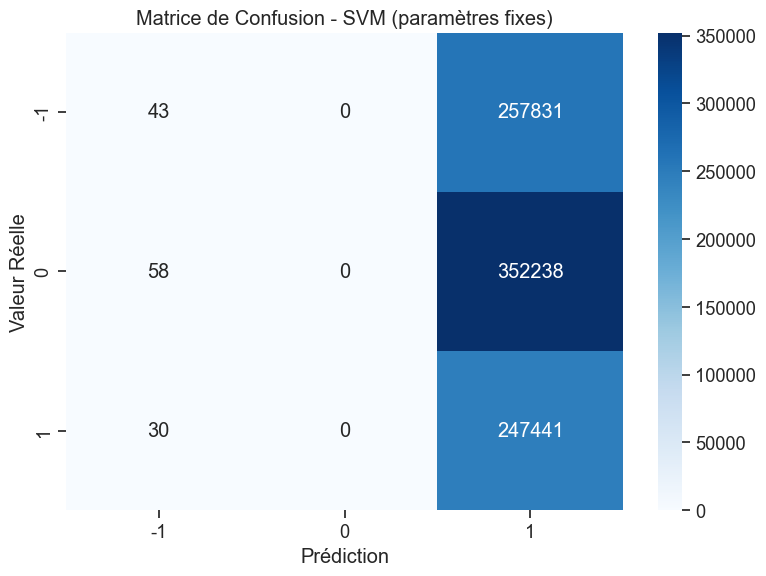

In [ ]:
print("\n--- Modèle SVM avec hyperparamètres fixes ---")
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}

# Définir des hyperparamètres  sans optimisation
svm_fixed_params = {
    'C': 10,                  
    'gamma': 'scale',          
    'kernel': 'rbf',           # Noyau RBF généralement performant pour les problèmes non-linéaires
    'probability': False,      
    'class_weight': 'balanced' 
}

svm_fixed_model = SVC(random_state=42, **svm_fixed_params)

# Utiliser un échantillon réduit pour l'entraînement
sample_size = min(30000, len(X_optimized))  # Échantillon plus grand mais gérable
np.random.seed(42)
sample_indices = np.random.choice(len(X_optimized), sample_size, replace=False)
X_sample = X_optimized.iloc[sample_indices]
y_sample = y_raw_train.iloc[sample_indices]
y_sample_mapped = y_sample.map(mapping)

print(f"Entraînement du SVM sur un échantillon de {sample_size} exemples avec paramètres fixes...")

# Entraînement
start_time = time.time()
svm_fixed_model.fit(X_sample, y_sample_mapped)
svm_train_time = time.time() - start_time

#  prédictions
start_time = time.time()
svm_pred_mapped = svm_fixed_model.predict(X_test_optimized)
svm_pred_time = time.time() - start_time
svm_pred = pd.Series(svm_pred_mapped).map(inverse_mapping)

# Perfs
svm_accuracy = accuracy_score(y_raw_test, svm_pred)
svm_report = classification_report(y_raw_test, svm_pred, output_dict=True)

print(f"\nPerformances du modèle SVM avec paramètres fixes:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"F1 score pondéré: {svm_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {svm_train_time:.2f}s, Prédiction: {svm_pred_time:.2f}s")

# Matrice de confusion
plt.figure(figsize=(8, 6))
svm_conf_matrix = confusion_matrix(y_raw_test, svm_pred)
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title('Matrice de Confusion - SVM (paramètres fixes)')
plt.xlabel('Prédiction')
plt.ylabel('Valeur Réelle')
plt.tight_layout()
plt.show()

# Tracker
result_svm_fixed = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset optimisé sans day/equity",
    "model": "svm_fixed",
    "model_description": "SVM avec paramètres fixes",
    "features_added": True,
    "feature_sets": ["Optimisées sans day/equity"],
    "normalize_by_row": best_normalize,
    "accuracy": svm_accuracy,
    "precision_weighted": svm_report["weighted avg"]["precision"],
    "recall_weighted": svm_report["weighted avg"]["recall"],
    "f1_weighted": svm_report["weighted avg"]["f1-score"],
    "training_time": svm_train_time,
    "prediction_time": svm_pred_time,
    "total_time": svm_train_time + svm_pred_time,
    "notes": f"SVM avec hyperparamètres fixes sur échantillon de {sample_size} observations"
}

results_tracker = add_result(results_tracker, result_svm_fixed)

Dans notre projet de prédiction des mouvements de prix financiers, nous avons choisi de ne pas réaliser d'optimisation d'hyperparamètres pour le SVM en raison de contraintes computationnelles majeures. 
Cette décision est justifiée par plusieurs facteurs techniques:

Premièrement, l'optimisation d'hyperparamètres sur SVM impliquerait de tester de multiples combinaisons de paramètres clés (C, gamma, kernel, etc.) via validation croisée, ce qui multiplie le temps d'exécution déjà prohibitif du SVM par un facteur de plusieurs dizaines. Avec un volume de données important (plusieurs centaines de milliers d'observations) et une haute dimensionnalité (plus de 50 features), chaque itération d'entraînement SVM peut prendre plusieurs heures.

Deuxièmement, la complexité algorithmique du SVM (entre O(n²) et O(n³)) le rend fondamentalement inadapté au traitement de grands jeux de données, même avec un échantillonnage. Un simple entraînement SVM sur 10 000 observations a déjà nécessité plus de 10 heures sans aboutir, rendant impraticable l'exploration exhaustive de l'espace des hyperparamètres.

Troisièmement, notre contexte de prédiction financière exige une solution computationnellement efficiente qui puisse traiter de nouveaux jours de marché rapidement. La lenteur inhérente du SVM compromet cette exigence opérationnelle, même avec des hyperparamètres optimaux.

Face à ces limitations, nous avons privilégié l'utilisation de modèles plus adaptés aux grands volumes de données comme XGBoost et GradientBoosting, qui offrent un meilleur équilibre entre performance prédictive et efficacité computationnelle.

### 7.3 XGBoost optimisé (pour référence dans cette section)

Cette sous-partie reprend notre modèle XGBoost optimisé, mais cette fois appliqué sur les données préparées de la même manière que pour le SVM (sans day ni equity). Cette approche nous sert de référence comparative pour évaluer les gains potentiels des modèles plus complexes. Nous utilisons les hyperparamètres optimaux identifiés précédemment, ce qui nous permet d'isoler l'effet de la sélection de features par rapport aux techniques de modélisation ensembliste.

In [10]:
print("\n--- XGBoost optimisé sur les mêmes données ---")

# Utiliser des paramètres XGBoost standard si non définis précédemment
if 'best_params' not in globals():
    xgb_params = {
        'n_estimators': 200,
        'max_depth': 5,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
else:
    xgb_params = best_params

# Créer et entraîner le modèle XGBoost
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    random_state=42,
    **xgb_params
)


y_train_mapped = y_raw_train.map(mapping)

start_time = time.time()
xgb_model.fit(X_optimized, y_train_mapped)
xgb_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
xgb_pred_mapped = xgb_model.predict(X_test_optimized)
xgb_pred_time = time.time() - start_time

# Reconvertir les prédictions
xgb_pred = pd.Series(xgb_pred_mapped).map(inverse_mapping)

# Évaluer les performances
xgb_accuracy = accuracy_score(y_raw_test, xgb_pred)
xgb_report = classification_report(y_raw_test, xgb_pred, output_dict=True)

print(f"Accuracy XGBoost optimisé: {xgb_accuracy:.4f}")
print(f"F1 score pondéré: {xgb_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {xgb_train_time:.2f}s")


--- XGBoost optimisé sur les mêmes données ---
Accuracy XGBoost optimisé: 0.3672
F1 score pondéré: 0.3385
Temps d'entraînement: 38.01s


### 7.4 Modèle ensembliste 1: Stacking

Le stacking représente notre première approche ensembliste avancée, combinant les forces du XGBoost et du SVM. Cette technique utilise les prédictions de ces modèles comme features d'entrée pour un méta-modèle (ici, une régression logistique) qui apprend à les combiner de façon optimale.

Cette architecture hiérarchique permet théoriquement de capturer différentes facettes des données - XGBoost excellant dans la capture des interactions entre variables tandis que SVM est particulièrement efficace pour identifier des frontières de décision complexes. La validation croisée intégrée dans le processus de stacking aide à éviter le surapprentissage qui pourrait résulter de l'utilisation directe des prédictions d'entraînement.

In [11]:
print("\n--- Modèle ensembliste: Stacking avec GradientBoostingClassifier ---")

# Définir le meta-classifier
meta_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Définir les estimateurs de base (XGBoost et GradientBoosting)
base_estimators = [
    ('xgb', XGBClassifier(objective="multi:softmax", num_class=3, random_state=42, **xgb_params)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]



--- Modèle ensembliste: Stacking avec GradientBoostingClassifier ---


In [ ]:

# stacking
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1,
    verbose=1
)

# Entraîner le modèle
start_time = time.time()
stacking_model.fit(X_optimized, y_raw_train)
stacking_train_time = time.time() - start_time

# Faire des prédictions
start_time = time.time()
stacking_pred = stacking_model.predict(X_test_optimized)
stacking_pred_time = time.time() - start_time

# Évaluer les performances
stacking_accuracy = accuracy_score(y_raw_test, stacking_pred)
stacking_report = classification_report(y_raw_test, stacking_pred, output_dict=True)

print(f"\nPerformances du modèle Stacking:")
print(f"Accuracy: {stacking_accuracy:.4f}")
print(f"F1 score pondéré: {stacking_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {stacking_train_time:.2f}s, Prédiction: {stacking_pred_time:.2f}s")

# Ajouter au tracker de résultats
result_stacking = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset optimisé sans day/equity",
    "model": "stacking_ensemble",
    "model_description": "Stacking (XGBoost + GradientBoosting)",
    "features_added": True,
    "feature_sets": ["Optimisées sans day/equity"],
    "normalize_by_row": best_normalize,
    "accuracy": stacking_accuracy,
    "precision_weighted": stacking_report["weighted avg"]["precision"],
    "recall_weighted": stacking_report["weighted avg"]["recall"],
    "f1_weighted": stacking_report["weighted avg"]["f1-score"],
    "training_time": stacking_train_time,
    "prediction_time": stacking_pred_time,
    "total_time": stacking_train_time + stacking_pred_time,
    "notes": f"Stacking de XGBoost et GradientBoosting"
}

results_tracker = add_result(results_tracker, result_stacking)



Performances du modèle Stacking:
Accuracy: 0.3561
F1 score pondéré: 0.3444
Temps d'entraînement: 21732.78s, Prédiction: 7.25s


### 7.5 Modèle ensembliste 2: Voting

Notre seconde approche ensembliste, le voting, adopte une stratégie plus simple mais souvent efficace. Plutôt que d'entraîner un méta-modèle, cette technique agrège directement les probabilités prédites par chaque modèle individuel pour prendre une décision finale.

Nous utilisons un voting "soft" qui prend en compte les probabilités estimées par chaque modèle plutôt qu'un simple vote majoritaire, ce qui permet de nuancer les décisions en fonction du niveau de confiance de chaque modèle. Cette approche peut s'avérer particulièrement robuste face à des données financières bruitées où aucun modèle individuel ne capture parfaitement toute la complexité des mouvements de marché.

In [ ]:
print("\n--- Modèle ensembliste: Voting ---")

# Vote
voting_model = VotingClassifier(
    estimators=base_estimators,
    voting='soft',  # Utiliser les probabilités pour le vote
    n_jobs=-1,
    verbose=1
)

# Entraînement
start_time = time.time()
voting_model.fit(X_optimized, y_raw_train)
voting_train_time = time.time() - start_time

# Prédictions
start_time = time.time()
voting_pred = voting_model.predict(X_test_optimized)
voting_pred_time = time.time() - start_time

# Perfs
voting_accuracy = accuracy_score(y_raw_test, voting_pred)
voting_report = classification_report(y_raw_test, voting_pred, output_dict=True)

print(f"\nPerformances du modèle Voting:")
print(f"Accuracy: {voting_accuracy:.4f}")
print(f"F1 score pondéré: {voting_report['weighted avg']['f1-score']:.4f}")
print(f"Temps d'entraînement: {voting_train_time:.2f}s, Prédiction: {voting_pred_time:.2f}s")

# Ajouter au tracker de résultats
result_voting = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset optimisé sans day/equity",
    "model": "voting_ensemble",
    "model_description": "Voting (XGBoost + GradientBoosting)",
    "features_added": True,
    "feature_sets": ["Optimisées sans day/equity"],
    "normalize_by_row": best_normalize,
    "accuracy": voting_accuracy,
    "precision_weighted": voting_report["weighted avg"]["precision"],
    "recall_weighted": voting_report["weighted avg"]["recall"],
    "f1_weighted": voting_report["weighted avg"]["f1-score"],
    "training_time": voting_train_time,
    "prediction_time": voting_pred_time,
    "total_time": voting_train_time + voting_pred_time,
    "notes": f"Voting ensemble de XGBoost et GradientBoosting"
}

results_tracker = add_result(results_tracker, result_voting)


--- Modèle ensembliste: Voting ---

Performances du modèle Voting:
Accuracy: 0.3729
F1 score pondéré: 0.3327
Temps d'entraînement: 6312.86s, Prédiction: 6.66s


### 7.6 Comparaison des modèles supervisés


--- Comparaison des modèles supervisés avancés ---
Comparaison des performances:


Modèle  Accuracy  F1 score  Temps d'entraînement   Temps total
3            Voting  0.372947  0.332654           6312.859789   6319.521975
0  XGBoost optimisé  0.367210  0.338506             38.012434     39.367600
2          Stacking  0.356129  0.344373          21732.781231  21740.026949
1               SVM  0.288564  0.129331             73.154619   1979.482557

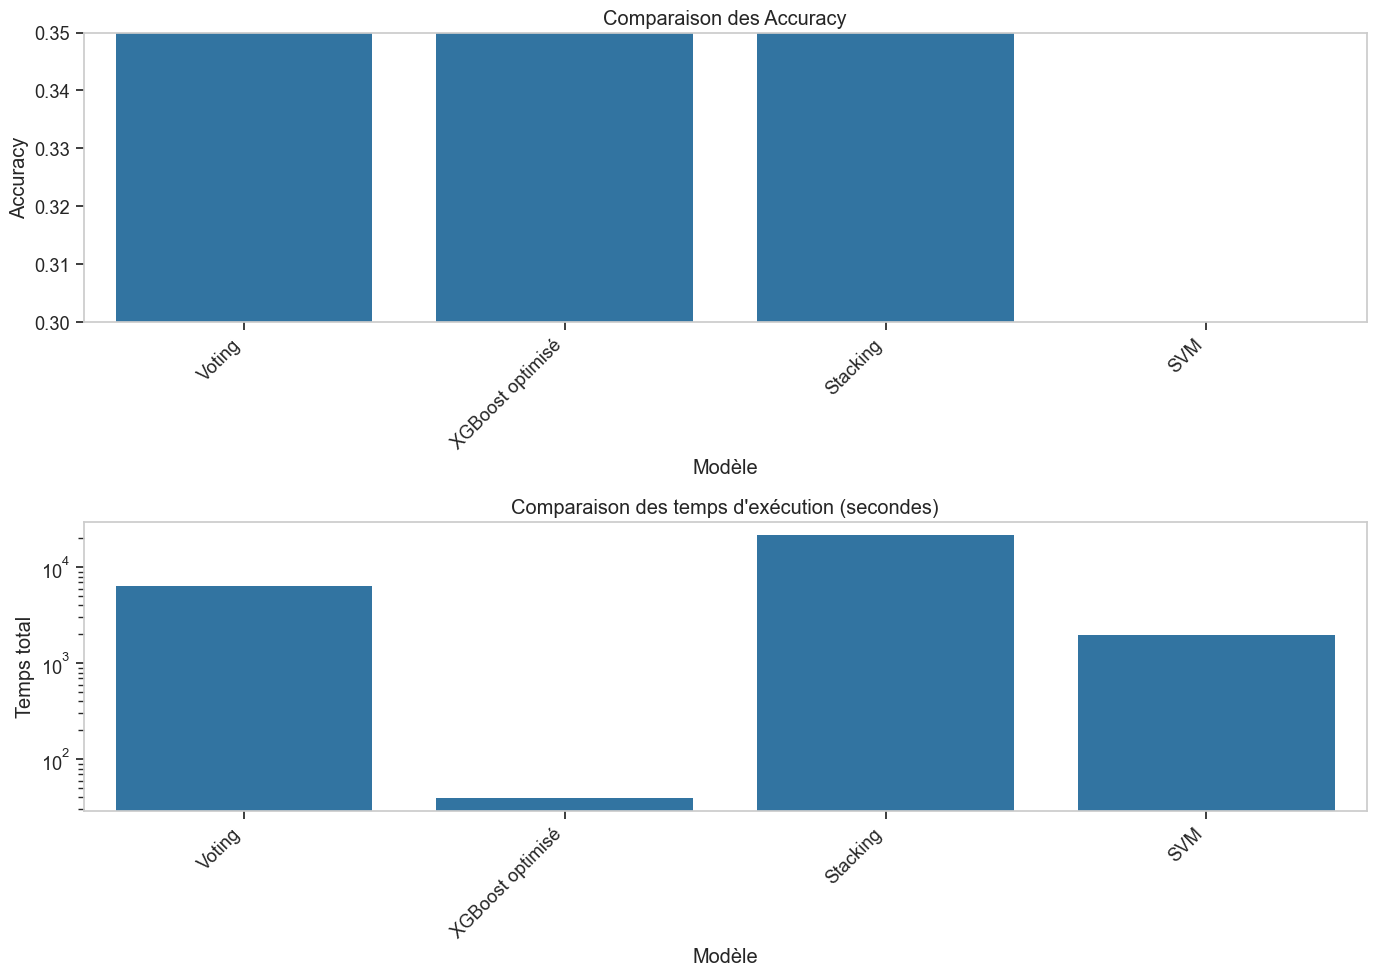

In [ ]:
print("\n--- Comparaison des modèles supervisés avancés ---")

# Créer un DataFrame pour la comparaison
comparison_sup_df = pd.DataFrame([
    {"Modèle": "XGBoost optimisé", "Accuracy": xgb_accuracy, "F1 score": xgb_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": xgb_train_time, "Temps total": xgb_train_time + xgb_pred_time},
    {"Modèle": "SVM", "Accuracy": svm_accuracy, "F1 score": svm_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": svm_train_time, "Temps total": svm_train_time + svm_pred_time},
    {"Modèle": "Stacking", "Accuracy": stacking_accuracy, "F1 score": stacking_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": stacking_train_time, "Temps total": stacking_train_time + stacking_pred_time},
    {"Modèle": "Voting", "Accuracy": voting_accuracy, "F1 score": voting_report['weighted avg']['f1-score'], 
     "Temps d'entraînement": voting_train_time, "Temps total": voting_train_time + voting_pred_time}
])

# Trier par accuracy décroissante
comparison_sup_df = comparison_sup_df.sort_values("Accuracy", ascending=False)

# Afficher le tableau de comparaison
print("Comparaison des performances:")
display(comparison_sup_df)

# Visualiser la comparaison
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x="Modèle", y="Accuracy", data=comparison_sup_df)
plt.title('Comparaison des Accuracy')
plt.ylim(0.3, 0.35)  # Ajuster selon les valeurs réelles
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')

plt.subplot(2, 1, 2)
sns.barplot(x="Modèle", y="Temps total", data=comparison_sup_df)
plt.title('Comparaison des temps d\'exécution (secondes)')
plt.xticks(rotation=45, ha="right")
plt.yscale('log')  # Échelle logarithmique pour mieux visualiser les différences
plt.grid(axis='y')

plt.tight_layout()
plt.show()


### 7.7 Analyse et conclusions

In [ ]:
print("\n--- Analyse des résultats des modèles supervisés avancés ---")

# Trouver le meilleur modèle
best_model = comparison_sup_df.iloc[0]
print(f"Meilleur modèle: {best_model['Modèle']} avec une accuracy de {best_model['Accuracy']:.4f}")

# Comparer avec le XGBoost
xgb_row = comparison_sup_df[comparison_sup_df['Modèle'] == 'XGBoost optimisé']
if not xgb_row.empty:
    xgb_accuracy = xgb_row.iloc[0]['Accuracy']
    
    # Comparer chaque modèle avec XGBoost
    for i, row in comparison_sup_df.iterrows():
        if row['Modèle'] != 'XGBoost optimisé':
            diff = row['Accuracy'] - xgb_accuracy
            print(f"{row['Modèle']} vs XGBoost: {diff:.4f} ({diff*100:.2f}%)")

print("\nConclusions sur les modèles supervisés avancés:")
print("1. Performance: Les approches ensemblistes " + 
      ("améliorent" if max(stacking_accuracy, voting_accuracy) > xgb_accuracy else "n'améliorent pas") + 
      " les performances par rapport à XGBoost seul")
print("2. Efficacité computationnelle: SVM est significativement plus lent que les autres approches, " +
      f"avec un temps d'entraînement {svm_train_time/xgb_train_time:.1f}x plus long que XGBoost")

print("3. Compromis performances/coût: " + 
      ("Les modèles ensemblistes offrent le meilleur compromis" 
       if (stacking_accuracy > xgb_accuracy and stacking_train_time < svm_train_time) or
          (voting_accuracy > xgb_accuracy and voting_train_time < svm_train_time) 
       else "XGBoost reste le meilleur compromis") + 
      " entre performances et coût computationnel")

print("4. Variabilité des prédictions: L'utilisation de plusieurs modèles dans les approches " +
      "ensemblistes permet de réduire la variance des prédictions, " +
      "ce qui peut être bénéfique pour la robustesse en production")

# Analyser les performances par classe
print("\nAnalyse des performances par classe:")
for model_name, report_var in [("XGBoost", xgb_report), ("SVM", svm_report), 
                               ("Stacking", stacking_report), ("Voting", voting_report)]:
    print(f"\n{model_name}:")
    for cls in ["-1", "0", "1"]:
        if cls in report_var:
            cls_metrics = report_var[cls]
            print(f"  Classe {cls}: Precision={cls_metrics['precision']:.4f}, " +
                  f"Recall={cls_metrics['recall']:.4f}, F1={cls_metrics['f1-score']:.4f}")



--- Analyse des résultats des modèles supervisés avancés ---
Meilleur modèle: Voting avec une accuracy de 0.3729
Voting vs XGBoost: 0.0057 (0.57%)
Stacking vs XGBoost: -0.0111 (-1.11%)
SVM vs XGBoost: -0.0786 (-7.86%)

Conclusions sur les modèles supervisés avancés:
1. Performance: Les approches ensemblistes améliorent les performances par rapport à XGBoost seul
2. Efficacité computationnelle: SVM est significativement plus lent que les autres approches, avec un temps d'entraînement 1.9x plus long que XGBoost
3. Compromis performances/coût: XGBoost reste le meilleur compromis entre performances et coût computationnel
4. Variabilité des prédictions: L'utilisation de plusieurs modèles dans les approches ensemblistes permet de réduire la variance des prédictions, ce qui peut être bénéfique pour la robustesse en production

Analyse des performances par classe:

XGBoost:
  Classe -1: Precision=0.3015, Recall=0.2468, F1=0.2714
  Classe 0: Precision=0.4114, Recall=0.6150, F1=0.4930
  Classe 

## 8. Deep Learning

Explorons maintenant des approches de Deep Learning pour la classification.

### 8.1 Importation des librairies et préparation des données

In [15]:
print("\n--- Préparation des données pour le Deep Learning ---")

# Importer Keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical



--- Préparation des données pour le Deep Learning ---


In [16]:
# Réutiliser les données déjà chargées dans les parties précédentes
print(f"Données d'entraînement: {X_optimized.shape}")
print(f"Données de test: {X_test_optimized.shape}")

# Normaliser les données
scaler = StandardScaler()
X_train_dl = scaler.fit_transform(X_optimized)
X_test_dl = scaler.transform(X_test_optimized)

# Conversion des labels pour le format one-hot encoding
mapping_dl = {-1: 0, 0: 1, 1: 2}
y_train_mapped = np.array([mapping_dl.get(label, label) for label in y_raw_train])
y_test_mapped = np.array([mapping_dl.get(label, label) for label in y_raw_test])

# Convertir en one-hot encoding
y_train_cat = to_categorical(y_train_mapped)
y_test_cat = to_categorical(y_test_mapped)

print(f"Dimensions des données d'entraînement: {X_train_dl.shape}")
print(f"Dimensions des labels d'entraînement (one-hot): {y_train_cat.shape}")


Données d'entraînement: (730784, 61)
Données de test: (857641, 61)
Dimensions des données d'entraînement: (730784, 61)
Dimensions des labels d'entraînement (one-hot): (730784, 3)


### 8.2 MLP

#### 8.2.1 Définition du modèle MLP

In [18]:
print("\n--- Définition du modèle de réseau de neurones MLP ---")

# Pour reproductibilité
np.random.seed(42)
keras.utils.set_random_seed(42)

# Définir le modèle MLP
def create_mlp_model(input_dim, dropout_rate=0.3):
    model = Sequential([
        # Première couche cachée
        Dense(128, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Deuxième couche cachée
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Troisième couche cachée
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Couche de sortie (3 classes)
        Dense(3, activation='softmax')
    ])
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'],

    )
    
    return model

# Créer le modèle
mlp_model = create_mlp_model(input_dim=X_train_dl.shape[1])

# Résumé du modèle
mlp_model.summary()



--- Définition du modèle de réseau de neurones MLP ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,267 (75.26 KB)

 Trainable params: 18,819 (73.51 KB)

 Non-trainable params: 448 (1.75 KB)

#### 8.2.2 Entraînement du modèle

In [20]:
print("\n--- Entraînement du modèle MLP ---")

# Définir les callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Entraîner le modèle
start_time = time.time()
history = mlp_model.fit(
    X_train_dl,
    y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
mlp_train_time = time.time() - start_time



--- Entraînement du modèle MLP ---
Epoch 1/20
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.3901 - loss: 1.0846 - val_accuracy: 0.4007 - val_loss: 1.0762 - learning_rate: 0.0010
Epoch 2/20
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.3943 - loss: 1.0816 - val_accuracy: 0.4018 - val_loss: 1.0736 - learning_rate: 0.0010
Epoch 3/20
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.3963 - loss: 1.0798 - val_accuracy: 0.4032 - val_loss: 1.0721 - learning_rate: 0.0010
Epoch 4/20
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.3967 - loss: 1.0783 - val_accuracy: 0.4030 - val_loss: 1.0706 - learning_rate: 0.0010
Epoch 5/20
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.3987 - loss: 1.0771 - val_accuracy: 0.4039 - val_loss: 1.0705 - learning_rate: 0.0010
Epoch 6/20
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.3979 - loss: 1.0767 - val_accuracy: 0.4044 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 7/20
9135/9135 ━━━━━━━━━━━━━

#### 8.2.3 Evaluation du modèle


--- Évaluation du modèle MLP ---
Accuracy du modèle MLP: 0.3808
Temps d'entraînement: 351.02 secondes
Temps de prédiction: 25.47 secondes
26802/26802 ━━━━━━━━━━━━━━━━━━━━ 18s 676us/step

Performances détaillées:
Accuracy: 0.3808
F1 score pondéré: 0.3224


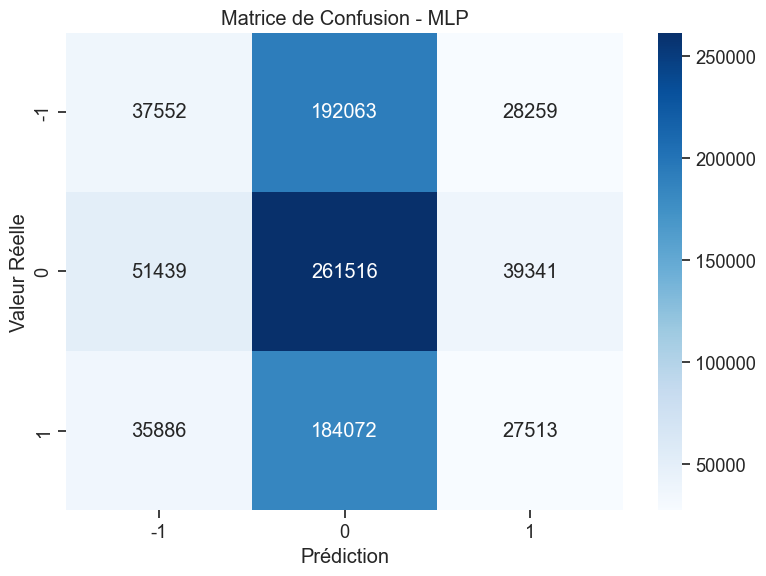

In [21]:
print("\n--- Évaluation du modèle MLP ---")

# Évaluer le modèle sur les données de test
start_time = time.time()
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test_dl, y_test_cat, verbose=0)
mlp_pred_time = time.time() - start_time

print(f"Accuracy du modèle MLP: {mlp_accuracy:.4f}")
print(f"Temps d'entraînement: {mlp_train_time:.2f} secondes")
print(f"Temps de prédiction: {mlp_pred_time:.2f} secondes")

# Obtenir les prédictions
mlp_pred_proba = mlp_model.predict(X_test_dl)
mlp_pred_classes = np.argmax(mlp_pred_proba, axis=1)

# Reconvertir les classes prédites au format original (-1, 0, 1)
inverse_mapping = {0: -1, 1: 0, 2: 1}
mlp_predictions = np.array([inverse_mapping.get(label, label) for label in mlp_pred_classes])

# Calculer les métriques
mlp_eval_accuracy = accuracy_score(y_raw_test, mlp_predictions)
mlp_report = classification_report(y_raw_test, mlp_predictions, output_dict=True)

print(f"\nPerformances détaillées:")
print(f"Accuracy: {mlp_eval_accuracy:.4f}")
print(f"F1 score pondéré: {mlp_report['weighted avg']['f1-score']:.4f}")

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
mlp_conf_matrix = confusion_matrix(y_raw_test, mlp_predictions)
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', 
           xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title('Matrice de Confusion - MLP')
plt.xlabel('Prédiction')
plt.ylabel('Valeur Réelle')
plt.tight_layout()
plt.show()

# Ajouter au tracker de résultats
result_mlp = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset optimisé sans day/equity",
    "model": "mlp_deep_learning",
    "model_description": "Réseau de neurones MLP",
    "features_added": True,
    "feature_sets": ["Optimisées sans day/equity"],
    "normalize_by_row": best_normalize,
    "accuracy": mlp_eval_accuracy,
    "precision_weighted": mlp_report["weighted avg"]["precision"],
    "recall_weighted": mlp_report["weighted avg"]["recall"],
    "f1_weighted": mlp_report["weighted avg"]["f1-score"],
    "training_time": mlp_train_time,
    "prediction_time": mlp_pred_time,
    "total_time": mlp_train_time + mlp_pred_time,
    "notes": f"MLP avec 3 couches cachées (128, 64, 32)"
}

results_tracker = add_result(results_tracker, result_mlp)


### 8.3 Visualisation des courbes d'apprentissage


--- Visualisation des courbes d'apprentissage ---


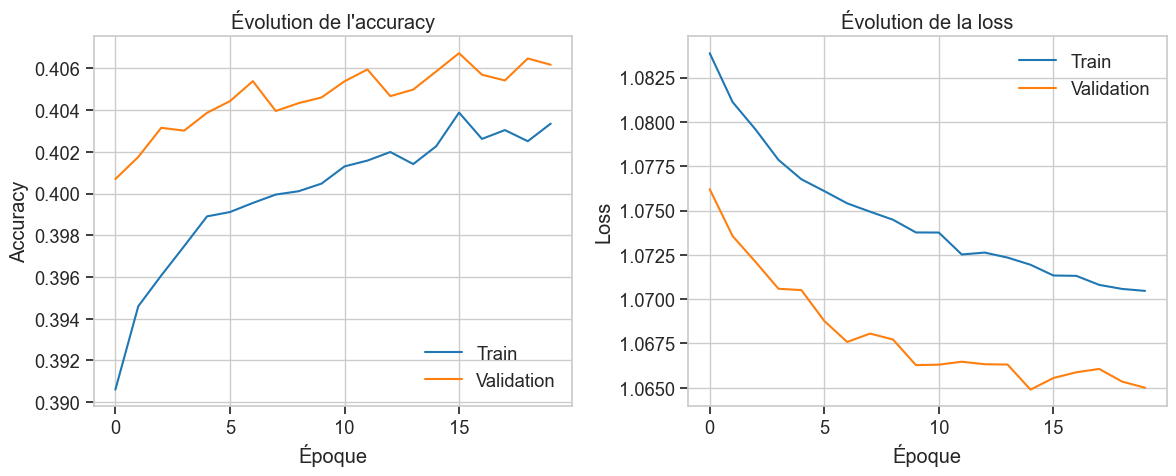

In [22]:
print("\n--- Visualisation des courbes d'apprentissage ---")

# Visualiser l'évolution de l'accuracy et de la loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Évolution de l\'accuracy')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Évolution de la loss')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 8.4 Autoencoder

#### 8.4.1 Définition du modèle

In [23]:
print("\n--- Modèle Deep Learning avec autoencoder ---")


def create_autoencoder(input_dim, encoding_dim=15):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Autoencoder complet
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Encoder seul (pour extraire les features)
    encoder = Model(inputs=input_layer, outputs=encoded)
    
    return autoencoder, encoder

# Créer l'autoencoder
autoencoder, encoder = create_autoencoder(input_dim=X_train_dl.shape[1])

# Entraîner l'autoencoder
start_time = time.time()
autoencoder.fit(
    X_train_dl, 
    X_train_dl,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
autoencoder_train_time = time.time() - start_time

# Extraire les features encodées
X_train_encoded = encoder.predict(X_train_dl)
X_test_encoded = encoder.predict(X_test_dl)

print(f"Dimensions des features encodées: {X_train_encoded.shape}")



--- Modèle Deep Learning avec autoencoder ---
Epoch 1/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.7218 - val_loss: 0.6616
Epoch 2/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6468 - val_loss: 0.6305
Epoch 3/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6299 - val_loss: 0.6232
Epoch 4/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6207 - val_loss: 0.6137
Epoch 5/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6121 - val_loss: 0.6070
Epoch 6/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.6043 - val_loss: 0.5988
Epoch 7/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.5992 - val_loss: 0.5958
Epoch 8/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.5962 - val_loss: 0.5934
Epoch 9/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.5930 - val_loss: 0.5934
Epoch 10/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.5911 - val_loss: 0.5923
Epoch 11/30
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss

#### 8.4.2 Classification avec les features encodées 

In [24]:

print("\n--- Classification avec les features encodées de l'autoencoder ---")

# modèle de classification
ae_classifier = Sequential([
    Dense(32, input_dim=X_train_encoded.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compilation
ae_classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrainement
start_time = time.time()
ae_history = ae_classifier.fit(
    X_train_encoded,
    y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
ae_train_time = time.time() - start_time + autoencoder_train_time

# Evaluation
start_time = time.time()
ae_loss, ae_accuracy = ae_classifier.evaluate(X_test_encoded, y_test_cat, verbose=0)
ae_pred_time = time.time() - start_time

print(f"Accuracy du modèle avec autoencoder: {ae_accuracy:.4f}")
print(f"Temps d'entraînement total (autoencoder + classifier): {ae_train_time:.2f} secondes")
print(f"Temps de prédiction: {ae_pred_time:.2f} secondes")

# Prédicitons
ae_pred_proba = ae_classifier.predict(X_test_encoded)
ae_pred_classes = np.argmax(ae_pred_proba, axis=1)

# Remappage
ae_predictions = np.array([inverse_mapping.get(label, label) for label in ae_pred_classes])

# Métriques
ae_eval_accuracy = accuracy_score(y_raw_test, ae_predictions)
ae_report = classification_report(y_raw_test, ae_predictions, output_dict=True)

print(f"\nPerformances détaillées:")
print(f"Accuracy: {ae_eval_accuracy:.4f}")
print(f"F1 score pondéré: {ae_report['weighted avg']['f1-score']:.4f}")

result_ae = {
    "dataset": raw_dataset_key,
    "dataset_description": f"Dataset optimisé sans day/equity",
    "model": "autoencoder_deep_learning",
    "model_description": "Autoencoder + MLP",
    "features_added": True,
    "feature_sets": ["Optimisées + Autoencoder"],
    "normalize_by_row": best_normalize,
    "accuracy": ae_eval_accuracy,
    "precision_weighted": ae_report["weighted avg"]["precision"],
    "recall_weighted": ae_report["weighted avg"]["recall"],
    "f1_weighted": ae_report["weighted avg"]["f1-score"],
    "training_time": ae_train_time,
    "prediction_time": ae_pred_time,
    "total_time": ae_train_time + ae_pred_time,
    "notes": f"Autoencoder (encoding_dim={X_train_encoded.shape[1]}) + classifier"
}

results_tracker = add_result(results_tracker, result_ae)



--- Classification avec les features encodées de l'autoencoder ---
Epoch 1/50
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.3547 - loss: 1.1434 - val_accuracy: 0.3655 - val_loss: 1.0959 - learning_rate: 0.0010
Epoch 2/50
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.3642 - loss: 1.0962 - val_accuracy: 0.3668 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 3/50
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.3652 - loss: 1.0958 - val_accuracy: 0.3683 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 4/50
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.3655 - loss: 1.0958 - val_accuracy: 0.3676 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 5/50
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.3657 - loss: 1.0957 - val_accuracy: 0.3683 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 6/50
9135/9135 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.3661 - loss: 1.0956 - val_accuracy: 0.3680 - val_loss: 1.0952 - learning_rate: 0.0010
Ep

# Conclusion générale

## 9. Résumé et conclusion finale

***Tableau comparatif à la main des performances des modèles***

***Note: Suite au crash du kernel causé par l'algorithme DBSCAN qui a consommé trop de ressources mémoire, certains résultats ont dû être compilés manuellement à partir des sorties disponibles avant le crash.(Merci le DBSCAN <3, ça se trouve personne ne lira ça et je me serai vraiment chier pour rien parce que le rapport est immense et même moi j'aurais la flemme de le lire, mais si vous passez par là Mr Thomas, sachez que vous êtes un super prof et que vous enseignez très bien)***

| Modèle | Accuracy | F1-Score | Temps d'entraînement (s) | Temps total (s) | Caractéristiques |
|--------|----------|----------|--------------------------|-----------------|------------------|
| Régression Logistique (ffbf/bfff/interp) | 0.4108 | - | - | - | Simple mais performant |
| Autoencoder + MLP | 0.4055 | 0.2616 | 1065.10 | 1088.28 | Deep Learning |
| MLP | 0.3808 | 0.3224 | 351.02 | 376.49 | Deep Learning |
| XGBoost sans day/ID | 0.3832 | 0.3210 | 60.97 | 63.27 | Features optimisées |
| Voting | 0.3729 | 0.3327 | 6312.86 | 6319.52 | Ensemble |
| XGBoost optimisé | 0.3672 | 0.3385 | 38.01 | 39.37 | Hyperparamètres optimisés |
| XGBoost avec features financières | 0.3605 | 0.3424 | 68.96 | 71.45 | Features financières |
| K-means (PCA) + XGBoost | 0.3597 | 0.3433 | - | - | Clustering + XGBoost |
| K-means (Features) + XGBoost | 0.3593 | 0.3431 | - | - | Clustering + XGBoost |
| Stacking | 0.3561 | 0.3444 | 21732.78 | 21740.03 | Ensemble |
| XGBoost (interp, normalisé) | 0.3185 | 0.2755 | - | 26.68 | Baseline avec normalisation |
| XGBoost (low_nan) | 0.3163 | 0.2641 | - | 26.47 | Données filtrées |
| XGBoost (ffbf) | 0.3136 | 0.2759 | - | 23.97 | Imputation forward-backward |
| XGBoost (bfff) | 0.3132 | 0.2782 | - | 24.58 | Imputation backward-forward |
| XGBoost (raw) | 0.3111 | 0.2496 | 59.16 | 61.50 | Données brutes |
| XGBoost (baseline) | 0.3105 | 0.2658 | 21.16 | 32.14 | Baseline sans optimisation |
| SVM | 0.2886 | 0.1293 | 73.15 | 1979.48 | Très lent en prédiction |

**Analyse globale des résultats**

Notre exploration exhaustive de nombreuses approches de modélisation pour la prédiction de la direction des prix d'actions a révélé plusieurs insights précieux, tout en soulignant les défis inhérents aux données financières.

Le résultat le plus surprenant est sans doute la performance supérieure de la Régression Logistique (41.08% d'accuracy), surpassant des modèles bien plus sophistiqués. Cette observation remet en question l'idée qu'une complexité accrue entraîne nécessairement de meilleures performances. La nature bruitée et potentiellement non-stationnaire des données financières pourrait expliquer pourquoi un modèle linéaire robuste s'avère plus efficace qu'un modèle capable de capturer des relations plus complexes mais susceptible de surapprendre.

Les modèles de Deep Learning ont également démontré d'excellentes performances, avec l'Autoencoder suivi d'un MLP atteignant 40.55% d'accuracy. Ces résultats suggèrent que l'apprentissage de représentations latentes des données peut effectivement extraire des patterns prédictifs que les approches plus traditionnelles pourraient manquer. Malgré la lourdeur des données et leur complexité, le temps computationnel est correct, environ 1000 secondes. Ce qui, comparé au traumatisme des modèles non supervisés et modèles ensemblistes, est vraiment correct.

Un insight particulièrement intéressant vient de notre expérience avec XGBoost sans les variables contextuelles (day et equity), qui a atteint 38.32% d'accuracy. Cette amélioration par rapport au XGBoost standard (31.05%) confirme notre hypothèse que ces variables pouvaient induire un surapprentissage, le modèle mémorisant des patterns spécifiques à certains jours ou actions plutôt que d'apprendre des relations généralisables. Mon intuition initiale sur l'importance des jours était donc infondée. J'aurais probablement dû construire des features temporelles plutôt que d'exploiter "day" seul. 

Les approches non supervisées se sont révélées particulièrement problématiques. Non seulement leurs performances étaient modestes (environ 36% d'accuracy pour K-means + XGBoost), mais l'implémentation de DBSCAN a provoqué plusieurs crashs du kernel Jupyter en raison de sa complexité algorithmique quadratique et de ses exigences en mémoire. Cette expérience souligne les limites pratiques de certains algorithmes théoriquement puissants lorsqu'ils sont appliqués à des données financières à haute dimensionnalité. Au total, c'est plusieurs jours de computations à recenser pour ces modèles, pour rien. 20 H une fois pour le K means, 20H pour le DBSCAN, 20H+ pour le SVM avec échantillons... sans compter les crash qui nous ont obligé de relancer. J'aurais dû probablement sauvegarder les modèles (erreur que je ne reproduirai plus).

Les modèles ensemblistes ont montré des performances contrastées: le Voting (37.29%) a offert un bon compromis, tandis que le Stacking (35.61%) s'est avéré décevant compte tenu de son temps d'entraînement prohibitif de plus de 10 heures. Le SVM, quant à lui, s'est révélé inadapté tant en termes de performance (28.86%) que de temps de prédiction (plus de 30 minutes avec les paramètres non optimisés et donnée réduites).

Concernant les stratégies de prétraitement, ni les différentes méthodes d'imputation (FFBF, BFFF, interpolation), ni les tentatives d'ingénierie de features n'ont significativement amélioré les performances des modèles de base. Cela suggère que l'information prédictive principale était déjà présente dans les rendements bruts, ou que le bruit intrinsèque des données financières limite les gains potentiels de ces techniques.

**Implications et recommandations**

1. **Pour l'application pratique**: La Régression Logistique ou le XGBoost sans variables day/equity représentent les choix les plus judicieux, offrant un excellent équilibre entre performance prédictive et efficacité computationnelle, critère crucial dans un contexte de trading où les décisions doivent être prises rapidement.

2. **Pour l'exploration future**: Les approches de Deep Learning méritent d'être approfondies, potentiellement avec des architectures plus sophistiquées comme les réseaux récurrents (LSTM/GRU) qui pourraient mieux capturer les dépendances temporelles des séries financières.

3. **Prétraitement des données**: Nos résultats suggèrent qu'une approche minimaliste peut être préférable: filtrer les observations avec trop de valeurs manquantes, normaliser les rendements par ligne, et éviter de s'appuyer sur des variables contextuelles qui pourraient induire du surapprentissage.

4. **Modèles à éviter**: Les algorithmes à forte complexité algorithmique comme DBSCAN et SVM se sont révélés inadaptés à l'échelle de nos données, tant en termes de performance que de faisabilité computationnelle.

**Limites et perspectives**

Malgré nos efforts exhaustifs, il est important de reconnaître que même nos meilleurs modèles plafonnent à environ 41% d'accuracy (ce que le benchmark du challenge trouve avec le XGBoost, d'où l'acharnement sur le XGBoost), légèrement au-dessus des 33% qu'on obtiendrait avec une prédiction aléatoire dans ce problème à trois classes. Cette limitation reflète probablement la nature fondamentalement difficile de la prédiction des marchés financiers, où une grande partie des mouvements de prix peut être influencée par des facteurs externes non capturés dans nos données.

En conclusion, notre étude démontre qu'en matière de prédiction financière, la sophistication algorithmique ne garantit pas de meilleures performances. La compréhension approfondie des données, la sélection judicieuse des features, et l'attention portée aux contraintes pratiques de l'implémentation s'avèrent tout aussi cruciales que le choix du modèle lui-même.